In [1]:
import os
import gymnasium   #
import CoppeliaSim_Gym   # Entorno personalizado
import numpy as np
import matplotlib.pyplot as plt
import stable_baselines3   # Biblioteca RL
import torch as th   # para modelo CNN
import torch.nn as nn
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env # Verificar el entorno
from stable_baselines3.common.vec_env import VecFrameStack, VecNormalize # Envoltorio para imagen
from stable_baselines3.sac.policies import MlpPolicy, CnnPolicy # Arquitectura de RN
from stable_baselines3 import A2C, TD3, DQN, DDPG, PPO, SAC, HER # algoritmo de entrenamiento
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import get_system_info
from stable_baselines3.common.noise import NormalActionNoise

from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
#get_system_info(True)

In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [3]:
# Create log dir
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
# Inicializar el entorno
ENV_NAME = "CoppeliaSim_Gym/GymCoppManR-v0"
#env = gymnasium.make(ENV_NAME) 
env = make_vec_env(ENV_NAME, n_envs=1, seed=1, monitor_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=20, log_dir=log_dir, verbose=1)
# check_env(env, warn=True) # si funciona
# env = VecFrameStack(env, n_stack=4)

Conectado al servidor API remoto


In [4]:
# Arquitectura CNN personalizada CON IMAGENES  - 1
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """
    def __init__(self, observation_space: spaces.Box, joint_dim: int = 3):
        super().__init__(observation_space, joint_dim)
        
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(), nn.ReLU(),
            nn.Linear(3456, 32), nn.ReLU(),
            nn.Linear(32, 3), nn.Tanh()
        )
        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]
        self.linear = nn.Sequential(nn.Linear(n_flatten, joint_dim), nn.ReLU())
        
    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))
    
policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(joint_dim=3),
)

In [4]:
# Arquitectura CNN personalizada CON IMAGENES  - 2
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """
    def __init__(self, observation_space: spaces.Box, joint_dim: int = 3):
        super().__init__(observation_space, joint_dim)
        
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(3456, 32), nn.ReLU(),
            nn.Linear(32, 3)
        )
        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]
        self.linear = nn.Sequential(nn.Linear(n_flatten, joint_dim))
        
    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))
    
policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(joint_dim=3),
)

In [4]:
# Arquitectura CNN personalizada CON IMAGENES  - 3
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """
    def __init__(self, observation_space: spaces.Box, joint_dim: int = 3):
        super().__init__(observation_space, joint_dim)
        
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(3456, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 3)
        )
        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]
        self.linear = nn.Sequential(nn.Linear(n_flatten, joint_dim))
        
    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))
    
policy_kwargs = dict(
    features_extractor_class = CustomCNN,
    features_extractor_kwargs = dict(joint_dim=3),
)

In [5]:
# Definir y entrenar el agente
model = A2C("CnnPolicy", env, gamma=0.99, policy_kwargs=policy_kwargs, verbose=1, device="auto", 
            tensorboard_log='./A2C_tensorboard/')
model.learn(total_timesteps = 10000, callback=callback)
model.save("modeloA2C-TC-1") # Guardar modelo DRL

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./A2C_tensorboard/A2C_4
--------------------------------------------------------------------
STEP:  1
Acciones:  [0.10522991 0.63798296 1.        ]
Angulos: Trayectoria: 1.459, Efector Final: -0.000
RC: 0.248, RG: -2.000, RA: 0.436, RF: 0.000
--- RECOMPENSA TOTAL: -1.316 --- 
--------------------------------------------------------------------
STEP:  2
Acciones:  [ 0.5983679   0.30639622 -1.        ]
Angulos: Trayectoria: -1.842, Efector Final: 1.000
RC: 0.249, RG: -2.000, RA: 0.024, RF: 0.000
--- RECOMPENSA TOTAL: -1.727 --- 
--------------------------------------------------------------------
STEP:  3
Acciones:  [-1.        -0.9666488 -1.       ]
Angulos: Trayectoria: -2.656, Efector Final: -0.000
RC: 0.246, RG: -2.000, RA: 0.742, RF: 0.000
--- RECOMPENSA TOTAL: -1.012 --- 
--------------------------------------------------------------------
STEP:  4
Acciones:  [0.20096624 0.31949332 0.3743411 ]
Angulos: Trayectori

Angulos: Trayectoria: -2.837, Efector Final: 1.081
RC: 0.248, RG: -2.000, RA: 0.154, RF: 0.000
--- RECOMPENSA TOTAL: -1.599 --- 
--------------------------------------------------------------------
STEP:  33
Acciones:  [ 0.8415987 -0.363235   0.7586873]
Angulos: Trayectoria: -5.836, Efector Final: 0.081
RC: 0.242, RG: 1.517, RA: 0.309, RF: 0.000
--- RECOMPENSA TOTAL: 2.069 --- 
--------------------------------------------------------------------
STEP:  34
Acciones:  [ 0.78676486 -0.534725   -0.24800532]
Angulos: Trayectoria: -10.643, Efector Final: 0.840
RC: 0.236, RG: -0.496, RA: 0.001, RF: 0.000
--- RECOMPENSA TOTAL: -0.259 --- 
--------------------------------------------------------------------
STEP:  35
Acciones:  [ 0.2229655   0.27359122 -1.        ]
Angulos: Trayectoria: -13.650, Efector Final: 0.592
RC: 0.232, RG: -2.000, RA: 0.126, RF: 0.000
--- RECOMPENSA TOTAL: -1.642 --- 
--------------------------------------------------------------------
STEP:  36
Acciones:  [-0.4801518 -

Angulos: Trayectoria: 0.499, Efector Final: 0.715
RC: 0.248, RG: -1.747, RA: 0.469, RF: 0.000
--- RECOMPENSA TOTAL: -1.030 --- 
--------------------------------------------------------------------
STEP:  65
Acciones:  [0.18883917 1.         0.9055805 ]
Angulos: Trayectoria: 1.162, Efector Final: 1.588
RC: 0.246, RG: -1.811, RA: 0.524, RF: 0.000
--- RECOMPENSA TOTAL: -1.041 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  66
Acciones:  [0.3454427 0.6002723 0.2741484]
Angulos: Trayectoria: -0.597, Efector Final: -0.000
RC: 0.249, RG: 0.548, RA: 0.305, RF: 0.000
--- RECOMPENSA TOTAL: 1.102 --- 
--------------------------------------------------------------------
STEP:  67
Acciones:  [-0.69972515  0.10469079  1.        ]
Angulos: Trayectoria: 1.239, Efector Final: 0.274
RC: 0.248, RG: -2.000, RA: 0.101, RF: 0.000
--- RECOMPENSA TOTAL: -1.651 --- 
--------------------------------------------------------------------
STEP:  68
Acciones:  [ 1.

Angulos: Trayectoria: -0.060, Efector Final: 1.000
RC: 0.249, RG: 2.000, RA: 0.435, RF: 0.000
--- RECOMPENSA TOTAL: 2.684 --- 
--------------------------------------------------------------------
STEP:  98
Acciones:  [0.85892695 0.86051285 1.        ]
Angulos: Trayectoria: -2.730, Efector Final: 2.000
RC: 0.249, RG: 2.000, RA: 0.680, RF: 0.000
--- RECOMPENSA TOTAL: 2.929 --- 
--------------------------------------------------------------------
STEP:  99
Acciones:  [ 1.          0.12265104 -0.38802183]
Angulos: Trayectoria: -9.856, Efector Final: 3.000
RC: 0.240, RG: -0.776, RA: 0.184, RF: 0.000
--- RECOMPENSA TOTAL: -0.352 --- 
--------------------------------------------------------------------
STEP:  100
Acciones:  [-1.          0.29502237 -0.41565216]
Angulos: Trayectoria: -4.205, Efector Final: 2.612
RC: 0.248, RG: -0.831, RA: 0.280, RF: 0.000
--- RECOMPENSA TOTAL: -0.303 --- 
Num timesteps: 100
Best mean reward: 8.43 - Last mean reward per episode: 8.52
Saving new best model to ./

Angulos: Trayectoria: 14.917, Efector Final: 16.615
RC: 0.206, RG: -0.901, RA: 0.214, RF: 0.000
--- RECOMPENSA TOTAL: -0.480 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  130
Acciones:  [1.         0.90556484 1.        ]
Angulos: Trayectoria: -0.653, Efector Final: -0.000
RC: 0.249, RG: 2.000, RA: 0.726, RF: 0.000
--- RECOMPENSA TOTAL: 2.975 --- 
--------------------------------------------------------------------
STEP:  131
Acciones:  [ 1.         -0.06210527  0.7390641 ]
Angulos: Trayectoria: -4.226, Efector Final: 1.000
RC: 0.246, RG: 1.478, RA: 0.419, RF: 0.000
--- RECOMPENSA TOTAL: 2.143 --- 
--------------------------------------------------------------------
STEP:  132
Acciones:  [ 0.69070923 -0.09496272  0.684781  ]
Angulos: Trayectoria: -9.545, Efector Final: 1.739
RC: 0.239, RG: 1.370, RA: 0.320, RF: 0.000
--- RECOMPENSA TOTAL: 1.929 --- 
--------------------------------------------------------------------
STEP:  133
Accio

Num timesteps: 160
Best mean reward: 12.02 - Last mean reward per episode: 11.62
--------------------------------------------------------------------
STEP:  161
Acciones:  [ 0.00358909 -0.42465377  1.        ]
Angulos: Trayectoria: 0.854, Efector Final: -0.000
RC: 0.249, RG: -2.000, RA: 0.145, RF: 0.000
--- RECOMPENSA TOTAL: -1.606 --- 
--------------------------------------------------------------------
STEP:  162
Acciones:  [ 1.         -0.09903473  1.        ]
Angulos: Trayectoria: -0.060, Efector Final: 1.000
RC: 0.249, RG: 2.000, RA: 0.475, RF: 0.000
--- RECOMPENSA TOTAL: 2.724 --- 
--------------------------------------------------------------------
STEP:  163
Acciones:  [ 1.         -0.74795854  0.969895  ]
Angulos: Trayectoria: -3.275, Efector Final: 2.000
RC: 0.248, RG: 1.940, RA: 0.305, RF: 0.000
--- RECOMPENSA TOTAL: 2.494 --- 
--------------------------------------------------------------------
STEP:  164
Acciones:  [0.45349693 1.         0.88641894]
Angulos: Trayectoria: -

Angulos: Trayectoria: -10.345, Efector Final: 1.678
RC: 0.238, RG: 0.675, RA: 0.045, RF: 0.000
--- RECOMPENSA TOTAL: 0.958 --- 
--------------------------------------------------------------------
STEP:  194
Acciones:  [ 1. -1.  1.]
Angulos: Trayectoria: -16.604, Efector Final: 2.015
RC: 0.230, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.480 --- 
--------------------------------------------------------------------
STEP:  195
Acciones:  [ 1.         -0.22913599  1.        ]
Angulos: Trayectoria: -23.400, Efector Final: 3.015
RC: 0.222, RG: 2.000, RA: 0.443, RF: 0.000
--- RECOMPENSA TOTAL: 2.664 --- 
--------------------------------------------------------------------
STEP:  196
Acciones:  [ 1. -1.  1.]
Angulos: Trayectoria: -31.222, Efector Final: 4.015
RC: 0.212, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.462 --- 
--------------------------------------------------------------------
STEP:  197
Acciones:  [ 1.        -1.        -0.5701368]
Angulos: Trayectoria: -

Angulos: Trayectoria: -45.958, Efector Final: 4.079
RC: 0.192, RG: 2.000, RA: 0.535, RF: 0.000
--- RECOMPENSA TOTAL: 2.727 --- 
--------------------------------------------------------------------
STEP:  226
Acciones:  [ 0.77677876 -0.08918166  1.        ]
Angulos: Trayectoria: -28.690, Efector Final: 5.079
RC: 0.217, RG: 2.000, RA: 0.422, RF: 0.000
--- RECOMPENSA TOTAL: 2.639 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  227
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -0.177, Efector Final: -0.000
RC: 0.250, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 3.000 --- 
--------------------------------------------------------------------
STEP:  228
Acciones:  [0.27332115 0.4371195  1.        ]
Angulos: Trayectoria: -2.171, Efector Final: 1.000
RC: 0.248, RG: 2.000, RA: 0.428, RF: 0.000
--- RECOMPENSA TOTAL: 2.676 --- 
--------------------------------------------------------------------
STEP:  229
Acciones:  [0.39873958 0.8312944 

Angulos: Trayectoria: 6.542, Efector Final: 9.827
RC: 0.227, RG: -1.458, RA: 0.682, RF: 0.000
--- RECOMPENSA TOTAL: -0.549 --- 
--------------------------------------------------------------------
STEP:  259
Acciones:  [ 1.        -1.        -0.4047457]
Angulos: Trayectoria: 10.708, Efector Final: 10.556
RC: 0.220, RG: 0.809, RA: 0.101, RF: 0.000
--- RECOMPENSA TOTAL: 1.131 --- 
--------------------------------------------------------------------
STEP:  260
Acciones:  [0.79348683 1.         1.        ]
Angulos: Trayectoria: 17.440, Efector Final: 10.151
RC: 0.212, RG: -2.000, RA: 0.698, RF: 0.000
--- RECOMPENSA TOTAL: -1.090 --- 
Num timesteps: 260
Best mean reward: 15.87 - Last mean reward per episode: 14.96
--------------------------------------------------------------------
STEP:  261
Acciones:  [0.8072789 1.        1.       ]
Angulos: Trayectoria: 25.676, Efector Final: 11.151
RC: 0.199, RG: -2.000, RA: 0.702, RF: 0.000
--- RECOMPENSA TOTAL: -1.099 --- 
----------------------------

Angulos: Trayectoria: 0.499, Efector Final: 1.000
RC: 0.248, RG: -2.000, RA: 0.300, RF: 0.000
--- RECOMPENSA TOTAL: -1.453 --- 
--------------------------------------------------------------------
STEP:  291
Acciones:  [ 0.13897252 -1.          0.5685128 ]
Angulos: Trayectoria: 1.253, Efector Final: 2.000
RC: 0.245, RG: -1.137, RA: 0.073, RF: 0.000
--- RECOMPENSA TOTAL: -0.818 --- 
--------------------------------------------------------------------
STEP:  292
Acciones:  [ 1.          0.95260644 -0.14203942]
Angulos: Trayectoria: -1.428, Efector Final: 2.569
RC: 0.248, RG: -0.284, RA: 0.453, RF: 0.000
--- RECOMPENSA TOTAL: 0.417 --- 
--------------------------------------------------------------------
STEP:  293
Acciones:  [1.         0.22751334 1.        ]
Angulos: Trayectoria: -6.017, Efector Final: 2.426
RC: 0.245, RG: 2.000, RA: 0.557, RF: 0.000
--- RECOMPENSA TOTAL: 2.802 --- 
--------------------------------------------------------------------
STEP:  294
Acciones:  [0.7243856 1. 

Angulos: Trayectoria: 62.313, Efector Final: 29.226
RC: 0.123, RG: -1.960, RA: 0.415, RF: 0.000
--- RECOMPENSA TOTAL: -1.422 --- 
--------------------------------------------------------------------
STEP:  323
Acciones:  [ 0.4415174 -1.         1.       ]
Angulos: Trayectoria: 72.102, Efector Final: 30.206
RC: 0.108, RG: -2.000, RA: 0.110, RF: 0.000
--- RECOMPENSA TOTAL: -1.782 --- 
--------------------------------------------------------------------
STEP:  324
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 78.611, Efector Final: 31.206
RC: 0.097, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.347 --- 
--------------------------------------------------------------------
STEP:  325
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 83.811, Efector Final: 30.206
RC: 0.092, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.158 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  326
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -0.177

Angulos: Trayectoria: -13.247, Efector Final: 1.645
RC: 0.234, RG: 2.000, RA: 0.480, RF: 0.000
--- RECOMPENSA TOTAL: 2.713 --- 
--------------------------------------------------------------------
STEP:  356
Acciones:  [1.         1.         0.06870174]
Angulos: Trayectoria: -21.795, Efector Final: 2.645
RC: 0.223, RG: 0.137, RA: 0.517, RF: 0.000
--- RECOMPENSA TOTAL: 0.878 --- 
--------------------------------------------------------------------
STEP:  357
Acciones:  [0.8704711 1.        1.       ]
Angulos: Trayectoria: -30.010, Efector Final: 2.714
RC: 0.212, RG: 2.000, RA: 0.718, RF: 0.000
--- RECOMPENSA TOTAL: 2.930 --- 
--------------------------------------------------------------------
STEP:  358
Acciones:  [0.32049906 1.         0.8070748 ]
Angulos: Trayectoria: -33.226, Efector Final: 3.714
RC: 0.209, RG: 1.614, RA: 0.532, RF: 0.000
--- RECOMPENSA TOTAL: 2.355 --- 
--------------------------------------------------------------------
STEP:  359
Acciones:  [1. 1. 1.]
Angulos: Tr

Angulos: Trayectoria: 23.171, Efector Final: 14.374
RC: 0.198, RG: -1.810, RA: 0.127, RF: 0.000
--- RECOMPENSA TOTAL: -1.486 --- 
--------------------------------------------------------------------
STEP:  388
Acciones:  [1.        1.        0.8006436]
Angulos: Trayectoria: 34.197, Efector Final: 15.279
RC: 0.181, RG: -1.601, RA: 0.700, RF: 0.000
--- RECOMPENSA TOTAL: -0.720 --- 
--------------------------------------------------------------------
STEP:  389
Acciones:  [0.79703635 0.5758457  0.71741873]
Angulos: Trayectoria: 45.078, Efector Final: 16.080
RC: 0.165, RG: -1.435, RA: 0.523, RF: 0.000
--- RECOMPENSA TOTAL: -0.747 --- 
--------------------------------------------------------------------
STEP:  390
Acciones:  [ 1.        -0.3529694  1.       ]
Angulos: Trayectoria: 57.945, Efector Final: 16.797
RC: 0.146, RG: -2.000, RA: 0.412, RF: 0.000
--- RECOMPENSA TOTAL: -1.442 --- 
--------------------------------------------------------------------
STEP:  391
Acciones:  [-0.4430375  1

Angulos: Trayectoria: 28.035, Efector Final: 13.758
RC: 0.192, RG: -2.000, RA: 0.722, RF: 0.000
--- RECOMPENSA TOTAL: -1.086 --- 
Num timesteps: 420
Best mean reward: 16.65 - Last mean reward per episode: 15.77
--------------------------------------------------------------------
STEP:  421
Acciones:  [-0.1205492  -1.         -0.15289342]
Angulos: Trayectoria: 24.887, Efector Final: 14.758
RC: 0.195, RG: 0.306, RA: 0.318, RF: 0.000
--- RECOMPENSA TOTAL: 0.819 --- 
--------------------------------------------------------------------
STEP:  422
Acciones:  [0.35671532 0.3460256  1.        ]
Angulos: Trayectoria: 29.762, Efector Final: 14.605
RC: 0.188, RG: -2.000, RA: 0.426, RF: 0.000
--- RECOMPENSA TOTAL: -1.386 --- 
--------------------------------------------------------------------
STEP:  423
Acciones:  [1.         1.         0.89531136]
Angulos: Trayectoria: 18.782, Efector Final: 15.605
RC: 0.202, RG: -1.791, RA: 0.724, RF: 0.000
--- RECOMPENSA TOTAL: -0.865 --- 
 --- REINICIO --- 
-

Angulos: Trayectoria: 4.196, Efector Final: 11.090
RC: 0.229, RG: -2.000, RA: 0.452, RF: 0.000
--- RECOMPENSA TOTAL: -1.319 --- 
--------------------------------------------------------------------
STEP:  454
Acciones:  [ 1.          1.         -0.11931634]
Angulos: Trayectoria: 4.763, Efector Final: 12.090
RC: 0.227, RG: 0.239, RA: 0.470, RF: 0.000
--- RECOMPENSA TOTAL: 0.935 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  455
Acciones:  [ 1.  1. -1.]
Angulos: Trayectoria: -3.998, Efector Final: -0.000
RC: 0.244, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.506 --- 
--------------------------------------------------------------------
STEP:  456
Acciones:  [ 1.         -0.28149647  0.6334732 ]
Angulos: Trayectoria: -7.708, Efector Final: -1.000
RC: 0.238, RG: 1.267, RA: 0.338, RF: 0.000
--- RECOMPENSA TOTAL: 1.843 --- 
--------------------------------------------------------------------
STEP:  457
Acciones:  [1. 1. 1.]
An

Angulos: Trayectoria: 19.972, Efector Final: 12.402
RC: 0.205, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.045 --- 
--------------------------------------------------------------------
STEP:  486
Acciones:  [ 0.7600939 -0.3242029  1.       ]
Angulos: Trayectoria: 25.896, Efector Final: 13.402
RC: 0.195, RG: -2.000, RA: 0.359, RF: 0.000
--- RECOMPENSA TOTAL: -1.446 --- 
--------------------------------------------------------------------
STEP:  487
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 38.372, Efector Final: 14.402
RC: 0.177, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.073 --- 
--------------------------------------------------------------------
STEP:  488
Acciones:  [ 1.        -0.1107046  1.       ]
Angulos: Trayectoria: 50.967, Efector Final: 15.402
RC: 0.158, RG: -2.000, RA: 0.472, RF: 0.000
--- RECOMPENSA TOTAL: -1.370 --- 
--------------------------------------------------------------------
STEP:  489
Acciones:  [ 1. -1.  1.]
Angulos: Trayectoria:

Angulos: Trayectoria: -7.005, Efector Final: 2.000
RC: 0.243, RG: 2.000, RA: 0.668, RF: 0.000
--- RECOMPENSA TOTAL: 2.911 --- 
--------------------------------------------------------------------
STEP:  516
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -12.994, Efector Final: 3.000
RC: 0.236, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.986 --- 
--------------------------------------------------------------------
STEP:  517
Acciones:  [1.         0.14727314 0.939239  ]
Angulos: Trayectoria: -20.449, Efector Final: 4.000
RC: 0.227, RG: 1.878, RA: 0.522, RF: 0.000
--- RECOMPENSA TOTAL: 2.627 --- 
--------------------------------------------------------------------
STEP:  518
Acciones:  [1.         0.16558094 0.5010069 ]
Angulos: Trayectoria: -29.453, Efector Final: 4.939
RC: 0.216, RG: 1.002, RA: 0.417, RF: 0.000
--- RECOMPENSA TOTAL: 1.635 --- 
--------------------------------------------------------------------
STEP:  519
Acciones:  [0.41311073 0.8663571  1.        ]
Angulos: 

Angulos: Trayectoria: -36.121, Efector Final: 5.000
RC: 0.207, RG: 1.434, RA: 0.679, RF: 0.000
--- RECOMPENSA TOTAL: 2.320 --- 
--------------------------------------------------------------------
STEP:  549
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -46.931, Efector Final: 5.717
RC: 0.193, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.943 --- 
--------------------------------------------------------------------
STEP:  550
Acciones:  [1.         0.87019366 1.        ]
Angulos: Trayectoria: -51.176, Efector Final: 6.717
RC: 0.188, RG: 2.000, RA: 0.718, RF: 0.000
--- RECOMPENSA TOTAL: 2.906 --- 
--------------------------------------------------------------------
STEP:  551
Acciones:  [ 0.9294696  -0.31277585  1.        ]
Angulos: Trayectoria: -46.688, Efector Final: 7.717
RC: 0.196, RG: 2.000, RA: 0.404, RF: 0.000
--- RECOMPENSA TOTAL: 2.600 --- 
--------------------------------------------------------------------
STEP:  552
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -34.485

--------------------------------------------------------------------
STEP:  581
Acciones:  [1.         0.97693896 1.        ]
Angulos: Trayectoria: -47.484, Efector Final: 8.000
RC: 0.195, RG: 2.000, RA: 0.744, RF: 0.000
--- RECOMPENSA TOTAL: 2.939 --- 
--------------------------------------------------------------------
STEP:  582
Acciones:  [1.        0.9099219 1.       ]
Angulos: Trayectoria: -48.250, Efector Final: 9.000
RC: 0.195, RG: 2.000, RA: 0.727, RF: 0.000
--- RECOMPENSA TOTAL: 2.923 --- 
--------------------------------------------------------------------
STEP:  583
Acciones:  [1.         0.67073596 1.        ]
Angulos: Trayectoria: -39.191, Efector Final: 10.000
RC: 0.209, RG: 2.000, RA: 0.668, RF: 0.000
--- RECOMPENSA TOTAL: 2.877 --- 
--------------------------------------------------------------------
STEP:  584
Acciones:  [1.        0.7284148 1.       ]
Angulos: Trayectoria: -26.257, Efector Final: 11.000
RC: 0.229, RG: 2.000, RA: 0.682, RF: 0.000
--- RECOMPENSA TOTAL:

Angulos: Trayectoria: -48.828, Efector Final: 9.104
RC: 0.195, RG: 1.969, RA: 0.405, RF: 0.000
--- RECOMPENSA TOTAL: 2.569 --- 
--------------------------------------------------------------------
STEP:  614
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.901, Efector Final: 10.089
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  615
Acciones:  [0.7529899  0.54851437 1.        ]
Angulos: Trayectoria: -30.128, Efector Final: 11.089
RC: 0.224, RG: 2.000, RA: 0.575, RF: 0.000
--- RECOMPENSA TOTAL: 2.799 --- 
--------------------------------------------------------------------
STEP:  616
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -17.296, Efector Final: 12.089
RC: 0.243, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.993 --- 
--------------------------------------------------------------------
STEP:  617
Acciones:  [0.98332876 1.         1.        ]
Angulos: Trayectoria: -7.593,

Angulos: Trayectoria: -6.836, Efector Final: 2.691
RC: 0.244, RG: 2.000, RA: 0.099, RF: 0.000
--- RECOMPENSA TOTAL: 2.343 --- 
--------------------------------------------------------------------
STEP:  646
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -11.980, Efector Final: 3.691
RC: 0.238, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.988 --- 
--------------------------------------------------------------------
STEP:  647
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -20.131, Efector Final: 4.691
RC: 0.229, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.979 --- 
--------------------------------------------------------------------
STEP:  648
Acciones:  [0.5667194  0.20386893 0.6899172 ]
Angulos: Trayectoria: -25.202, Efector Final: 5.691
RC: 0.223, RG: 1.380, RA: 0.365, RF: 0.000
--- RECOMPENSA TOTAL: 1.968 --- 
--------------------------------------------------------------------
STEP:  649
Acciones:  [ 1.        -1.         0.2599113]
Angulos: Trayectoria: -33.752, Ef

Angulos: Trayectoria: -5.606, Efector Final: -0.080
RC: 0.242, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.992 --- 
--------------------------------------------------------------------
STEP:  679
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -12.069, Efector Final: 0.920
RC: 0.235, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.985 --- 
--------------------------------------------------------------------
STEP:  680
Acciones:  [1.       0.928352 1.      ]
Angulos: Trayectoria: -9.311, Efector Final: 1.920
RC: 0.240, RG: 2.000, RA: 0.732, RF: 0.000
--- RECOMPENSA TOTAL: 2.972 --- 
 --- REINICIO --- 
Num timesteps: 680
Best mean reward: 20.73 - Last mean reward per episode: 20.69
--------------------------------------------------------------------
STEP:  681
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 0.000, Efector Final: -0.000
RC: 0.250, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.000 --- 
----------------------------------------------------------------

Angulos: Trayectoria: -3.348, Efector Final: 12.000
RC: 0.238, RG: 2.000, RA: 0.441, RF: 0.000
--- RECOMPENSA TOTAL: 2.679 --- 
--------------------------------------------------------------------
STEP:  712
Acciones:  [0.11952639 0.01338148 1.        ]
Angulos: Trayectoria: -2.674, Efector Final: 13.000
RC: 0.236, RG: 2.000, RA: 0.283, RF: 0.000
--- RECOMPENSA TOTAL: 2.519 --- 
--------------------------------------------------------------------
STEP:  713
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 6.808, Efector Final: 14.000
RC: 0.221, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.029 --- 
--------------------------------------------------------------------
STEP:  714
Acciones:  [1.         0.89094377 1.        ]
Angulos: Trayectoria: 15.599, Efector Final: 15.000
RC: 0.208, RG: -2.000, RA: 0.723, RF: 0.000
--- RECOMPENSA TOTAL: -1.070 --- 
--------------------------------------------------------------------
STEP:  715
Acciones:  [1.         1.         0.74766755]
Angul

Angulos: Trayectoria: -50.514, Efector Final: 7.972
RC: 0.191, RG: 2.000, RA: 0.328, RF: 0.000
--- RECOMPENSA TOTAL: 2.519 --- 
--------------------------------------------------------------------
STEP:  745
Acciones:  [0.5375006  0.02880955 1.        ]
Angulos: Trayectoria: -47.613, Efector Final: 8.972
RC: 0.196, RG: 2.000, RA: 0.392, RF: 0.000
--- RECOMPENSA TOTAL: 2.588 --- 
--------------------------------------------------------------------
STEP:  746
Acciones:  [0.7548877 1.        1.       ]
Angulos: Trayectoria: -38.765, Efector Final: 9.972
RC: 0.210, RG: 2.000, RA: 0.689, RF: 0.000
--- RECOMPENSA TOTAL: 2.899 --- 
--------------------------------------------------------------------
STEP:  747
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -26.360, Efector Final: 10.972
RC: 0.229, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.979 --- 
--------------------------------------------------------------------
STEP:  748
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -14.457, Efe

--------------------------------------------------------------------
STEP:  778
Acciones:  [1.         0.03284705 0.9045948 ]
Angulos: Trayectoria: -0.415, Efector Final: -0.000
RC: 0.249, RG: 1.809, RA: 0.484, RF: 0.000
--- RECOMPENSA TOTAL: 2.543 --- 
--------------------------------------------------------------------
STEP:  779
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -4.802, Efector Final: 0.905
RC: 0.245, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.995 --- 
--------------------------------------------------------------------
STEP:  780
Acciones:  [ 1.         -0.84886074  1.        ]
Angulos: Trayectoria: -10.478, Efector Final: 1.905
RC: 0.238, RG: 2.000, RA: 0.288, RF: 0.000
--- RECOMPENSA TOTAL: 2.526 --- 
Num timesteps: 780
Best mean reward: 21.05 - Last mean reward per episode: 21.30
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  781
Acciones:  [ 1.         -0.58702964  0.9236139 ]
Ang

Angulos: Trayectoria: 66.979, Efector Final: 19.586
RC: 0.130, RG: -2.000, RA: 0.502, RF: 0.000
--- RECOMPENSA TOTAL: -1.369 --- 
--------------------------------------------------------------------
STEP:  811
Acciones:  [-0.7154355  -0.07613018  1.        ]
Angulos: Trayectoria: 65.786, Efector Final: 20.586
RC: 0.130, RG: -2.000, RA: 0.052, RF: 0.000
--- RECOMPENSA TOTAL: -1.818 --- 
--------------------------------------------------------------------
STEP:  812
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 60.931, Efector Final: 21.586
RC: 0.135, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.115 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  813
Acciones:  [ 0.27071333 -1.          1.        ]
Angulos: Trayectoria: 0.000, Efector Final: -0.000
RC: 0.250, RG: -2.000, RA: 0.068, RF: 0.000
--- RECOMPENSA TOTAL: -1.682 --- 
--------------------------------------------------------------------
STEP:  814
Acciones:  [1.        

Angulos: Trayectoria: -5.813, Efector Final: 0.906
RC: 0.243, RG: 2.000, RA: 0.739, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  843
Acciones:  [ 0.4617418   0.9337367  -0.46347648]
Angulos: Trayectoria: -9.348, Efector Final: 1.906
RC: 0.240, RG: -0.927, RA: 0.233, RF: 0.000
--- RECOMPENSA TOTAL: -0.454 --- 
--------------------------------------------------------------------
STEP:  844
Acciones:  [-1.          0.40310562  0.9002261 ]
Angulos: Trayectoria: -1.353, Efector Final: 1.443
RC: 0.250, RG: 1.800, RA: 0.076, RF: 0.000
--- RECOMPENSA TOTAL: 2.126 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  845
Acciones:  [ 1.        -0.3180431  1.       ]
Angulos: Trayectoria: 0.000, Efector Final: -0.000
RC: 0.250, RG: 2.000, RA: 0.420, RF: 0.000
--- RECOMPENSA TOTAL: 2.670 --- 
--------------------------------------------------------------------
STEP:  846
Accione

Angulos: Trayectoria: 42.238, Efector Final: 23.304
RC: 0.159, RG: -0.252, RA: 0.047, RF: 0.000
--- RECOMPENSA TOTAL: -0.047 --- 
--------------------------------------------------------------------
STEP:  875
Acciones:  [ 0.9712066 -0.6690246  1.       ]
Angulos: Trayectoria: 50.081, Efector Final: 23.430
RC: 0.148, RG: -2.000, RA: 0.326, RF: 0.000
--- RECOMPENSA TOTAL: -1.527 --- 
--------------------------------------------------------------------
STEP:  876
Acciones:  [ 1.        -0.9186965  0.4811893]
Angulos: Trayectoria: 57.669, Efector Final: 24.430
RC: 0.136, RG: -0.962, RA: 0.141, RF: 0.000
--- RECOMPENSA TOTAL: -0.686 --- 
--------------------------------------------------------------------
STEP:  877
Acciones:  [0.9787492  0.00344232 1.        ]
Angulos: Trayectoria: 73.334, Efector Final: 24.911
RC: 0.114, RG: -2.000, RA: 0.496, RF: 0.000
--- RECOMPENSA TOTAL: -1.391 --- 
--------------------------------------------------------------------
STEP:  878
Acciones:  [-0.8196218

Angulos: Trayectoria: -36.849, Efector Final: 6.000
RC: 0.207, RG: 2.000, RA: 0.322, RF: 0.000
--- RECOMPENSA TOTAL: 2.529 --- 
--------------------------------------------------------------------
STEP:  907
Acciones:  [ 1.         -0.34598386  1.        ]
Angulos: Trayectoria: -45.157, Efector Final: 7.000
RC: 0.197, RG: 2.000, RA: 0.414, RF: 0.000
--- RECOMPENSA TOTAL: 2.611 --- 
--------------------------------------------------------------------
STEP:  908
Acciones:  [ 1.          1.         -0.06480801]
Angulos: Trayectoria: -50.955, Efector Final: 8.000
RC: 0.190, RG: -0.130, RA: 0.484, RF: 0.000
--- RECOMPENSA TOTAL: 0.545 --- 
--------------------------------------------------------------------
STEP:  909
Acciones:  [0.5475894 1.        1.       ]
Angulos: Trayectoria: -49.576, Efector Final: 7.935
RC: 0.192, RG: 2.000, RA: 0.637, RF: 0.000
--- RECOMPENSA TOTAL: 2.829 --- 
--------------------------------------------------------------------
STEP:  910
Acciones:  [0.782166  0.64

Angulos: Trayectoria: 33.139, Efector Final: 24.737
RC: 0.170, RG: -0.928, RA: 0.127, RF: 0.000
--- RECOMPENSA TOTAL: -0.631 --- 
--------------------------------------------------------------------
STEP:  940
Acciones:  [-0.3331886 -1.         1.       ]
Angulos: Trayectoria: 29.105, Efector Final: 25.201
RC: 0.175, RG: -2.000, RA: 0.083, RF: 0.000
--- RECOMPENSA TOTAL: -1.742 --- 
Num timesteps: 940
Best mean reward: 21.64 - Last mean reward per episode: 21.63
--------------------------------------------------------------------
STEP:  941
Acciones:  [1.        0.7575912 1.       ]
Angulos: Trayectoria: 39.522, Efector Final: 26.201
RC: 0.159, RG: -2.000, RA: 0.689, RF: 0.000
--- RECOMPENSA TOTAL: -1.152 --- 
--------------------------------------------------------------------
STEP:  942
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 28.228, Efector Final: 27.201
RC: 0.173, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.923 --- 
-----------------------------------------------

Angulos: Trayectoria: -25.357, Efector Final: 5.095
RC: 0.222, RG: 1.028, RA: 0.329, RF: 0.000
--- RECOMPENSA TOTAL: 1.579 --- 
--------------------------------------------------------------------
STEP:  972
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -35.544, Efector Final: 5.609
RC: 0.208, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.958 --- 
--------------------------------------------------------------------
STEP:  973
Acciones:  [1.         0.48607242 1.        ]
Angulos: Trayectoria: -45.303, Efector Final: 6.609
RC: 0.196, RG: 2.000, RA: 0.622, RF: 0.000
--- RECOMPENSA TOTAL: 2.818 --- 
--------------------------------------------------------------------
STEP:  974
Acciones:  [ 1.         -0.95212615  1.        ]
Angulos: Trayectoria: -47.063, Efector Final: 7.609
RC: 0.195, RG: 2.000, RA: 0.262, RF: 0.000
--- RECOMPENSA TOTAL: 2.457 --- 
--------------------------------------------------------------------
STEP:  975
Acciones:  [ 0.9722963 -1.         1.       ]
Angul

--------------------------------------------------------------------
STEP:  1001
Acciones:  [ 1.         -0.87432694  1.        ]
Angulos: Trayectoria: 0.212, Efector Final: 3.732
RC: 0.245, RG: -2.000, RA: 0.281, RF: 0.000
--- RECOMPENSA TOTAL: -1.474 --- 
--------------------------------------------------------------------
STEP:  1002
Acciones:  [1.         0.34287596 0.24176729]
Angulos: Trayectoria: -4.461, Efector Final: 4.732
RC: 0.250, RG: 0.484, RA: 0.396, RF: 0.000
--- RECOMPENSA TOTAL: 1.129 --- 
--------------------------------------------------------------------
STEP:  1003
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -12.035, Efector Final: 4.974
RC: 0.240, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.990 --- 
--------------------------------------------------------------------
STEP:  1004
Acciones:  [-0.11748409 -0.10975045  0.8900413 ]
Angulos: Trayectoria: -9.706, Efector Final: 5.974
RC: 0.245, RG: 1.780, RA: 0.166, RF: 0.000
--- RECOMPENSA TOTAL: 2.191 --- 


Angulos: Trayectoria: 54.310, Efector Final: 18.007
RC: 0.150, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.100 --- 
--------------------------------------------------------------------
STEP:  1034
Acciones:  [-0.79540086  0.61223906 -0.5865193 ]
Angulos: Trayectoria: 46.940, Efector Final: 19.007
RC: 0.158, RG: 1.173, RA: 0.192, RF: 0.000
--- RECOMPENSA TOTAL: 1.524 --- 
--------------------------------------------------------------------
STEP:  1035
Acciones:  [ 0.5732903  -0.87929165  0.14741266]
Angulos: Trayectoria: 51.176, Efector Final: 18.421
RC: 0.153, RG: -0.295, RA: 0.040, RF: 0.000
--- RECOMPENSA TOTAL: -0.102 --- 
--------------------------------------------------------------------
STEP:  1036
Acciones:  [ 1.        -1.        -0.5024326]
Angulos: Trayectoria: 59.094, Efector Final: 18.568
RC: 0.142, RG: 1.005, RA: 0.126, RF: 0.000
--- RECOMPENSA TOTAL: 1.273 --- 
--------------------------------------------------------------------
STEP:  1037
Acciones:  [-0.7

Angulos: Trayectoria: -47.508, Efector Final: 8.089
RC: 0.195, RG: 2.000, RA: 0.021, RF: 0.000
--- RECOMPENSA TOTAL: 2.216 --- 
--------------------------------------------------------------------
STEP:  1066
Acciones:  [1.000000e+00 1.000000e+00 5.648136e-04]
Angulos: Trayectoria: -36.667, Efector Final: 9.089
RC: 0.212, RG: 0.001, RA: 0.500, RF: 0.000
--- RECOMPENSA TOTAL: 0.713 --- 
--------------------------------------------------------------------
STEP:  1067
Acciones:  [ 1.          0.15824068 -0.7475294 ]
Angulos: Trayectoria: -26.259, Efector Final: 9.090
RC: 0.226, RG: -1.495, RA: 0.103, RF: 0.000
--- RECOMPENSA TOTAL: -1.166 --- 
--------------------------------------------------------------------
STEP:  1068
Acciones:  [ 0.851086   -0.00558329  0.37245214]
Angulos: Trayectoria: -9.972, Efector Final: 8.342
RC: 0.248, RG: 0.745, RA: 0.304, RF: 0.000
--- RECOMPENSA TOTAL: 1.297 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP: 

Angulos: Trayectoria: 31.582, Efector Final: 15.615
RC: 0.184, RG: -2.000, RA: 0.234, RF: 0.000
--- RECOMPENSA TOTAL: -1.582 --- 
--------------------------------------------------------------------
STEP:  1098
Acciones:  [1.        0.2840929 1.       ]
Angulos: Trayectoria: 43.104, Efector Final: 16.615
RC: 0.167, RG: -2.000, RA: 0.571, RF: 0.000
--- RECOMPENSA TOTAL: -1.262 --- 
--------------------------------------------------------------------
STEP:  1099
Acciones:  [ 0.77871865 -0.32490695  1.        ]
Angulos: Trayectoria: 52.346, Efector Final: 17.615
RC: 0.153, RG: -2.000, RA: 0.363, RF: 0.000
--- RECOMPENSA TOTAL: -1.484 --- 
--------------------------------------------------------------------
STEP:  1100
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 61.074, Efector Final: 18.615
RC: 0.139, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.111 --- 
Num timesteps: 1100
Best mean reward: 22.02 - Last mean reward per episode: 22.02
-----------------------------------------

Angulos: Trayectoria: 8.425, Efector Final: 11.740
RC: 0.222, RG: -1.509, RA: 0.689, RF: 0.000
--- RECOMPENSA TOTAL: -0.598 --- 
--------------------------------------------------------------------
STEP:  1130
Acciones:  [ 1.        -0.7779025  1.       ]
Angulos: Trayectoria: 13.849, Efector Final: 12.494
RC: 0.213, RG: -2.000, RA: 0.306, RF: 0.000
--- RECOMPENSA TOTAL: -1.481 --- 
--------------------------------------------------------------------
STEP:  1131
Acciones:  [0.20310032 0.40614125 1.        ]
Angulos: Trayectoria: 16.997, Efector Final: 13.494
RC: 0.208, RG: -2.000, RA: 0.402, RF: 0.000
--- RECOMPENSA TOTAL: -1.390 --- 
--------------------------------------------------------------------
STEP:  1132
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 20.328, Efector Final: 14.494
RC: 0.202, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.452 --- 
--------------------------------------------------------------------
STEP:  1133
Acciones:  [ 1.         -0.18203557  1.   

Angulos: Trayectoria: 0.966, Efector Final: 10.711
RC: 0.234, RG: -2.000, RA: 0.034, RF: 0.000
--- RECOMPENSA TOTAL: -1.732 --- 
--------------------------------------------------------------------
STEP:  1162
Acciones:  [ 0.6533356  -0.08837586  0.17712998]
Angulos: Trayectoria: 5.044, Efector Final: 11.711
RC: 0.227, RG: -0.354, RA: 0.186, RF: 0.000
--- RECOMPENSA TOTAL: 0.058 --- 
--------------------------------------------------------------------
STEP:  1163
Acciones:  [-0.11230284 -0.9451277   1.        ]
Angulos: Trayectoria: 5.366, Efector Final: 11.888
RC: 0.226, RG: -2.000, RA: 0.014, RF: 0.000
--- RECOMPENSA TOTAL: -1.760 --- 
--------------------------------------------------------------------
STEP:  1164
Acciones:  [ 1.         -0.21556103  1.        ]
Angulos: Trayectoria: 11.250, Efector Final: 12.888
RC: 0.216, RG: -2.000, RA: 0.446, RF: 0.000
--- RECOMPENSA TOTAL: -1.337 --- 
--------------------------------------------------------------------
STEP:  1165
Acciones:  [1

Angulos: Trayectoria: -22.922, Efector Final: 4.836
RC: 0.225, RG: 2.000, RA: 0.058, RF: 0.000
--- RECOMPENSA TOTAL: 2.283 --- 
--------------------------------------------------------------------
STEP:  1194
Acciones:  [1.        0.4606633 1.       ]
Angulos: Trayectoria: -32.551, Efector Final: 5.836
RC: 0.213, RG: 2.000, RA: 0.615, RF: 0.000
--- RECOMPENSA TOTAL: 2.828 --- 
--------------------------------------------------------------------
STEP:  1195
Acciones:  [ 1.          0.29950494 -0.0935576 ]
Angulos: Trayectoria: -43.432, Efector Final: 6.836
RC: 0.199, RG: -0.187, RA: 0.301, RF: 0.000
--- RECOMPENSA TOTAL: 0.314 --- 
--------------------------------------------------------------------
STEP:  1196
Acciones:  [1.         0.90479136 1.        ]
Angulos: Trayectoria: -51.225, Efector Final: 6.742
RC: 0.188, RG: 2.000, RA: 0.726, RF: 0.000
--- RECOMPENSA TOTAL: 2.914 --- 
--------------------------------------------------------------------
STEP:  1197
Acciones:  [ 1.          

Angulos: Trayectoria: 74.344, Efector Final: 19.515
RC: 0.120, RG: -2.000, RA: 0.635, RF: 0.000
--- RECOMPENSA TOTAL: -1.245 --- 
--------------------------------------------------------------------
STEP:  1226
Acciones:  [ 0.7529558 -0.2115696 -1.       ]
Angulos: Trayectoria: 75.230, Efector Final: 20.515
RC: 0.117, RG: 2.000, RA: 0.115, RF: 0.000
--- RECOMPENSA TOTAL: 2.232 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  1227
Acciones:  [ 0.7002379  -1.         -0.10007448]
Angulos: Trayectoria: -2.312, Efector Final: -0.000
RC: 0.247, RG: -0.200, RA: 0.100, RF: 0.000
--- RECOMPENSA TOTAL: 0.147 --- 
--------------------------------------------------------------------
STEP:  1228
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -3.979, Efector Final: -0.100
RC: 0.244, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.994 --- 
--------------------------------------------------------------------
STEP:  1229
Acciones:  [1.        0.9

Angulos: Trayectoria: 61.699, Efector Final: 14.064
RC: 0.145, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.895 --- 
--------------------------------------------------------------------
STEP:  1258
Acciones:  [1.         0.49726647 0.48133963]
Angulos: Trayectoria: 71.695, Efector Final: 13.064
RC: 0.132, RG: -0.963, RA: 0.495, RF: 0.000
--- RECOMPENSA TOTAL: -0.336 --- 
--------------------------------------------------------------------
STEP:  1259
Acciones:  [-1.        -0.354672  -0.5157715]
Angulos: Trayectoria: 62.156, Efector Final: 13.546
RC: 0.145, RG: 1.032, RA: 0.468, RF: 0.000
--- RECOMPENSA TOTAL: 1.644 --- 
--------------------------------------------------------------------
STEP:  1260
Acciones:  [ 0.0613974 -1.         1.       ]
Angulos: Trayectoria: 60.727, Efector Final: 13.030
RC: 0.148, RG: -2.000, RA: 0.015, RF: 0.000
--- RECOMPENSA TOTAL: -1.837 --- 
Num timesteps: 1260
Best mean reward: 22.21 - Last mean reward per episode: 22.21
---------------------

Angulos: Trayectoria: -42.120, Efector Final: 4.000
RC: 0.197, RG: 2.000, RA: 0.699, RF: 0.000
--- RECOMPENSA TOTAL: 2.896 --- 
--------------------------------------------------------------------
STEP:  1290
Acciones:  [-0.9357532  1.         1.       ]
Angulos: Trayectoria: -32.037, Efector Final: 5.000
RC: 0.212, RG: 2.000, RA: 0.266, RF: 0.000
--- RECOMPENSA TOTAL: 2.479 --- 
--------------------------------------------------------------------
STEP:  1291
Acciones:  [1.        0.7621418 1.       ]
Angulos: Trayectoria: -42.818, Efector Final: 6.000
RC: 0.199, RG: 2.000, RA: 0.691, RF: 0.000
--- RECOMPENSA TOTAL: 2.889 --- 
--------------------------------------------------------------------
STEP:  1292
Acciones:  [ 1.          0.07517073 -1.        ]
Angulos: Trayectoria: -52.148, Efector Final: 7.000
RC: 0.187, RG: -2.000, RA: 0.019, RF: 0.000
--- RECOMPENSA TOTAL: -1.794 --- 
--------------------------------------------------------------------
STEP:  1293
Acciones:  [0.1265583 0.

Angulos: Trayectoria: 48.903, Efector Final: 16.273
RC: 0.159, RG: -1.131, RA: 0.421, RF: 0.000
--- RECOMPENSA TOTAL: -0.550 --- 
--------------------------------------------------------------------
STEP:  1322
Acciones:  [ 0.35547101 -1.         -0.98515844]
Angulos: Trayectoria: 48.336, Efector Final: 16.839
RC: 0.159, RG: 1.970, RA: 0.407, RF: 0.000
--- RECOMPENSA TOTAL: 2.537 --- 
--------------------------------------------------------------------
STEP:  1323
Acciones:  [0.7555371 1.        0.5386786]
Angulos: Trayectoria: 59.715, Efector Final: 15.854
RC: 0.145, RG: -1.077, RA: 0.574, RF: 0.000
--- RECOMPENSA TOTAL: -0.359 --- 
--------------------------------------------------------------------
STEP:  1324
Acciones:  [-0.31936133 -1.         -0.7684126 ]
Angulos: Trayectoria: 53.388, Efector Final: 16.392
RC: 0.153, RG: 1.537, RA: 0.522, RF: 0.000
--- RECOMPENSA TOTAL: 2.212 --- 
--------------------------------------------------------------------
STEP:  1325
Acciones:  [ 0.2866

Angulos: Trayectoria: -53.001, Efector Final: 4.462
RC: 0.183, RG: 1.622, RA: 0.703, RF: 0.000
--- RECOMPENSA TOTAL: 2.507 --- 
--------------------------------------------------------------------
STEP:  1354
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -42.559, Efector Final: 5.273
RC: 0.198, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.948 --- 
--------------------------------------------------------------------
STEP:  1355
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.630, Efector Final: 6.273
RC: 0.218, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.968 --- 
--------------------------------------------------------------------
STEP:  1356
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -17.713, Efector Final: 7.273
RC: 0.236, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.986 --- 
--------------------------------------------------------------------
STEP:  1357
Acciones:  [0.57393897 0.9591334  1.        ]
Angulos: Trayectoria: -10.170, Efector Final: 8.273


Angulos: Trayectoria: 67.121, Efector Final: 16.585
RC: 0.134, RG: -2.000, RA: 0.593, RF: 0.000
--- RECOMPENSA TOTAL: -1.273 --- 
--------------------------------------------------------------------
STEP:  1387
Acciones:  [ 0.79632366 -1.         -0.09475097]
Angulos: Trayectoria: 72.544, Efector Final: 17.585
RC: 0.125, RG: 0.190, RA: 0.075, RF: 0.000
--- RECOMPENSA TOTAL: 0.389 --- 
--------------------------------------------------------------------
STEP:  1388
Acciones:  [-0.6284963 -1.        -0.88599  ]
Angulos: Trayectoria: 55.860, Efector Final: 17.490
RC: 0.148, RG: 1.772, RA: 0.629, RF: 0.000
--- RECOMPENSA TOTAL: 2.549 --- 
--------------------------------------------------------------------
STEP:  1389
Acciones:  [1.         0.41928232 0.2336936 ]
Angulos: Trayectoria: 73.671, Efector Final: 16.604
RC: 0.125, RG: -0.467, RA: 0.413, RF: 0.000
--- RECOMPENSA TOTAL: 0.070 --- 
--------------------------------------------------------------------
STEP:  1390
Acciones:  [ 0.19508

Angulos: Trayectoria: 12.253, Efector Final: 9.906
RC: 0.219, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.031 --- 
--------------------------------------------------------------------
STEP:  1419
Acciones:  [-0.2890033   0.56797993 -1.        ]
Angulos: Trayectoria: 9.992, Efector Final: 10.906
RC: 0.221, RG: 2.000, RA: 0.180, RF: 0.000
--- RECOMPENSA TOTAL: 2.401 --- 
--------------------------------------------------------------------
STEP:  1420
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 3.513, Efector Final: 9.906
RC: 0.231, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.981 --- 
Num timesteps: 1420
Best mean reward: 23.19 - Last mean reward per episode: 23.19
--------------------------------------------------------------------
STEP:  1421
Acciones:  [0.69790375 1.         1.        ]
Angulos: Trayectoria: 8.432, Efector Final: 8.906
RC: 0.226, RG: -2.000, RA: 0.674, RF: 0.000
--- RECOMPENSA TOTAL: -1.100 --- 
---------------------------------------------

Angulos: Trayectoria: 28.954, Efector Final: 10.444
RC: 0.195, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.945 --- 
--------------------------------------------------------------------
STEP:  1451
Acciones:  [ 0.6569756  -0.11586726  1.        ]
Angulos: Trayectoria: 36.302, Efector Final: 9.444
RC: 0.186, RG: -2.000, RA: 0.385, RF: 0.000
--- RECOMPENSA TOTAL: -1.428 --- 
--------------------------------------------------------------------
STEP:  1452
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 51.778, Efector Final: 10.444
RC: 0.164, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.086 --- 
--------------------------------------------------------------------
STEP:  1453
Acciones:  [-1.         -0.64121115 -1.        ]
Angulos: Trayectoria: 37.085, Efector Final: 11.444
RC: 0.183, RG: 2.000, RA: 0.660, RF: 0.000
--- RECOMPENSA TOTAL: 2.843 --- 
--------------------------------------------------------------------
STEP:  1454
Acciones:  [-1.          0.66578406  0.11

Angulos: Trayectoria: 33.919, Efector Final: 13.046
RC: 0.185, RG: 2.000, RA: 0.408, RF: 0.000
--- RECOMPENSA TOTAL: 2.593 --- 
--------------------------------------------------------------------
STEP:  1483
Acciones:  [ 0.5441059 -1.        -1.       ]
Angulos: Trayectoria: 36.012, Efector Final: 12.046
RC: 0.183, RG: 2.000, RA: 0.364, RF: 0.000
--- RECOMPENSA TOTAL: 2.547 --- 
--------------------------------------------------------------------
STEP:  1484
Acciones:  [-1.         -1.         -0.67982435]
Angulos: Trayectoria: 24.376, Efector Final: 11.046
RC: 0.201, RG: 1.360, RA: 0.670, RF: 0.000
--- RECOMPENSA TOTAL: 2.230 --- 
--------------------------------------------------------------------
STEP:  1485
Acciones:  [1.         0.04584479 1.        ]
Angulos: Trayectoria: 34.596, Efector Final: 10.366
RC: 0.188, RG: -2.000, RA: 0.511, RF: 0.000
--- RECOMPENSA TOTAL: -1.301 --- 
--------------------------------------------------------------------
STEP:  1486
Acciones:  [1.       

Angulos: Trayectoria: 65.512, Efector Final: 12.125
RC: 0.142, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.108 --- 
--------------------------------------------------------------------
STEP:  1513
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 50.809, Efector Final: 13.125
RC: 0.161, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.911 --- 
--------------------------------------------------------------------
STEP:  1514
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 65.512, Efector Final: 12.125
RC: 0.142, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.108 --- 
--------------------------------------------------------------------
STEP:  1515
Acciones:  [-1.         -0.13756686 -1.        ]
Angulos: Trayectoria: 53.084, Efector Final: 13.125
RC: 0.158, RG: 2.000, RA: 0.534, RF: 0.000
--- RECOMPENSA TOTAL: 2.692 --- 
--------------------------------------------------------------------
STEP:  1516
Acciones:  [-0.8642317 -1.        -1.       ]
Angulos: Trayector

Angulos: Trayectoria: 59.742, Efector Final: 10.759
RC: 0.152, RG: 2.000, RA: 0.484, RF: 0.000
--- RECOMPENSA TOTAL: 2.636 --- 
--------------------------------------------------------------------
STEP:  1546
Acciones:  [1.         0.37583423 1.        ]
Angulos: Trayectoria: 70.156, Efector Final: 9.759
RC: 0.139, RG: -2.000, RA: 0.594, RF: 0.000
--- RECOMPENSA TOTAL: -1.267 --- 
--------------------------------------------------------------------
STEP:  1547
Acciones:  [-1.         0.7441796 -1.       ]
Angulos: Trayectoria: 62.036, Efector Final: 10.759
RC: 0.149, RG: 2.000, RA: 0.314, RF: 0.000
--- RECOMPENSA TOTAL: 2.463 --- 
--------------------------------------------------------------------
STEP:  1548
Acciones:  [ 0.87781274 -1.         -0.84084654]
Angulos: Trayectoria: 67.731, Efector Final: 9.759
RC: 0.142, RG: 1.682, RA: 0.241, RF: 0.000
--- RECOMPENSA TOTAL: 2.065 --- 
--------------------------------------------------------------------
STEP:  1549
Acciones:  [-0.35895842

Angulos: Trayectoria: 67.594, Efector Final: 4.128
RC: 0.150, RG: 1.439, RA: 0.466, RF: 0.000
--- RECOMPENSA TOTAL: 2.055 --- 
--------------------------------------------------------------------
STEP:  1579
Acciones:  [1.         0.23881501 1.        ]
Angulos: Trayectoria: 68.620, Efector Final: 3.408
RC: 0.150, RG: -2.000, RA: 0.560, RF: 0.000
--- RECOMPENSA TOTAL: -1.290 --- 
--------------------------------------------------------------------
STEP:  1580
Acciones:  [-0.22297212 -0.6989825  -1.        ]
Angulos: Trayectoria: 67.751, Efector Final: 4.408
RC: 0.150, RG: 2.000, RA: 0.480, RF: 0.000
--- RECOMPENSA TOTAL: 2.630 --- 
Num timesteps: 1580
Best mean reward: 23.19 - Last mean reward per episode: 23.19
--------------------------------------------------------------------
STEP:  1581
Acciones:  [-0.8744534  0.6183293 -1.       ]
Angulos: Trayectoria: 66.654, Efector Final: 3.408
RC: 0.153, RG: 2.000, RA: 0.314, RF: 0.000
--- RECOMPENSA TOTAL: 2.467 --- 
------------------------

Angulos: Trayectoria: 12.956, Efector Final: 12.185
RC: 0.215, RG: -1.541, RA: 0.581, RF: 0.000
--- RECOMPENSA TOTAL: -0.745 --- 
--------------------------------------------------------------------
STEP:  1612
Acciones:  [-1.          0.17778563 -1.        ]
Angulos: Trayectoria: 7.090, Efector Final: 12.955
RC: 0.222, RG: 2.000, RA: 0.456, RF: 0.000
--- RECOMPENSA TOTAL: 2.678 --- 
--------------------------------------------------------------------
STEP:  1613
Acciones:  [-0.9678769 -0.1502018 -1.       ]
Angulos: Trayectoria: -1.136, Efector Final: 11.955
RC: 0.235, RG: -2.000, RA: 0.530, RF: 0.000
--- RECOMPENSA TOTAL: -1.236 --- 
--------------------------------------------------------------------
STEP:  1614
Acciones:  [-0.41465974 -1.         -1.        ]
Angulos: Trayectoria: -5.098, Efector Final: 10.955
RC: 0.242, RG: -2.000, RA: 0.604, RF: 0.000
--- RECOMPENSA TOTAL: -1.154 --- 
--------------------------------------------------------------------
STEP:  1615
Acciones:  [1. 

Angulos: Trayectoria: 64.305, Efector Final: 9.336
RC: 0.148, RG: -2.000, RA: 0.657, RF: 0.000
--- RECOMPENSA TOTAL: -1.195 --- 
--------------------------------------------------------------------
STEP:  1645
Acciones:  [-1.         -1.          0.52649915]
Angulos: Trayectoria: 50.728, Efector Final: 10.336
RC: 0.165, RG: -1.053, RA: 0.368, RF: 0.000
--- RECOMPENSA TOTAL: -0.519 --- 
--------------------------------------------------------------------
STEP:  1646
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 65.598, Efector Final: 10.863
RC: 0.144, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.106 --- 
--------------------------------------------------------------------
STEP:  1647
Acciones:  [-0.50308216 -0.69519174 -1.        ]
Angulos: Trayectoria: 57.908, Efector Final: 11.863
RC: 0.153, RG: 2.000, RA: 0.550, RF: 0.000
--- RECOMPENSA TOTAL: 2.703 --- 
--------------------------------------------------------------------
STEP:  1648
Acciones:  [-1.         -0.63314736 -0.

Angulos: Trayectoria: 71.116, Efector Final: 8.073
RC: 0.140, RG: -2.000, RA: 0.485, RF: 0.000
--- RECOMPENSA TOTAL: -1.375 --- 
--------------------------------------------------------------------
STEP:  1678
Acciones:  [-0.9730012  -0.68979234 -1.        ]
Angulos: Trayectoria: 54.668, Efector Final: 9.073
RC: 0.161, RG: 2.000, RA: 0.666, RF: 0.000
--- RECOMPENSA TOTAL: 2.827 --- 
--------------------------------------------------------------------
STEP:  1679
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 71.237, Efector Final: 8.073
RC: 0.140, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.110 --- 
--------------------------------------------------------------------
STEP:  1680
Acciones:  [ 0.9860068  -1.         -0.61292815]
Angulos: Trayectoria: 71.967, Efector Final: 9.073
RC: 0.137, RG: 1.226, RA: 0.157, RF: 0.000
--- RECOMPENSA TOTAL: 1.520 --- 
Num timesteps: 1680
Best mean reward: 25.07 - Last mean reward per episode: 25.07
-------------------------------------------

Angulos: Trayectoria: 1.689, Efector Final: 7.321
RC: 0.237, RG: 2.000, RA: 0.539, RF: 0.000
--- RECOMPENSA TOTAL: 2.777 --- 
--------------------------------------------------------------------
STEP:  1711
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 9.436, Efector Final: 6.321
RC: 0.228, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.022 --- 
--------------------------------------------------------------------
STEP:  1712
Acciones:  [-0.85350597 -1.         -1.        ]
Angulos: Trayectoria: 3.077, Efector Final: 7.321
RC: 0.236, RG: 2.000, RA: 0.713, RF: 0.000
--- RECOMPENSA TOTAL: 2.949 --- 
--------------------------------------------------------------------
STEP:  1713
Acciones:  [1.        1.        0.5492403]
Angulos: Trayectoria: 9.945, Efector Final: 6.321
RC: 0.227, RG: -1.098, RA: 0.637, RF: 0.000
--- RECOMPENSA TOTAL: -0.234 --- 
--------------------------------------------------------------------
STEP:  1714
Acciones:  [-1.         -0.26857924  0.8015386 ]
Angul

Angulos: Trayectoria: 52.213, Efector Final: 4.781
RC: 0.171, RG: 2.000, RA: 0.606, RF: 0.000
--- RECOMPENSA TOTAL: 2.777 --- 
--------------------------------------------------------------------
STEP:  1744
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 63.440, Efector Final: 3.781
RC: 0.157, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.093 --- 
--------------------------------------------------------------------
STEP:  1745
Acciones:  [-0.63393915 -0.96923214 -0.6342393 ]
Angulos: Trayectoria: 56.918, Efector Final: 4.781
RC: 0.164, RG: 1.268, RA: 0.559, RF: 0.000
--- RECOMPENSA TOTAL: 1.992 --- 
--------------------------------------------------------------------
STEP:  1746
Acciones:  [-0.9630343 -0.7445779 -1.       ]
Angulos: Trayectoria: 44.003, Efector Final: 4.147
RC: 0.183, RG: 2.000, RA: 0.677, RF: 0.000
--- RECOMPENSA TOTAL: 2.860 --- 
--------------------------------------------------------------------
STEP:  1747
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 57.58

Angulos: Trayectoria: 64.603, Efector Final: 1.135
RC: 0.159, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.909 --- 
--------------------------------------------------------------------
STEP:  1777
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 65.568, Efector Final: 0.135
RC: 0.159, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.091 --- 
--------------------------------------------------------------------
STEP:  1778
Acciones:  [-0.15986449 -0.8930444  -1.        ]
Angulos: Trayectoria: 64.748, Efector Final: 1.135
RC: 0.158, RG: 2.000, RA: 0.513, RF: 0.000
--- RECOMPENSA TOTAL: 2.672 --- 
--------------------------------------------------------------------
STEP:  1779
Acciones:  [-0.9338366 -1.        -1.       ]
Angulos: Trayectoria: 61.922, Efector Final: 0.135
RC: 0.164, RG: 2.000, RA: 0.733, RF: 0.000
--- RECOMPENSA TOTAL: 2.897 --- 
--------------------------------------------------------------------
STEP:  1780
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 64.73

Angulos: Trayectoria: 56.972, Efector Final: -3.213
RC: 0.175, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.925 --- 
--------------------------------------------------------------------
STEP:  1810
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 61.625, Efector Final: -4.213
RC: 0.170, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.080 --- 
--------------------------------------------------------------------
STEP:  1811
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 56.965, Efector Final: -3.213
RC: 0.175, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.925 --- 
--------------------------------------------------------------------
STEP:  1812
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 61.654, Efector Final: -4.213
RC: 0.170, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.080 --- 
--------------------------------------------------------------------
STEP:  1813
Acciones:  [-0.22674024 -1.         -1.        ]
Angulos: Trayectoria: 60.651, Efector Fina

Angulos: Trayectoria: 45.847, Efector Final: -8.391
RC: 0.198, RG: -1.124, RA: 0.640, RF: 0.000
--- RECOMPENSA TOTAL: -0.285 --- 
--------------------------------------------------------------------
STEP:  1843
Acciones:  [-0.49216995 -1.         -1.        ]
Angulos: Trayectoria: 47.960, Efector Final: -7.830
RC: 0.194, RG: 2.000, RA: 0.623, RF: 0.000
--- RECOMPENSA TOTAL: 2.817 --- 
--------------------------------------------------------------------
STEP:  1844
Acciones:  [-0.52119803  1.         -1.        ]
Angulos: Trayectoria: 51.596, Efector Final: -8.830
RC: 0.191, RG: 2.000, RA: 0.130, RF: 0.000
--- RECOMPENSA TOTAL: 2.321 --- 
--------------------------------------------------------------------
STEP:  1845
Acciones:  [-1.        -1.        -0.6969508]
Angulos: Trayectoria: 53.646, Efector Final: -9.830
RC: 0.189, RG: 1.394, RA: 0.674, RF: 0.000
--- RECOMPENSA TOTAL: 2.257 --- 
--------------------------------------------------------------------
STEP:  1846
Acciones:  [1. 1. 

Angulos: Trayectoria: 23.714, Efector Final: -8.016
RC: 0.228, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.522 --- 
--------------------------------------------------------------------
STEP:  1876
Acciones:  [1.        0.4356575 1.       ]
Angulos: Trayectoria: 16.414, Efector Final: -7.016
RC: 0.237, RG: -2.000, RA: 0.609, RF: 0.000
--- RECOMPENSA TOTAL: -1.154 --- 
--------------------------------------------------------------------
STEP:  1877
Acciones:  [ 0.8321482 -1.        -1.       ]
Angulos: Trayectoria: 7.639, Efector Final: -6.016
RC: 0.248, RG: 2.000, RA: 0.292, RF: 0.000
--- RECOMPENSA TOTAL: 2.540 --- 
--------------------------------------------------------------------
STEP:  1878
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 1.928, Efector Final: -7.016
RC: 0.243, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.007 --- 
--------------------------------------------------------------------
STEP:  1879
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 7.

Angulos: Trayectoria: -1.648, Efector Final: -0.000
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
--------------------------------------------------------------------
STEP:  1909
Acciones:  [1.        1.        0.6651224]
Angulos: Trayectoria: -4.010, Efector Final: 1.000
RC: 0.246, RG: 1.330, RA: 0.666, RF: 0.000
--- RECOMPENSA TOTAL: 2.242 --- 
--------------------------------------------------------------------
STEP:  1910
Acciones:  [-0.73896205  0.91524595 -0.33508447]
Angulos: Trayectoria: -0.807, Efector Final: 1.665
RC: 0.249, RG: -0.670, RA: 0.040, RF: 0.000
--- RECOMPENSA TOTAL: -0.382 --- 
--------------------------------------------------------------------
STEP:  1911
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: -0.186, Efector Final: 1.330
RC: 0.248, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.002 --- 
--------------------------------------------------------------------
STEP:  1912
Acciones:  [1.         0.98104095 1.        ]


Angulos: Trayectoria: -25.773, Efector Final: 2.644
RC: 0.218, RG: 2.000, RA: 0.312, RF: 0.000
--- RECOMPENSA TOTAL: 2.530 --- 
--------------------------------------------------------------------
STEP:  1942
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -15.081, Efector Final: 3.644
RC: 0.234, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.984 --- 
--------------------------------------------------------------------
STEP:  1943
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.086, Efector Final: 4.644
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
--------------------------------------------------------------------
STEP:  1944
Acciones:  [-0.7339569 -1.        -1.       ]
Angulos: Trayectoria: -12.573, Efector Final: 5.644
RC: 0.240, RG: -2.000, RA: 0.683, RF: 0.000
--- RECOMPENSA TOTAL: -1.076 --- 
--------------------------------------------------------------------
STEP:  1945
Acciones:  [-0.11259818  1.          1.        ]
Angulos: Trayectoria: -1

Angulos: Trayectoria: 24.984, Efector Final: 4.759
RC: 0.209, RG: -1.620, RA: 0.702, RF: 0.000
--- RECOMPENSA TOTAL: -0.709 --- 
--------------------------------------------------------------------
STEP:  1975
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 15.241, Efector Final: 5.569
RC: 0.221, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.971 --- 
--------------------------------------------------------------------
STEP:  1976
Acciones:  [ 1.         1.        -0.7657728]
Angulos: Trayectoria: 22.690, Efector Final: 4.569
RC: 0.212, RG: 1.532, RA: 0.309, RF: 0.000
--- RECOMPENSA TOTAL: 2.052 --- 
--------------------------------------------------------------------
STEP:  1977
Acciones:  [-0.78328156 -1.         -1.        ]
Angulos: Trayectoria: 14.514, Efector Final: 3.803
RC: 0.225, RG: 2.000, RA: 0.696, RF: 0.000
--- RECOMPENSA TOTAL: 2.920 --- 
--------------------------------------------------------------------
STEP:  1978
Acciones:  [0.6056398  1.         0.37994647]


Angulos: Trayectoria: 24.011, Efector Final: 1.384
RC: 0.215, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.035 --- 
--------------------------------------------------------------------
STEP:  2006
Acciones:  [-0.9666487 -1.        -1.       ]
Angulos: Trayectoria: 14.781, Efector Final: 2.384
RC: 0.226, RG: 2.000, RA: 0.742, RF: 0.000
--- RECOMPENSA TOTAL: 2.968 --- 
--------------------------------------------------------------------
STEP:  2007
Acciones:  [1.       1.       0.979264]
Angulos: Trayectoria: 24.248, Efector Final: 1.384
RC: 0.214, RG: -1.959, RA: 0.745, RF: 0.000
--- RECOMPENSA TOTAL: -0.999 --- 
--------------------------------------------------------------------
STEP:  2008
Acciones:  [-0.47280598  0.2242434  -1.        ]
Angulos: Trayectoria: 18.787, Efector Final: 2.363
RC: 0.221, RG: 2.000, RA: 0.312, RF: 0.000
--- RECOMPENSA TOTAL: 2.533 --- 
--------------------------------------------------------------------
STEP:  2009
Acciones:  [-0.8001907 -1.   

Angulos: Trayectoria: 34.501, Efector Final: -1.503
RC: 0.204, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.954 --- 
--------------------------------------------------------------------
STEP:  2039
Acciones:  [1.       0.631732 1.      ]
Angulos: Trayectoria: 46.560, Efector Final: -2.503
RC: 0.189, RG: -2.000, RA: 0.658, RF: 0.000
--- RECOMPENSA TOTAL: -1.153 --- 
--------------------------------------------------------------------
STEP:  2040
Acciones:  [-0.33443975 -1.         -1.        ]
Angulos: Trayectoria: 41.987, Efector Final: -1.503
RC: 0.194, RG: 2.000, RA: 0.584, RF: 0.000
--- RECOMPENSA TOTAL: 2.777 --- 
Num timesteps: 2040
Best mean reward: 29.05 - Last mean reward per episode: 29.05
--------------------------------------------------------------------
STEP:  2041
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 53.631, Efector Final: -2.503
RC: 0.179, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.071 --- 
------------------------------------------------

Angulos: Trayectoria: 60.452, Efector Final: -4.877
RC: 0.173, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.077 --- 
--------------------------------------------------------------------
STEP:  2072
Acciones:  [ 0.06688201 -1.         -1.        ]
Angulos: Trayectoria: 59.690, Efector Final: -3.877
RC: 0.172, RG: 2.000, RA: 0.483, RF: 0.000
--- RECOMPENSA TOTAL: 2.656 --- 
--------------------------------------------------------------------
STEP:  2073
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 56.144, Efector Final: -4.877
RC: 0.179, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.929 --- 
--------------------------------------------------------------------
STEP:  2074
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 59.633, Efector Final: -5.877
RC: 0.175, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.075 --- 
--------------------------------------------------------------------
STEP:  2075
Acciones:  [-0.5938419 -1.        -1.       ]
Angulos: Trayector

Angulos: Trayectoria: 56.945, Efector Final: -8.913
RC: 0.183, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.067 --- 
--------------------------------------------------------------------
STEP:  2105
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 55.878, Efector Final: -7.913
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  2106
Acciones:  [1.         1.         0.41663742]
Angulos: Trayectoria: 56.292, Efector Final: -8.913
RC: 0.184, RG: -0.833, RA: 0.604, RF: 0.000
--- RECOMPENSA TOTAL: -0.045 --- 
--------------------------------------------------------------------
STEP:  2107
Acciones:  [-0.529541 -1.       -1.      ]
Angulos: Trayectoria: 55.306, Efector Final: -8.496
RC: 0.185, RG: 2.000, RA: 0.632, RF: 0.000
--- RECOMPENSA TOTAL: 2.817 --- 
--------------------------------------------------------------------
STEP:  2108
Acciones:  [-0.336486 -1.       -1.      ]
Ang

Angulos: Trayectoria: -5.261, Efector Final: -12.559
RC: 0.225, RG: -1.370, RA: 0.671, RF: 0.000
--- RECOMPENSA TOTAL: -0.474 --- 
--------------------------------------------------------------------
STEP:  2138
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -8.587, Efector Final: -13.244
RC: 0.220, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.970 --- 
--------------------------------------------------------------------
STEP:  2139
Acciones:  [-1.         -0.29904938 -1.        ]
Angulos: Trayectoria: -4.320, Efector Final: -12.244
RC: 0.227, RG: -2.000, RA: 0.575, RF: 0.000
--- RECOMPENSA TOTAL: -1.198 --- 
--------------------------------------------------------------------
STEP:  2140
Acciones:  [-0.24077374 -0.7137511  -0.7232194 ]
Angulos: Trayectoria: -4.615, Efector Final: -13.244
RC: 0.225, RG: -1.446, RA: 0.419, RF: 0.000
--- RECOMPENSA TOTAL: -0.802 --- 
Num timesteps: 2140
Best mean reward: 29.05 - Last mean reward per episode: 29.05
---------------------------------

Angulos: Trayectoria: 0.000, Efector Final: 1.000
RC: 0.249, RG: 2.000, RA: 0.466, RF: 0.000
--- RECOMPENSA TOTAL: 2.714 --- 
--------------------------------------------------------------------
STEP:  2171
Acciones:  [1.         1.         0.90088487]
Angulos: Trayectoria: -3.210, Efector Final: 2.000
RC: 0.248, RG: 1.802, RA: 0.725, RF: 0.000
--- RECOMPENSA TOTAL: 2.775 --- 
--------------------------------------------------------------------
STEP:  2172
Acciones:  [-0.13839483 -1.         -1.        ]
Angulos: Trayectoria: -3.651, Efector Final: 2.901
RC: 0.249, RG: -2.000, RA: 0.535, RF: 0.000
--- RECOMPENSA TOTAL: -1.216 --- 
--------------------------------------------------------------------
STEP:  2173
Acciones:  [1.        1.        0.3278396]
Angulos: Trayectoria: -10.716, Efector Final: 1.901
RC: 0.238, RG: 0.656, RA: 0.582, RF: 0.000
--- RECOMPENSA TOTAL: 1.475 --- 
--------------------------------------------------------------------
STEP:  2174
Acciones:  [-0.7363385 -1.  

Angulos: Trayectoria: 8.473, Efector Final: 10.525
RC: 0.224, RG: -0.861, RA: 0.608, RF: 0.000
--- RECOMPENSA TOTAL: -0.030 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  2204
Acciones:  [1.        1.        0.7463299]
Angulos: Trayectoria: -1.001, Efector Final: -0.000
RC: 0.249, RG: 1.493, RA: 0.687, RF: 0.000
--- RECOMPENSA TOTAL: 2.428 --- 
--------------------------------------------------------------------
STEP:  2205
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -5.073, Efector Final: 0.746
RC: 0.244, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.994 --- 
--------------------------------------------------------------------
STEP:  2206
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -11.933, Efector Final: 1.746
RC: 0.236, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.986 --- 
--------------------------------------------------------------------
STEP:  2207
Acciones:  [ 0.10142517 -1.         -1.        ]
Angulos: 

Angulos: Trayectoria: 6.697, Efector Final: 6.157
RC: 0.232, RG: -2.000, RA: 0.471, RF: 0.000
--- RECOMPENSA TOTAL: -1.297 --- 
--------------------------------------------------------------------
STEP:  2237
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 14.661, Efector Final: 7.157
RC: 0.220, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.030 --- 
--------------------------------------------------------------------
STEP:  2238
Acciones:  [ 1.         -1.          0.28146863]
Angulos: Trayectoria: 21.365, Efector Final: 8.157
RC: 0.209, RG: -0.563, RA: 0.070, RF: 0.000
--- RECOMPENSA TOTAL: -0.284 --- 
--------------------------------------------------------------------
STEP:  2239
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 12.535, Efector Final: 8.439
RC: 0.221, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.971 --- 
--------------------------------------------------------------------
STEP:  2240
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 21.216, Efector Final: 

Angulos: Trayectoria: -7.956, Efector Final: 1.428
RC: 0.241, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.991 --- 
--------------------------------------------------------------------
STEP:  2270
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -14.071, Efector Final: 2.428
RC: 0.234, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.984 --- 
--------------------------------------------------------------------
STEP:  2271
Acciones:  [-0.41597122 -1.         -1.        ]
Angulos: Trayectoria: -11.539, Efector Final: 3.428
RC: 0.239, RG: -2.000, RA: 0.604, RF: 0.000
--- RECOMPENSA TOTAL: -1.157 --- 
--------------------------------------------------------------------
STEP:  2272
Acciones:  [1.         1.         0.37777305]
Angulos: Trayectoria: -19.277, Efector Final: 2.428
RC: 0.227, RG: 0.756, RA: 0.594, RF: 0.000
--- RECOMPENSA TOTAL: 1.577 --- 
--------------------------------------------------------------------
STEP:  2273
Acciones:  [-1.         -1.          0.3125698

Angulos: Trayectoria: -8.785, Efector Final: 0.865
RC: 0.239, RG: -0.074, RA: 0.451, RF: 0.000
--- RECOMPENSA TOTAL: 0.616 --- 
--------------------------------------------------------------------
STEP:  2303
Acciones:  [-0.5502963  -0.7833092   0.13110471]
Angulos: Trayectoria: -5.284, Efector Final: 0.828
RC: 0.244, RG: 0.262, RA: 0.301, RF: 0.000
--- RECOMPENSA TOTAL: 0.807 --- 
--------------------------------------------------------------------
STEP:  2304
Acciones:  [1.         1.         0.90178156]
Angulos: Trayectoria: -12.116, Efector Final: 0.959
RC: 0.235, RG: 1.804, RA: 0.725, RF: 0.000
--- RECOMPENSA TOTAL: 2.764 --- 
--------------------------------------------------------------------
STEP:  2305
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: -5.387, Efector Final: 1.861
RC: 0.245, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.005 --- 
--------------------------------------------------------------------
STEP:  2306
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 

Angulos: Trayectoria: 23.304, Efector Final: 13.929
RC: 0.198, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.052 --- 
--------------------------------------------------------------------
STEP:  2337
Acciones:  [-0.97711754 -0.44677615 -0.87054634]
Angulos: Trayectoria: 28.170, Efector Final: 14.929
RC: 0.190, RG: 1.741, RA: 0.574, RF: 0.000
--- RECOMPENSA TOTAL: 2.505 --- 
--------------------------------------------------------------------
STEP:  2338
Acciones:  [-0.74032533 -0.45445323 -1.        ]
Angulos: Trayectoria: 20.262, Efector Final: 14.059
RC: 0.202, RG: 2.000, RA: 0.549, RF: 0.000
--- RECOMPENSA TOTAL: 2.751 --- 
--------------------------------------------------------------------
STEP:  2339
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 25.442, Efector Final: 13.059
RC: 0.197, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.053 --- 
--------------------------------------------------------------------
STEP:  2340
Acciones:  [-1.        -1.        -0.681

Angulos: Trayectoria: -43.960, Efector Final: 7.072
RC: 0.199, RG: 1.003, RA: 0.608, RF: 0.000
--- RECOMPENSA TOTAL: 1.810 --- 
--------------------------------------------------------------------
STEP:  2370
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -30.807, Efector Final: 7.574
RC: 0.218, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.968 --- 
--------------------------------------------------------------------
STEP:  2371
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -18.389, Efector Final: 8.574
RC: 0.236, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.986 --- 
--------------------------------------------------------------------
STEP:  2372
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.752, Efector Final: 9.574
RC: 0.247, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.997 --- 
--------------------------------------------------------------------
STEP:  2373
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 0.851, Efector Final: 10.574
RC: 0.234, RG: -2.000, RA:

Angulos: Trayectoria: -12.714, Efector Final: 10.293
RC: 0.247, RG: 1.525, RA: 0.691, RF: 0.000
--- RECOMPENSA TOTAL: 2.463 --- 
--------------------------------------------------------------------
STEP:  2404
Acciones:  [ 1. -1.  1.]
Angulos: Trayectoria: -4.560, Efector Final: 11.055
RC: 0.241, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.491 --- 
--------------------------------------------------------------------
STEP:  2405
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 3.434, Efector Final: 12.055
RC: 0.228, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.022 --- 
--------------------------------------------------------------------
STEP:  2406
Acciones:  [1.        0.6672796 1.       ]
Angulos: Trayectoria: 11.981, Efector Final: 13.055
RC: 0.215, RG: -2.000, RA: 0.667, RF: 0.000
--- RECOMPENSA TOTAL: -1.118 --- 
--------------------------------------------------------------------
STEP:  2407
Acciones:  [1.        0.6553552 1.       ]
Angulos: Trayectoria: 20.01

Angulos: Trayectoria: 62.582, Efector Final: 16.610
RC: 0.140, RG: 0.017, RA: 0.342, RF: 0.000
--- RECOMPENSA TOTAL: 0.499 --- 
--------------------------------------------------------------------
STEP:  2437
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 53.305, Efector Final: 16.601
RC: 0.153, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.903 --- 
--------------------------------------------------------------------
STEP:  2438
Acciones:  [-0.3208338 -1.        -1.       ]
Angulos: Trayectoria: 44.862, Efector Final: 15.601
RC: 0.166, RG: 2.000, RA: 0.580, RF: 0.000
--- RECOMPENSA TOTAL: 2.746 --- 
--------------------------------------------------------------------
STEP:  2439
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 62.576, Efector Final: 14.601
RC: 0.143, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.107 --- 
--------------------------------------------------------------------
STEP:  2440
Acciones:  [-0.3603448 -1.        -1.       ]
Angulos: Trayectoria: 5

Angulos: Trayectoria: -57.992, Efector Final: 1.275
RC: 0.171, RG: -1.944, RA: 0.191, RF: 0.000
--- RECOMPENSA TOTAL: -1.582 --- 
--------------------------------------------------------------------
STEP:  2470
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -57.083, Efector Final: 0.303
RC: 0.171, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.921 --- 
--------------------------------------------------------------------
STEP:  2471
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -47.369, Efector Final: 1.303
RC: 0.186, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.936 --- 
--------------------------------------------------------------------
STEP:  2472
Acciones:  [1.         0.02417791 1.        ]
Angulos: Trayectoria: -35.293, Efector Final: 2.303
RC: 0.204, RG: 2.000, RA: 0.506, RF: 0.000
--- RECOMPENSA TOTAL: 2.710 --- 
--------------------------------------------------------------------
STEP:  2473
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -23.126, Efector Final: 3.30

--------------------------------------------------------------------
STEP:  2501
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 5.029, Efector Final: 4.662
RC: 0.237, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.987 --- 
--------------------------------------------------------------------
STEP:  2502
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 12.785, Efector Final: 3.662
RC: 0.227, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.023 --- 
--------------------------------------------------------------------
STEP:  2503
Acciones:  [-0.28129643 -1.         -0.56892323]
Angulos: Trayectoria: 9.856, Efector Final: 4.662
RC: 0.230, RG: 1.138, RA: 0.463, RF: 0.000
--- RECOMPENSA TOTAL: 1.830 --- 
--------------------------------------------------------------------
STEP:  2504
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 18.198, Efector Final: 4.093
RC: 0.219, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.031 --- 
------------------------------------------------

Angulos: Trayectoria: 2.701, Efector Final: 10.818
RC: 0.231, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.019 --- 
--------------------------------------------------------------------
STEP:  2535
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 11.094, Efector Final: 11.818
RC: 0.218, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.032 --- 
--------------------------------------------------------------------
STEP:  2536
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 3.011, Efector Final: 12.818
RC: 0.228, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.978 --- 
--------------------------------------------------------------------
STEP:  2537
Acciones:  [ 1.         -1.         -0.03118145]
Angulos: Trayectoria: 8.223, Efector Final: 11.818
RC: 0.222, RG: 0.062, RA: 0.008, RF: 0.000
--- RECOMPENSA TOTAL: 0.292 --- 
--------------------------------------------------------------------
STEP:  2538
Acciones:  [ 1.         -0.23838067 -1.        ]
Angulos: Trayector

Angulos: Trayectoria: -9.500, Efector Final: 10.181
RC: 0.249, RG: 0.610, RA: 0.521, RF: 0.000
--- RECOMPENSA TOTAL: 1.380 --- 
--------------------------------------------------------------------
STEP:  2567
Acciones:  [1.         0.97504425 0.3169726 ]
Angulos: Trayectoria: -0.234, Efector Final: 10.486
RC: 0.236, RG: 0.634, RA: 0.573, RF: 0.000
--- RECOMPENSA TOTAL: 1.443 --- 
--------------------------------------------------------------------
STEP:  2568
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 8.262, Efector Final: 10.803
RC: 0.224, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.026 --- 
--------------------------------------------------------------------
STEP:  2569
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 16.075, Efector Final: 11.803
RC: 0.211, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.039 --- 
--------------------------------------------------------------------
STEP:  2570
Acciones:  [-1.        -1.        -0.7493974]
Angulos: Trayectoria: 8.5

Angulos: Trayectoria: -3.780, Efector Final: 11.283
RC: 0.240, RG: 0.144, RA: 0.518, RF: 0.000
--- RECOMPENSA TOTAL: 0.902 --- 
--------------------------------------------------------------------
STEP:  2600
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 5.200, Efector Final: 11.355
RC: 0.227, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.023 --- 
Num timesteps: 2600
Best mean reward: 33.14 - Last mean reward per episode: 33.42
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  2601
Acciones:  [0.59153926 0.8261412  1.        ]
Angulos: Trayectoria: 10.014, Efector Final: 12.355
RC: 0.219, RG: -2.000, RA: 0.604, RF: 0.000
--- RECOMPENSA TOTAL: -1.177 --- 
--------------------------------------------------------------------
STEP:  2602
Acciones:  [-0.00175875 -1.         -1.        ]
Angulos: Trayectoria: 7.573, Efector Final: 13.355
RC: 0.221, RG: 2.000, RA: 0.500, RF: 0.000
--- RECOMPENSA TOTAL: 2.721 --

Angulos: Trayectoria: -50.371, Efector Final: 5.194
RC: 0.187, RG: 2.000, RA: 0.544, RF: 0.000
--- RECOMPENSA TOTAL: 2.731 --- 
--------------------------------------------------------------------
STEP:  2632
Acciones:  [1.        1.        0.8529047]
Angulos: Trayectoria: -52.572, Efector Final: 6.194
RC: 0.186, RG: 1.706, RA: 0.713, RF: 0.000
--- RECOMPENSA TOTAL: 2.605 --- 
--------------------------------------------------------------------
STEP:  2633
Acciones:  [1.        0.7385951 1.       ]
Angulos: Trayectoria: -44.380, Efector Final: 7.046
RC: 0.198, RG: 2.000, RA: 0.685, RF: 0.000
--- RECOMPENSA TOTAL: 2.883 --- 
--------------------------------------------------------------------
STEP:  2634
Acciones:  [ 1.         -0.19786412  0.77125156]
Angulos: Trayectoria: -33.713, Efector Final: 8.046
RC: 0.214, RG: 1.543, RA: 0.393, RF: 0.000
--- RECOMPENSA TOTAL: 2.150 --- 
--------------------------------------------------------------------
STEP:  2635
Acciones:  [1.         0.1338

Angulos: Trayectoria: -2.046, Efector Final: 1.000
RC: 0.249, RG: 2.000, RA: 0.490, RF: 0.000
--- RECOMPENSA TOTAL: 2.739 --- 
--------------------------------------------------------------------
STEP:  2664
Acciones:  [ 1.        -0.7092855  1.       ]
Angulos: Trayectoria: -7.001, Efector Final: 2.000
RC: 0.243, RG: 2.000, RA: 0.323, RF: 0.000
--- RECOMPENSA TOTAL: 2.566 --- 
--------------------------------------------------------------------
STEP:  2665
Acciones:  [0.8061266 1.        1.       ]
Angulos: Trayectoria: -11.398, Efector Final: 3.000
RC: 0.238, RG: 2.000, RA: 0.702, RF: 0.000
--- RECOMPENSA TOTAL: 2.940 --- 
--------------------------------------------------------------------
STEP:  2666
Acciones:  [1.        0.8313786 1.       ]
Angulos: Trayectoria: -18.427, Efector Final: 4.000
RC: 0.230, RG: 2.000, RA: 0.708, RF: 0.000
--- RECOMPENSA TOTAL: 2.938 --- 
--------------------------------------------------------------------
STEP:  2667
Acciones:  [ 1.         -0.2058158

Angulos: Trayectoria: 32.873, Efector Final: 11.423
RC: 0.188, RG: 2.000, RA: 0.473, RF: 0.000
--- RECOMPENSA TOTAL: 2.661 --- 
--------------------------------------------------------------------
STEP:  2697
Acciones:  [-0.6778301 -1.        -1.       ]
Angulos: Trayectoria: 24.059, Efector Final: 10.423
RC: 0.202, RG: 2.000, RA: 0.669, RF: 0.000
--- RECOMPENSA TOTAL: 2.872 --- 
--------------------------------------------------------------------
STEP:  2698
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 36.021, Efector Final: 9.423
RC: 0.187, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.063 --- 
--------------------------------------------------------------------
STEP:  2699
Acciones:  [ 0.9218205  -1.         -0.14756894]
Angulos: Trayectoria: 44.133, Efector Final: 10.423
RC: 0.174, RG: 0.295, RA: 0.056, RF: 0.000
--- RECOMPENSA TOTAL: 0.526 --- 
--------------------------------------------------------------------
STEP:  2700
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria:

Angulos: Trayectoria: 67.267, Efector Final: 8.119
RC: 0.145, RG: 2.000, RA: 0.640, RF: 0.000
--- RECOMPENSA TOTAL: 2.785 --- 
--------------------------------------------------------------------
STEP:  2730
Acciones:  [0.7917913 1.        1.       ]
Angulos: Trayectoria: 71.247, Efector Final: 7.119
RC: 0.141, RG: -2.000, RA: 0.698, RF: 0.000
--- RECOMPENSA TOTAL: -1.161 --- 
--------------------------------------------------------------------
STEP:  2731
Acciones:  [-1.        -0.2409327 -1.       ]
Angulos: Trayectoria: 66.476, Efector Final: 8.119
RC: 0.146, RG: 2.000, RA: 0.560, RF: 0.000
--- RECOMPENSA TOTAL: 2.707 --- 
--------------------------------------------------------------------
STEP:  2732
Acciones:  [1.       1.       0.534423]
Angulos: Trayectoria: 70.753, Efector Final: 7.119
RC: 0.142, RG: -1.069, RA: 0.634, RF: 0.000
--- RECOMPENSA TOTAL: -0.293 --- 
--------------------------------------------------------------------
STEP:  2733
Acciones:  [-0.44041696 -0.60362995

Angulos: Trayectoria: 33.816, Efector Final: 12.546
RC: 0.186, RG: -2.000, RA: 0.676, RF: 0.000
--- RECOMPENSA TOTAL: -1.138 --- 
--------------------------------------------------------------------
STEP:  2763
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 25.574, Efector Final: 13.546
RC: 0.196, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.946 --- 
--------------------------------------------------------------------
STEP:  2764
Acciones:  [ 1.         -0.83634955 -0.69926834]
Angulos: Trayectoria: 31.018, Efector Final: 12.546
RC: 0.189, RG: 1.399, RA: 0.134, RF: 0.000
--- RECOMPENSA TOTAL: 1.722 --- 
--------------------------------------------------------------------
STEP:  2765
Acciones:  [ 0.9871652 -1.        -1.       ]
Angulos: Trayectoria: 37.621, Efector Final: 11.847
RC: 0.181, RG: 2.000, RA: 0.253, RF: 0.000
--- RECOMPENSA TOTAL: 2.435 --- 
--------------------------------------------------------------------
STEP:  2766
Acciones:  [ 1.          0.11194563 -0.052

Angulos: Trayectoria: 73.713, Efector Final: 10.337
RC: 0.133, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.117 --- 
--------------------------------------------------------------------
STEP:  2797
Acciones:  [ 0.17151539 -1.         -0.7962388 ]
Angulos: Trayectoria: 73.196, Efector Final: 11.337
RC: 0.133, RG: 1.592, RA: 0.406, RF: 0.000
--- RECOMPENSA TOTAL: 2.131 --- 
--------------------------------------------------------------------
STEP:  2798
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 63.172, Efector Final: 10.541
RC: 0.148, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.898 --- 
--------------------------------------------------------------------
STEP:  2799
Acciones:  [1.         1.         0.09266174]
Angulos: Trayectoria: 72.410, Efector Final: 9.541
RC: 0.136, RG: -0.185, RA: 0.523, RF: 0.000
--- RECOMPENSA TOTAL: 0.474 --- 
--------------------------------------------------------------------
STEP:  2800
Acciones:  [ 0.693195 -1.       -1.      ]

Angulos: Trayectoria: 60.977, Efector Final: 4.669
RC: 0.159, RG: -2.000, RA: 0.609, RF: 0.000
--- RECOMPENSA TOTAL: -1.232 --- 
--------------------------------------------------------------------
STEP:  2830
Acciones:  [-0.79626554 -0.6100792  -0.80050695]
Angulos: Trayectoria: 63.189, Efector Final: 5.669
RC: 0.154, RG: 1.601, RA: 0.552, RF: 0.000
--- RECOMPENSA TOTAL: 2.307 --- 
--------------------------------------------------------------------
STEP:  2831
Acciones:  [1.         1.         0.83162344]
Angulos: Trayectoria: 58.606, Efector Final: 4.869
RC: 0.162, RG: -1.663, RA: 0.708, RF: 0.000
--- RECOMPENSA TOTAL: -0.794 --- 
--------------------------------------------------------------------
STEP:  2832
Acciones:  [-0.12903035 -1.         -1.        ]
Angulos: Trayectoria: 59.635, Efector Final: 5.700
RC: 0.159, RG: 2.000, RA: 0.532, RF: 0.000
--- RECOMPENSA TOTAL: 2.692 --- 
--------------------------------------------------------------------
STEP:  2833
Acciones:  [ 1.     

Angulos: Trayectoria: -26.313, Efector Final: -2.040
RC: 0.211, RG: -0.645, RA: 0.419, RF: 0.000
--- RECOMPENSA TOTAL: -0.015 --- 
--------------------------------------------------------------------
STEP:  2862
Acciones:  [ 1.          0.5153758  -0.28731087]
Angulos: Trayectoria: -36.570, Efector Final: -2.363
RC: 0.196, RG: -0.575, RA: 0.307, RF: 0.000
--- RECOMPENSA TOTAL: -0.072 --- 
--------------------------------------------------------------------
STEP:  2863
Acciones:  [0.13792121 0.2341179  1.        ]
Angulos: Trayectoria: -37.180, Efector Final: -2.650
RC: 0.195, RG: 2.000, RA: 0.343, RF: 0.000
--- RECOMPENSA TOTAL: 2.538 --- 
--------------------------------------------------------------------
STEP:  2864
Acciones:  [ 1.        -1.         0.7004191]
Angulos: Trayectoria: -48.079, Efector Final: -1.650
RC: 0.181, RG: 1.401, RA: 0.175, RF: 0.000
--- RECOMPENSA TOTAL: 1.757 --- 
--------------------------------------------------------------------
STEP:  2865
Acciones:  [1. 

Angulos: Trayectoria: 58.300, Efector Final: 2.245
RC: 0.166, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.916 --- 
--------------------------------------------------------------------
STEP:  2895
Acciones:  [ 1.         -0.05891222  1.        ]
Angulos: Trayectoria: 66.279, Efector Final: 1.245
RC: 0.156, RG: -2.000, RA: 0.485, RF: 0.000
--- RECOMPENSA TOTAL: -1.359 --- 
--------------------------------------------------------------------
STEP:  2896
Acciones:  [ 1.          0.3052792  -0.41815063]
Angulos: Trayectoria: 66.337, Efector Final: 2.245
RC: 0.155, RG: 0.836, RA: 0.222, RF: 0.000
--- RECOMPENSA TOTAL: 1.213 --- 
--------------------------------------------------------------------
STEP:  2897
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 63.882, Efector Final: 1.827
RC: 0.159, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.909 --- 
--------------------------------------------------------------------
STEP:  2898
Acciones:  [ 1.          1.         -0.3087

Angulos: Trayectoria: 48.542, Efector Final: -6.653
RC: 0.192, RG: 2.000, RA: 0.154, RF: 0.000
--- RECOMPENSA TOTAL: 2.346 --- 
--------------------------------------------------------------------
STEP:  2928
Acciones:  [-0.7857893  -0.17115748 -0.9245156 ]
Angulos: Trayectoria: 52.908, Efector Final: -7.653
RC: 0.187, RG: 1.849, RA: 0.470, RF: 0.000
--- RECOMPENSA TOTAL: 2.507 --- 
--------------------------------------------------------------------
STEP:  2929
Acciones:  [0.20787084 1.         0.29628628]
Angulos: Trayectoria: 52.915, Efector Final: -8.577
RC: 0.188, RG: -0.593, RA: 0.376, RF: 0.000
--- RECOMPENSA TOTAL: -0.028 --- 
--------------------------------------------------------------------
STEP:  2930
Acciones:  [-0.6059344  -0.89847946 -1.        ]
Angulos: Trayectoria: 53.918, Efector Final: -8.281
RC: 0.187, RG: 2.000, RA: 0.626, RF: 0.000
--- RECOMPENSA TOTAL: 2.813 --- 
--------------------------------------------------------------------
STEP:  2931
Acciones:  [1.    

Angulos: Trayectoria: -59.138, Efector Final: -5.728
RC: 0.160, RG: 1.761, RA: 0.720, RF: 0.000
--- RECOMPENSA TOTAL: 2.641 --- 
--------------------------------------------------------------------
STEP:  2960
Acciones:  [1.         1.         0.19833331]
Angulos: Trayectoria: -48.514, Efector Final: -4.848
RC: 0.176, RG: 0.397, RA: 0.550, RF: 0.000
--- RECOMPENSA TOTAL: 1.122 --- 
Num timesteps: 2960
Best mean reward: 35.20 - Last mean reward per episode: 35.20
--------------------------------------------------------------------
STEP:  2961
Acciones:  [ 1.         -0.08784008 -1.        ]
Angulos: Trayectoria: -38.222, Efector Final: -4.649
RC: 0.190, RG: -2.000, RA: 0.022, RF: 0.000
--- RECOMPENSA TOTAL: -1.788 --- 
--------------------------------------------------------------------
STEP:  2962
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -27.876, Efector Final: -5.649
RC: 0.203, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.953 --- 
----------------------------------------

--------------------------------------------------------------------
STEP:  2991
Acciones:  [ 1.  1. -1.]
Angulos: Trayectoria: 27.852, Efector Final: 5.105
RC: 0.204, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.454 --- 
--------------------------------------------------------------------
STEP:  2992
Acciones:  [-0.11224063  0.41962862 -1.        ]
Angulos: Trayectoria: 25.606, Efector Final: 4.105
RC: 0.209, RG: 2.000, RA: 0.173, RF: 0.000
--- RECOMPENSA TOTAL: 2.382 --- 
--------------------------------------------------------------------
STEP:  2993
Acciones:  [ 1.        -0.1452973  0.5270859]
Angulos: Trayectoria: 36.554, Efector Final: 3.105
RC: 0.195, RG: -1.054, RA: 0.345, RF: 0.000
--- RECOMPENSA TOTAL: -0.514 --- 
--------------------------------------------------------------------
STEP:  2994
Acciones:  [-0.02462989  0.08450687  0.37722898]
Angulos: Trayectoria: 37.096, Efector Final: 3.632
RC: 0.193, RG: -0.754, RA: 0.109, RF: 0.000
--- RECOMPENSA TOTAL: -0.452 

Angulos: Trayectoria: 60.631, Efector Final: -4.718
RC: 0.172, RG: -1.165, RA: 0.646, RF: 0.000
--- RECOMPENSA TOTAL: -0.347 --- 
Num timesteps: 3020
Best mean reward: 36.12 - Last mean reward per episode: 36.12
--------------------------------------------------------------------
STEP:  3021
Acciones:  [ 0.32778972 -1.         -1.        ]
Angulos: Trayectoria: 59.679, Efector Final: -4.136
RC: 0.173, RG: 2.000, RA: 0.418, RF: 0.000
--- RECOMPENSA TOTAL: 2.591 --- 
--------------------------------------------------------------------
STEP:  3022
Acciones:  [ 1.        -0.7945528 -1.       ]
Angulos: Trayectoria: 58.676, Efector Final: -5.136
RC: 0.176, RG: 2.000, RA: 0.199, RF: 0.000
--- RECOMPENSA TOTAL: 2.374 --- 
--------------------------------------------------------------------
STEP:  3023
Acciones:  [-0.5181547 -1.        -1.       ]
Angulos: Trayectoria: 57.424, Efector Final: -6.136
RC: 0.179, RG: 2.000, RA: 0.630, RF: 0.000
--- RECOMPENSA TOTAL: 2.808 --- 
--------------------

Angulos: Trayectoria: -39.325, Efector Final: -9.307
RC: 0.182, RG: -2.000, RA: 0.022, RF: 0.000
--- RECOMPENSA TOTAL: -1.795 --- 
--------------------------------------------------------------------
STEP:  3053
Acciones:  [ 0.5991667  0.3714432 -1.       ]
Angulos: Trayectoria: -46.667, Efector Final: -10.307
RC: 0.171, RG: -2.000, RA: 0.007, RF: 0.000
--- RECOMPENSA TOTAL: -1.822 --- 
--------------------------------------------------------------------
STEP:  3054
Acciones:  [1.         0.24715601 0.41205195]
Angulos: Trayectoria: -56.342, Efector Final: -11.307
RC: 0.156, RG: 0.824, RA: 0.415, RF: 0.000
--- RECOMPENSA TOTAL: 1.395 --- 
--------------------------------------------------------------------
STEP:  3055
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -63.879, Efector Final: -10.895
RC: 0.146, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.896 --- 
--------------------------------------------------------------------
STEP:  3056
Acciones:  [1. 1. 1.]
Angulos: Trayecto

Angulos: Trayectoria: 1.378, Efector Final: 2.356
RC: 0.245, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.005 --- 
--------------------------------------------------------------------
STEP:  3085
Acciones:  [-1.         -1.         -0.08455527]
Angulos: Trayectoria: -3.294, Efector Final: 3.356
RC: 0.250, RG: -0.169, RA: 0.521, RF: 0.000
--- RECOMPENSA TOTAL: 0.602 --- 
--------------------------------------------------------------------
STEP:  3086
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 2.150, Efector Final: 3.271
RC: 0.242, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.008 --- 
--------------------------------------------------------------------
STEP:  3087
Acciones:  [-0.07378587 -0.81029075 -1.        ]
Angulos: Trayectoria: 0.988, Efector Final: 4.271
RC: 0.243, RG: 2.000, RA: 0.471, RF: 0.000
--- RECOMPENSA TOTAL: 2.714 --- 
--------------------------------------------------------------------
STEP:  3088
Acciones:  [0.8626715 0.8117859 1.       ]
Ang

Angulos: Trayectoria: 32.164, Efector Final: 0.759
RC: 0.204, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.954 --- 
--------------------------------------------------------------------
STEP:  3118
Acciones:  [1.        1.        0.5747241]
Angulos: Trayectoria: 43.762, Efector Final: -0.241
RC: 0.190, RG: -1.149, RA: 0.644, RF: 0.000
--- RECOMPENSA TOTAL: -0.316 --- 
--------------------------------------------------------------------
STEP:  3119
Acciones:  [-0.5970285 -1.        -1.       ]
Angulos: Trayectoria: 35.790, Efector Final: 0.334
RC: 0.200, RG: 2.000, RA: 0.649, RF: 0.000
--- RECOMPENSA TOTAL: 2.849 --- 
--------------------------------------------------------------------
STEP:  3120
Acciones:  [1.        0.6501663 0.8984387]
Angulos: Trayectoria: 48.322, Efector Final: -0.666
RC: 0.184, RG: -1.797, RA: 0.637, RF: 0.000
--- RECOMPENSA TOTAL: -0.976 --- 
Num timesteps: 3120
Best mean reward: 37.08 - Last mean reward per episode: 37.08
-----------------------------

Angulos: Trayectoria: 63.025, Efector Final: -2.670
RC: 0.166, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.084 --- 
--------------------------------------------------------------------
STEP:  3151
Acciones:  [-0.20423698 -1.         -1.        ]
Angulos: Trayectoria: 62.086, Efector Final: -1.670
RC: 0.166, RG: 2.000, RA: 0.551, RF: 0.000
--- RECOMPENSA TOTAL: 2.717 --- 
--------------------------------------------------------------------
STEP:  3152
Acciones:  [ 1.        -0.4479879  1.       ]
Angulos: Trayectoria: 63.004, Efector Final: -2.670
RC: 0.166, RG: -2.000, RA: 0.388, RF: 0.000
--- RECOMPENSA TOTAL: -1.446 --- 
--------------------------------------------------------------------
STEP:  3153
Acciones:  [-0.5998175 -1.        -1.       ]
Angulos: Trayectoria: 61.164, Efector Final: -1.670
RC: 0.167, RG: 2.000, RA: 0.650, RF: 0.000
--- RECOMPENSA TOTAL: 2.817 --- 
--------------------------------------------------------------------
STEP:  3154
Acciones:  [1. 1. 1

Angulos: Trayectoria: -11.116, Efector Final: -14.942
RC: 0.214, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.964 --- 
--------------------------------------------------------------------
STEP:  3183
Acciones:  [-1.         -0.75771827 -1.        ]
Angulos: Trayectoria: -8.012, Efector Final: -13.942
RC: 0.220, RG: -2.000, RA: 0.689, RF: 0.000
--- RECOMPENSA TOTAL: -1.091 --- 
--------------------------------------------------------------------
STEP:  3184
Acciones:  [ 1.          0.9685302  -0.94278896]
Angulos: Trayectoria: -12.882, Efector Final: -14.942
RC: 0.211, RG: -1.886, RA: 0.256, RF: 0.000
--- RECOMPENSA TOTAL: -1.418 --- 
--------------------------------------------------------------------
STEP:  3185
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: -9.668, Efector Final: -15.885
RC: 0.215, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.035 --- 
--------------------------------------------------------------------
STEP:  3186
Acciones:  [1.         0.8081

Angulos: Trayectoria: -40.845, Efector Final: 1.083
RC: 0.195, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.945 --- 
--------------------------------------------------------------------
STEP:  3216
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.886, Efector Final: 2.083
RC: 0.182, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.932 --- 
--------------------------------------------------------------------
STEP:  3217
Acciones:  [1.         1.         0.62547195]
Angulos: Trayectoria: -55.881, Efector Final: 3.083
RC: 0.177, RG: 1.251, RA: 0.656, RF: 0.000
--- RECOMPENSA TOTAL: 2.084 --- 
--------------------------------------------------------------------
STEP:  3218
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -51.006, Efector Final: 3.709
RC: 0.184, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.934 --- 
--------------------------------------------------------------------
STEP:  3219
Acciones:  [ 1.          1.         -0.28166032]
Angulos: Trayectoria: -40

Angulos: Trayectoria: 63.996, Efector Final: 0.933
RC: 0.160, RG: 2.000, RA: 0.134, RF: 0.000
--- RECOMPENSA TOTAL: 2.294 --- 
--------------------------------------------------------------------
STEP:  3249
Acciones:  [-0.7626521 -1.        -1.       ]
Angulos: Trayectoria: 63.414, Efector Final: -0.067
RC: 0.162, RG: 2.000, RA: 0.691, RF: 0.000
--- RECOMPENSA TOTAL: 2.853 --- 
--------------------------------------------------------------------
STEP:  3250
Acciones:  [-0.70526576 -1.         -1.        ]
Angulos: Trayectoria: 60.127, Efector Final: -1.067
RC: 0.168, RG: 2.000, RA: 0.676, RF: 0.000
--- RECOMPENSA TOTAL: 2.844 --- 
--------------------------------------------------------------------
STEP:  3251
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 63.527, Efector Final: -2.067
RC: 0.165, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.085 --- 
--------------------------------------------------------------------
STEP:  3252
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria:

Angulos: Trayectoria: 60.055, Efector Final: -4.591
RC: 0.173, RG: 0.018, RA: 0.078, RF: 0.000
--- RECOMPENSA TOTAL: 0.269 --- 
--------------------------------------------------------------------
STEP:  3282
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 58.681, Efector Final: -4.600
RC: 0.175, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.925 --- 
--------------------------------------------------------------------
STEP:  3283
Acciones:  [ 1.          0.268062   -0.19618487]
Angulos: Trayectoria: 58.790, Efector Final: -5.600
RC: 0.176, RG: 0.392, RA: 0.268, RF: 0.000
--- RECOMPENSA TOTAL: 0.836 --- 
--------------------------------------------------------------------
STEP:  3284
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 53.596, Efector Final: -5.796
RC: 0.184, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.934 --- 
--------------------------------------------------------------------
STEP:  3285
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 58.794, Efector Final

Angulos: Trayectoria: -20.477, Efector Final: -1.781
RC: 0.219, RG: -1.690, RA: 0.685, RF: 0.000
--- RECOMPENSA TOTAL: -0.786 --- 
--------------------------------------------------------------------
STEP:  3316
Acciones:  [1.         1.         0.93043065]
Angulos: Trayectoria: -11.903, Efector Final: -2.625
RC: 0.230, RG: 1.861, RA: 0.733, RF: 0.000
--- RECOMPENSA TOTAL: 2.823 --- 
--------------------------------------------------------------------
STEP:  3317
Acciones:  [ 0.74536335 -0.10296917 -1.        ]
Angulos: Trayectoria: -8.489, Efector Final: -1.695
RC: 0.236, RG: -2.000, RA: 0.089, RF: 0.000
--- RECOMPENSA TOTAL: -1.675 --- 
--------------------------------------------------------------------
STEP:  3318
Acciones:  [ 0.52864647 -0.86185956 -0.9069586 ]
Angulos: Trayectoria: -6.060, Efector Final: -2.695
RC: 0.238, RG: -1.814, RA: 0.310, RF: 10.000
--- RECOMPENSA TOTAL: 8.734 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:

Angulos: Trayectoria: 16.055, Efector Final: 7.665
RC: 0.217, RG: 1.633, RA: 0.550, RF: 0.000
--- RECOMPENSA TOTAL: 2.400 --- 
--------------------------------------------------------------------
STEP:  3349
Acciones:  [ 1.        -0.3382964  1.       ]
Angulos: Trayectoria: 23.911, Efector Final: 6.849
RC: 0.207, RG: -2.000, RA: 0.415, RF: 0.000
--- RECOMPENSA TOTAL: -1.377 --- 
--------------------------------------------------------------------
STEP:  3350
Acciones:  [ 1.         -1.         -0.77072966]
Angulos: Trayectoria: 31.211, Efector Final: 7.849
RC: 0.196, RG: 1.541, RA: 0.193, RF: 0.000
--- RECOMPENSA TOTAL: 1.930 --- 
--------------------------------------------------------------------
STEP:  3351
Acciones:  [1.         1.         0.98051095]
Angulos: Trayectoria: 44.834, Efector Final: 7.078
RC: 0.178, RG: -1.961, RA: 0.745, RF: 0.000
--- RECOMPENSA TOTAL: -1.038 --- 
--------------------------------------------------------------------
STEP:  3352
Acciones:  [-1. -1. -1.

Angulos: Trayectoria: 63.110, Efector Final: -0.388
RC: 0.163, RG: 2.000, RA: 0.643, RF: 0.000
--- RECOMPENSA TOTAL: 2.806 --- 
--------------------------------------------------------------------
STEP:  3382
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 64.293, Efector Final: -1.388
RC: 0.163, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.087 --- 
--------------------------------------------------------------------
STEP:  3383
Acciones:  [-1.          0.48026037 -1.        ]
Angulos: Trayectoria: 63.357, Efector Final: -0.388
RC: 0.163, RG: 2.000, RA: 0.380, RF: 0.000
--- RECOMPENSA TOTAL: 2.542 --- 
--------------------------------------------------------------------
STEP:  3384
Acciones:  [-0.59076184 -1.         -1.        ]
Angulos: Trayectoria: 61.316, Efector Final: -1.388
RC: 0.167, RG: 2.000, RA: 0.648, RF: 0.000
--- RECOMPENSA TOTAL: 2.814 --- 
--------------------------------------------------------------------
STEP:  3385
Acciones:  [0.43628097 1.         1.      

Angulos: Trayectoria: -40.643, Efector Final: -5.842
RC: 0.185, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.935 --- 
--------------------------------------------------------------------
STEP:  3415
Acciones:  [0.33741903 1.         0.91058064]
Angulos: Trayectoria: -42.392, Efector Final: -4.842
RC: 0.184, RG: 1.821, RA: 0.562, RF: 0.000
--- RECOMPENSA TOTAL: 2.568 --- 
--------------------------------------------------------------------
STEP:  3416
Acciones:  [ 1.         -0.23678333 -1.        ]
Angulos: Trayectoria: -55.445, Efector Final: -3.931
RC: 0.168, RG: -2.000, RA: 0.059, RF: 0.000
--- RECOMPENSA TOTAL: -1.773 --- 
--------------------------------------------------------------------
STEP:  3417
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -62.676, Efector Final: -4.931
RC: 0.156, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.906 --- 
--------------------------------------------------------------------
STEP:  3418
Acciones:  [1. 1. 1.]
Angulos: Trayectori

Angulos: Trayectoria: 39.790, Efector Final: 9.391
RC: 0.182, RG: 2.000, RA: 0.009, RF: 0.000
--- RECOMPENSA TOTAL: 2.191 --- 
--------------------------------------------------------------------
STEP:  3448
Acciones:  [-0.13841847 -1.         -0.28559816]
Angulos: Trayectoria: 36.336, Efector Final: 8.391
RC: 0.188, RG: 0.571, RA: 0.356, RF: 0.000
--- RECOMPENSA TOTAL: 1.115 --- 
--------------------------------------------------------------------
STEP:  3449
Acciones:  [ 0.8644159   0.07510692 -1.        ]
Angulos: Trayectoria: 45.191, Efector Final: 8.105
RC: 0.176, RG: 2.000, RA: 0.015, RF: 0.000
--- RECOMPENSA TOTAL: 2.191 --- 
--------------------------------------------------------------------
STEP:  3450
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 54.743, Efector Final: 7.105
RC: 0.164, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.414 --- 
--------------------------------------------------------------------
STEP:  3451
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria

Angulos: Trayectoria: -7.236, Efector Final: -6.030
RC: 0.232, RG: -2.000, RA: 0.647, RF: 0.000
--- RECOMPENSA TOTAL: -1.122 --- 
Num timesteps: 3480
Best mean reward: 40.56 - Last mean reward per episode: 40.56
--------------------------------------------------------------------
STEP:  3481
Acciones:  [ 1.         -0.07180393 -1.        ]
Angulos: Trayectoria: -13.177, Efector Final: -7.030
RC: 0.222, RG: -2.000, RA: 0.018, RF: 0.000
--- RECOMPENSA TOTAL: -1.760 --- 
--------------------------------------------------------------------
STEP:  3482
Acciones:  [ 1.  1. -1.]
Angulos: Trayectoria: -20.627, Efector Final: -8.030
RC: 0.210, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.540 --- 
--------------------------------------------------------------------
STEP:  3483
Acciones:  [ 0.6528856  -1.         -0.23353025]
Angulos: Trayectoria: -27.105, Efector Final: -9.030
RC: 0.200, RG: -0.467, RA: 0.145, RF: 0.000
--- RECOMPENSA TOTAL: -0.122 --- 
-----------------------------

Angulos: Trayectoria: -33.395, Efector Final: 3.458
RC: 0.208, RG: -2.000, RA: 0.710, RF: 0.000
--- RECOMPENSA TOTAL: -1.082 --- 
--------------------------------------------------------------------
STEP:  3511
Acciones:  [1.        0.4942863 1.       ]
Angulos: Trayectoria: -22.682, Efector Final: 2.458
RC: 0.222, RG: 2.000, RA: 0.624, RF: 0.000
--- RECOMPENSA TOTAL: 2.845 --- 
--------------------------------------------------------------------
STEP:  3512
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -12.558, Efector Final: 3.458
RC: 0.237, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.987 --- 
--------------------------------------------------------------------
STEP:  3513
Acciones:  [-0.14202592 -1.         -0.12604594]
Angulos: Trayectoria: -14.402, Efector Final: 4.458
RC: 0.236, RG: -0.252, RA: 0.317, RF: 0.000
--- RECOMPENSA TOTAL: 0.301 --- 
--------------------------------------------------------------------
STEP:  3514
Acciones:  [1.        1.        0.8759815]
Angu

Angulos: Trayectoria: 63.733, Efector Final: 0.085
RC: 0.161, RG: 2.000, RA: 0.559, RF: 0.000
--- RECOMPENSA TOTAL: 2.720 --- 
--------------------------------------------------------------------
STEP:  3544
Acciones:  [ 0.2752016  -1.         -0.75416195]
Angulos: Trayectoria: 62.711, Efector Final: -0.915
RC: 0.164, RG: 1.508, RA: 0.370, RF: 0.000
--- RECOMPENSA TOTAL: 2.042 --- 
--------------------------------------------------------------------
STEP:  3545
Acciones:  [ 0.95511776 -0.07218845  0.93116707]
Angulos: Trayectoria: 63.929, Efector Final: -1.669
RC: 0.164, RG: -1.862, RA: 0.454, RF: 0.000
--- RECOMPENSA TOTAL: -1.245 --- 
--------------------------------------------------------------------
STEP:  3546
Acciones:  [-1.         -1.         -0.24971187]
Angulos: Trayectoria: 57.750, Efector Final: -0.738
RC: 0.171, RG: 0.499, RA: 0.562, RF: 0.000
--- RECOMPENSA TOTAL: 1.233 --- 
--------------------------------------------------------------------
STEP:  3547
Acciones:  [1. 1

Angulos: Trayectoria: -12.308, Efector Final: -6.051
RC: 0.225, RG: 1.967, RA: 0.746, RF: 0.000
--- RECOMPENSA TOTAL: 2.937 --- 
--------------------------------------------------------------------
STEP:  3577
Acciones:  [-0.45660686 -0.80427253 -1.        ]
Angulos: Trayectoria: -11.437, Efector Final: -5.068
RC: 0.227, RG: -2.000, RA: 0.565, RF: 0.000
--- RECOMPENSA TOTAL: -1.208 --- 
--------------------------------------------------------------------
STEP:  3578
Acciones:  [ 0.6395711 -1.        -1.       ]
Angulos: Trayectoria: -17.368, Efector Final: -6.068
RC: 0.217, RG: -2.000, RA: 0.340, RF: 0.000
--- RECOMPENSA TOTAL: -1.442 --- 
--------------------------------------------------------------------
STEP:  3579
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -22.763, Efector Final: -7.068
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  3580
Acciones:  [1. 1. 1.]
Angulos: Trayecto

Angulos: Trayectoria: 9.120, Efector Final: 6.233
RC: 0.229, RG: 2.000, RA: 0.588, RF: 0.000
--- RECOMPENSA TOTAL: 2.816 --- 
--------------------------------------------------------------------
STEP:  3610
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 16.372, Efector Final: 5.233
RC: 0.220, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.030 --- 
--------------------------------------------------------------------
STEP:  3611
Acciones:  [-0.38783816 -1.         -1.        ]
Angulos: Trayectoria: 12.648, Efector Final: 6.233
RC: 0.224, RG: 2.000, RA: 0.597, RF: 0.000
--- RECOMPENSA TOTAL: 2.821 --- 
--------------------------------------------------------------------
STEP:  3612
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 21.084, Efector Final: 5.233
RC: 0.213, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.037 --- 
--------------------------------------------------------------------
STEP:  3613
Acciones:  [-1.        -0.6115911 -1.       ]
Angulos: Trayectoria: 12.2

Angulos: Trayectoria: 65.359, Efector Final: 0.465
RC: 0.159, RG: -0.671, RA: 0.523, RF: 0.000
--- RECOMPENSA TOTAL: 0.011 --- 
--------------------------------------------------------------------
STEP:  3643
Acciones:  [ 0.45655847 -0.63419586 -0.45384824]
Angulos: Trayectoria: 64.981, Efector Final: 0.801
RC: 0.159, RG: 0.908, RA: 0.158, RF: 0.000
--- RECOMPENSA TOTAL: 1.224 --- 
--------------------------------------------------------------------
STEP:  3644
Acciones:  [-0.4993595 -0.6766219 -1.       ]
Angulos: Trayectoria: 63.991, Efector Final: 0.347
RC: 0.161, RG: 2.000, RA: 0.544, RF: 0.000
--- RECOMPENSA TOTAL: 2.705 --- 
--------------------------------------------------------------------
STEP:  3645
Acciones:  [ 0.1751169 -1.        -1.       ]
Angulos: Trayectoria: 62.789, Efector Final: -0.653
RC: 0.164, RG: 2.000, RA: 0.456, RF: 0.000
--- RECOMPENSA TOTAL: 2.620 --- 
--------------------------------------------------------------------
STEP:  3646
Acciones:  [1.         1.

Angulos: Trayectoria: -11.457, Efector Final: -10.016
RC: 0.220, RG: 2.000, RA: 0.695, RF: 0.000
--- RECOMPENSA TOTAL: 2.915 --- 
--------------------------------------------------------------------
STEP:  3676
Acciones:  [ 0.26963508 -1.         -1.        ]
Angulos: Trayectoria: -15.173, Efector Final: -9.016
RC: 0.216, RG: -2.000, RA: 0.433, RF: 0.000
--- RECOMPENSA TOTAL: -1.351 --- 
--------------------------------------------------------------------
STEP:  3677
Acciones:  [1.         1.         0.51773685]
Angulos: Trayectoria: -19.965, Efector Final: -10.016
RC: 0.208, RG: 1.035, RA: 0.629, RF: 0.000
--- RECOMPENSA TOTAL: 1.873 --- 
--------------------------------------------------------------------
STEP:  3678
Acciones:  [ 0.98716617 -0.7075803  -1.        ]
Angulos: Trayectoria: -30.364, Efector Final: -9.499
RC: 0.195, RG: -2.000, RA: 0.180, RF: 0.000
--- RECOMPENSA TOTAL: -1.625 --- 
--------------------------------------------------------------------
STEP:  3679
Acciones: 

Angulos: Trayectoria: -56.034, Efector Final: -1.981
RC: 0.169, RG: -0.491, RA: 0.439, RF: 0.000
--- RECOMPENSA TOTAL: 0.117 --- 
--------------------------------------------------------------------
STEP:  3708
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -60.415, Efector Final: -2.226
RC: 0.163, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.913 --- 
--------------------------------------------------------------------
STEP:  3709
Acciones:  [1.        0.8604888 1.       ]
Angulos: Trayectoria: -57.190, Efector Final: -1.226
RC: 0.169, RG: 2.000, RA: 0.715, RF: 0.000
--- RECOMPENSA TOTAL: 2.884 --- 
--------------------------------------------------------------------
STEP:  3710
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -46.347, Efector Final: -0.226
RC: 0.185, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.935 --- 
--------------------------------------------------------------------
STEP:  3711
Acciones:  [ 1.         -0.03533548  0.72039497]
Angulos: Trayectoria: -

Angulos: Trayectoria: 40.787, Efector Final: -1.070
RC: 0.195, RG: 2.000, RA: 0.042, RF: 0.000
--- RECOMPENSA TOTAL: 2.237 --- 
Num timesteps: 3740
Best mean reward: 42.74 - Last mean reward per episode: 42.74
--------------------------------------------------------------------
STEP:  3741
Acciones:  [ 1.         -1.         -0.64487374]
Angulos: Trayectoria: 51.376, Efector Final: -2.070
RC: 0.182, RG: 1.290, RA: 0.161, RF: 0.000
--- RECOMPENSA TOTAL: 1.632 --- 
--------------------------------------------------------------------
STEP:  3742
Acciones:  [-1.        -1.        -0.9762067]
Angulos: Trayectoria: 39.975, Efector Final: -2.715
RC: 0.198, RG: 1.952, RA: 0.744, RF: 0.000
--- RECOMPENSA TOTAL: 2.895 --- 
--------------------------------------------------------------------
STEP:  3743
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 51.440, Efector Final: -3.691
RC: 0.184, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.066 --- 
--------------------------------------------

--------------------------------------------------------------------
STEP:  3773
Acciones:  [ 0.14578962 -1.         -0.8034861 ]
Angulos: Trayectoria: -0.063, Efector Final: -0.000
RC: 0.250, RG: -1.607, RA: 0.414, RF: 0.000
--- RECOMPENSA TOTAL: -0.943 --- 
--------------------------------------------------------------------
STEP:  3774
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 0.000, Efector Final: -0.803
RC: 0.249, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.999 --- 
--------------------------------------------------------------------
STEP:  3775
Acciones:  [ 1.          1.         -0.81709826]
Angulos: Trayectoria: -1.815, Efector Final: -1.803
RC: 0.245, RG: -1.634, RA: 0.296, RF: 0.000
--- RECOMPENSA TOTAL: -1.093 --- 
--------------------------------------------------------------------
STEP:  3776
Acciones:  [ 0.26734224 -1.         -1.        ]
Angulos: Trayectoria: -4.250, Efector Final: -2.621
RC: 0.240, RG: -2.000, RA: 0.433, RF: 0.000
--- RECOMPENSA TOTAL:

Angulos: Trayectoria: -3.912, Efector Final: 6.165
RC: 0.247, RG: -2.000, RA: 0.740, RF: 0.000
--- RECOMPENSA TOTAL: -1.013 --- 
--------------------------------------------------------------------
STEP:  3806
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 2.030, Efector Final: 5.165
RC: 0.240, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.010 --- 
--------------------------------------------------------------------
STEP:  3807
Acciones:  [ 0.0300349 -1.        -1.       ]
Angulos: Trayectoria: 1.242, Efector Final: 6.165
RC: 0.240, RG: 2.000, RA: 0.492, RF: 0.000
--- RECOMPENSA TOTAL: 2.732 --- 
--------------------------------------------------------------------
STEP:  3808
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 7.524, Efector Final: 5.165
RC: 0.232, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.018 --- 
--------------------------------------------------------------------
STEP:  3809
Acciones:  [-0.238215 -1.       -1.      ]
Angulos: Trayectoria: 4.305, Efe

Angulos: Trayectoria: 45.752, Efector Final: 2.847
RC: 0.183, RG: 2.000, RA: 0.497, RF: 0.000
--- RECOMPENSA TOTAL: 2.680 --- 
--------------------------------------------------------------------
STEP:  3840
Acciones:  [1.         0.96458244 1.        ]
Angulos: Trayectoria: 58.536, Efector Final: 1.847
RC: 0.166, RG: -2.000, RA: 0.741, RF: 0.000
--- RECOMPENSA TOTAL: -1.093 --- 
Num timesteps: 3840
Best mean reward: 43.75 - Last mean reward per episode: 43.75
--------------------------------------------------------------------
STEP:  3841
Acciones:  [-0.9976734 -1.        -1.       ]
Angulos: Trayectoria: 45.814, Efector Final: 2.847
RC: 0.182, RG: 2.000, RA: 0.749, RF: 0.000
--- RECOMPENSA TOTAL: 2.932 --- 
--------------------------------------------------------------------
STEP:  3842
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 58.551, Efector Final: 1.847
RC: 0.166, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.084 --- 
-------------------------------------------------

Angulos: Trayectoria: 32.175, Efector Final: -12.597
RC: 0.223, RG: 0.737, RA: 0.592, RF: 0.000
--- RECOMPENSA TOTAL: 1.551 --- 
--------------------------------------------------------------------
STEP:  3873
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 26.057, Efector Final: -12.965
RC: 0.232, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.018 --- 
--------------------------------------------------------------------
STEP:  3874
Acciones:  [ 0.0907256 -0.7126769 -1.       ]
Angulos: Trayectoria: 22.254, Efector Final: -11.965
RC: 0.236, RG: 2.000, RA: 0.405, RF: 0.000
--- RECOMPENSA TOTAL: 2.641 --- 
--------------------------------------------------------------------
STEP:  3875
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 19.763, Efector Final: -12.965
RC: 0.241, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.991 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  3876
Acciones:  [-0.04634508 -1.         -1.       

Angulos: Trayectoria: -46.050, Efector Final: -0.188
RC: 0.186, RG: 0.858, RA: 0.607, RF: 0.000
--- RECOMPENSA TOTAL: 1.651 --- 
--------------------------------------------------------------------
STEP:  3906
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -54.172, Efector Final: 0.241
RC: 0.175, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.925 --- 
--------------------------------------------------------------------
STEP:  3907
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -56.721, Efector Final: 1.241
RC: 0.173, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.923 --- 
--------------------------------------------------------------------
STEP:  3908
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.590, Efector Final: 2.241
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  3909
Acciones:  [1.         0.29739547 1.        ]
Angulos: Trayectoria: -37.160, Efector Final: 3.241

Angulos: Trayectoria: 66.765, Efector Final: 1.930
RC: 0.155, RG: -1.491, RA: 0.562, RF: 0.000
--- RECOMPENSA TOTAL: -0.774 --- 
--------------------------------------------------------------------
STEP:  3940
Acciones:  [ 0.8848539 -1.        -1.       ]
Angulos: Trayectoria: 66.139, Efector Final: 2.676
RC: 0.154, RG: 2.000, RA: 0.279, RF: 0.000
--- RECOMPENSA TOTAL: 2.433 --- 
Num timesteps: 3940
Best mean reward: 45.06 - Last mean reward per episode: 45.06
--------------------------------------------------------------------
STEP:  3941
Acciones:  [-0.58323526 -0.8296201  -0.4380299 ]
Angulos: Trayectoria: 65.622, Efector Final: 1.676
RC: 0.157, RG: 0.876, RA: 0.463, RF: 0.000
--- RECOMPENSA TOTAL: 1.495 --- 
--------------------------------------------------------------------
STEP:  3942
Acciones:  [-1.         -1.         -0.84497976]
Angulos: Trayectoria: 46.887, Efector Final: 1.238
RC: 0.183, RG: 1.690, RA: 0.711, RF: 0.000
--- RECOMPENSA TOTAL: 2.584 --- 
 --- REINICIO --- 
--

Angulos: Trayectoria: -18.542, Efector Final: 3.441
RC: 0.229, RG: 2.000, RA: 0.722, RF: 0.000
--- RECOMPENSA TOTAL: 2.951 --- 
--------------------------------------------------------------------
STEP:  3973
Acciones:  [1.        0.7511543 1.       ]
Angulos: Trayectoria: -9.336, Efector Final: 4.441
RC: 0.243, RG: 2.000, RA: 0.688, RF: 0.000
--- RECOMPENSA TOTAL: 2.931 --- 
--------------------------------------------------------------------
STEP:  3974
Acciones:  [-0.86710453 -1.         -0.59091914]
Angulos: Trayectoria: -16.935, Efector Final: 5.441
RC: 0.234, RG: -1.182, RA: 0.615, RF: 0.000
--- RECOMPENSA TOTAL: -0.333 --- 
--------------------------------------------------------------------
STEP:  3975
Acciones:  [ 1.  1. -1.]
Angulos: Trayectoria: -10.503, Efector Final: 4.850
RC: 0.242, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.508 --- 
--------------------------------------------------------------------
STEP:  3976
Acciones:  [-1. -1. -1.]
Angulos: Trayectori

Angulos: Trayectoria: 56.880, Efector Final: 4.442
RC: 0.165, RG: 2.000, RA: 0.496, RF: 0.000
--- RECOMPENSA TOTAL: 2.661 --- 
--------------------------------------------------------------------
STEP:  4003
Acciones:  [-0.85841465 -1.         -1.        ]
Angulos: Trayectoria: 45.089, Efector Final: 3.442
RC: 0.183, RG: 2.000, RA: 0.715, RF: 0.000
--- RECOMPENSA TOTAL: 2.897 --- 
--------------------------------------------------------------------
STEP:  4004
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 58.358, Efector Final: 2.442
RC: 0.166, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.084 --- 
--------------------------------------------------------------------
STEP:  4005
Acciones:  [-0.2737767 -1.        -1.       ]
Angulos: Trayectoria: 53.887, Efector Final: 3.442
RC: 0.170, RG: 2.000, RA: 0.568, RF: 0.000
--- RECOMPENSA TOTAL: 2.739 --- 
--------------------------------------------------------------------
STEP:  4006
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 64.14

Angulos: Trayectoria: 59.526, Efector Final: -6.255
RC: 0.176, RG: -1.882, RA: 0.735, RF: 0.000
--- RECOMPENSA TOTAL: -0.971 --- 
--------------------------------------------------------------------
STEP:  4036
Acciones:  [-0.92451906 -1.         -1.        ]
Angulos: Trayectoria: 57.631, Efector Final: -5.314
RC: 0.177, RG: 2.000, RA: 0.731, RF: 0.000
--- RECOMPENSA TOTAL: 2.908 --- 
--------------------------------------------------------------------
STEP:  4037
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 59.496, Efector Final: -6.314
RC: 0.176, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.074 --- 
--------------------------------------------------------------------
STEP:  4038
Acciones:  [ 0.8765073 -1.        -1.       ]
Angulos: Trayectoria: 56.569, Efector Final: -5.314
RC: 0.179, RG: 2.000, RA: 0.281, RF: 0.000
--- RECOMPENSA TOTAL: 2.460 --- 
--------------------------------------------------------------------
STEP:  4039
Acciones:  [-1.        -0.4872985 -1.      

Angulos: Trayectoria: -25.444, Efector Final: -12.551
RC: 0.197, RG: -2.000, RA: 0.622, RF: 0.000
--- RECOMPENSA TOTAL: -1.181 --- 
--------------------------------------------------------------------
STEP:  4069
Acciones:  [-0.28223762 -1.         -1.        ]
Angulos: Trayectoria: -26.620, Efector Final: -13.551
RC: 0.194, RG: -2.000, RA: 0.571, RF: 0.000
--- RECOMPENSA TOTAL: -1.235 --- 
--------------------------------------------------------------------
STEP:  4070
Acciones:  [1.         1.         0.16825366]
Angulos: Trayectoria: -32.513, Efector Final: -14.551
RC: 0.185, RG: 0.337, RA: 0.542, RF: 0.000
--- RECOMPENSA TOTAL: 1.063 --- 
--------------------------------------------------------------------
STEP:  4071
Acciones:  [ 0.23492429  0.251387   -0.06974542]
Angulos: Trayectoria: -34.278, Efector Final: -14.383
RC: 0.182, RG: -0.139, RA: 0.104, RF: 0.000
--- RECOMPENSA TOTAL: 0.147 --- 
--------------------------------------------------------------------
STEP:  4072
Accione

Angulos: Trayectoria: -8.552, Efector Final: 8.614
RC: 0.250, RG: -2.000, RA: 0.507, RF: 0.000
--- RECOMPENSA TOTAL: -1.243 --- 
--------------------------------------------------------------------
STEP:  4102
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 0.074, Efector Final: 7.614
RC: 0.239, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.011 --- 
--------------------------------------------------------------------
STEP:  4103
Acciones:  [-0.25921077 -1.         -1.        ]
Angulos: Trayectoria: -3.636, Efector Final: 8.614
RC: 0.243, RG: -2.000, RA: 0.565, RF: 0.000
--- RECOMPENSA TOTAL: -1.192 --- 
--------------------------------------------------------------------
STEP:  4104
Acciones:  [ 0.6582324  -0.04277521 -0.29153842]
Angulos: Trayectoria: -0.045, Efector Final: 7.614
RC: 0.239, RG: -0.583, RA: 0.081, RF: 0.000
--- RECOMPENSA TOTAL: -0.263 --- 
--------------------------------------------------------------------
STEP:  4105
Acciones:  [ 0.78519976 -1.         -1.  

Angulos: Trayectoria: 62.365, Efector Final: 0.988
RC: 0.162, RG: 2.000, RA: 0.346, RF: 0.000
--- RECOMPENSA TOTAL: 2.508 --- 
--------------------------------------------------------------------
STEP:  4136
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 65.555, Efector Final: -0.012
RC: 0.159, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.091 --- 
--------------------------------------------------------------------
STEP:  4137
Acciones:  [-1.         -1.         -0.69051504]
Angulos: Trayectoria: 62.719, Efector Final: 0.988
RC: 0.162, RG: 1.381, RA: 0.673, RF: 0.000
--- RECOMPENSA TOTAL: 2.215 --- 
--------------------------------------------------------------------
STEP:  4138
Acciones:  [1.        1.        0.7024233]
Angulos: Trayectoria: 65.555, Efector Final: 0.298
RC: 0.159, RG: -1.405, RA: 0.676, RF: 0.000
--- RECOMPENSA TOTAL: -0.571 --- 
--------------------------------------------------------------------
STEP:  4139
Acciones:  [-0.16244812 -0.09804797 -1.        ]


Angulos: Trayectoria: -8.888, Efector Final: 3.430
RC: 0.242, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.992 --- 
--------------------------------------------------------------------
STEP:  4169
Acciones:  [ 1.         -1.          0.53188694]
Angulos: Trayectoria: -2.504, Efector Final: 4.430
RC: 0.247, RG: 1.064, RA: 0.133, RF: 0.000
--- RECOMPENSA TOTAL: 1.444 --- 
--------------------------------------------------------------------
STEP:  4170
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 3.263, Efector Final: 4.962
RC: 0.239, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.011 --- 
--------------------------------------------------------------------
STEP:  4171
Acciones:  [ 0.83507526 -0.11294985 -1.        ]
Angulos: Trayectoria: 7.512, Efector Final: 5.962
RC: 0.231, RG: 2.000, RA: 0.069, RF: 0.000
--- RECOMPENSA TOTAL: 2.301 --- 
--------------------------------------------------------------------
STEP:  4172
Acciones:  [-0.6013491 -1.        -1.       ]
An

Angulos: Trayectoria: 63.201, Efector Final: -1.590
RC: 0.164, RG: -0.370, RA: 0.546, RF: 0.000
--- RECOMPENSA TOTAL: 0.341 --- 
--------------------------------------------------------------------
STEP:  4202
Acciones:  [-0.40778747 -1.         -1.        ]
Angulos: Trayectoria: 61.931, Efector Final: -1.405
RC: 0.166, RG: 2.000, RA: 0.602, RF: 0.000
--- RECOMPENSA TOTAL: 2.768 --- 
--------------------------------------------------------------------
STEP:  4203
Acciones:  [ 0.4600549  -1.         -0.93154633]
Angulos: Trayectoria: 61.305, Efector Final: -2.405
RC: 0.168, RG: 1.863, RA: 0.368, RF: 0.000
--- RECOMPENSA TOTAL: 2.399 --- 
--------------------------------------------------------------------
STEP:  4204
Acciones:  [ 0.7954573 -1.        -1.       ]
Angulos: Trayectoria: 60.480, Efector Final: -3.336
RC: 0.171, RG: 2.000, RA: 0.301, RF: 0.000
--- RECOMPENSA TOTAL: 2.472 --- 
--------------------------------------------------------------------
STEP:  4205
Acciones:  [-0.7105

Angulos: Trayectoria: -13.992, Efector Final: -9.681
RC: 0.217, RG: -2.000, RA: 0.500, RF: 0.000
--- RECOMPENSA TOTAL: -1.282 --- 
--------------------------------------------------------------------
STEP:  4235
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -17.556, Efector Final: -10.681
RC: 0.211, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.961 --- 
--------------------------------------------------------------------
STEP:  4236
Acciones:  [ 0.9584265 -1.        -1.       ]
Angulos: Trayectoria: -27.917, Efector Final: -9.681
RC: 0.198, RG: -2.000, RA: 0.260, RF: 0.000
--- RECOMPENSA TOTAL: -1.542 --- 
--------------------------------------------------------------------
STEP:  4237
Acciones:  [1.         1.         0.64703757]
Angulos: Trayectoria: -34.540, Efector Final: -10.681
RC: 0.187, RG: 1.294, RA: 0.662, RF: 0.000
--- RECOMPENSA TOTAL: 2.143 --- 
--------------------------------------------------------------------
STEP:  4238
Acciones:  [1. 1. 1.]
Angulos: Trayector

Angulos: Trayectoria: -1.722, Efector Final: 4.907
RC: 0.246, RG: 1.824, RA: 0.728, RF: 0.000
--- RECOMPENSA TOTAL: 2.798 --- 
--------------------------------------------------------------------
STEP:  4268
Acciones:  [-0.6060214  -1.         -0.65070355]
Angulos: Trayectoria: -7.233, Efector Final: 5.819
RC: 0.248, RG: -1.301, RA: 0.564, RF: 0.000
--- RECOMPENSA TOTAL: -0.489 --- 
--------------------------------------------------------------------
STEP:  4269
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -0.088, Efector Final: 5.169
RC: 0.243, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.993 --- 
--------------------------------------------------------------------
STEP:  4270
Acciones:  [ 0.67439353 -1.         -1.        ]
Angulos: Trayectoria: 2.337, Efector Final: 6.169
RC: 0.238, RG: 2.000, RA: 0.331, RF: 0.000
--- RECOMPENSA TOTAL: 2.570 --- 
--------------------------------------------------------------------
STEP:  4271
Acciones:  [ 1.         1.        -0.4989972]
A

Angulos: Trayectoria: -13.493, Efector Final: -2.000
RC: 0.228, RG: -1.798, RA: 0.275, RF: 0.000
--- RECOMPENSA TOTAL: -1.294 --- 
Num timesteps: 4300
Best mean reward: 49.07 - Last mean reward per episode: 49.62
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  4301
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -18.685, Efector Final: -2.899
RC: 0.220, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.970 --- 
--------------------------------------------------------------------
STEP:  4302
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -29.444, Efector Final: -1.899
RC: 0.206, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.544 --- 
--------------------------------------------------------------------
STEP:  4303
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -38.320, Efector Final: -2.899
RC: 0.193, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.943 --- 
---------------------------------------

Angulos: Trayectoria: 65.418, Efector Final: 0.636
RC: 0.158, RG: -0.759, RA: 0.595, RF: 0.000
--- RECOMPENSA TOTAL: -0.005 --- 
--------------------------------------------------------------------
STEP:  4334
Acciones:  [-0.49913397 -1.         -1.        ]
Angulos: Trayectoria: 63.757, Efector Final: 1.016
RC: 0.160, RG: 2.000, RA: 0.625, RF: 0.000
--- RECOMPENSA TOTAL: 2.785 --- 
--------------------------------------------------------------------
STEP:  4335
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 65.588, Efector Final: 0.016
RC: 0.159, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.091 --- 
--------------------------------------------------------------------
STEP:  4336
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 63.757, Efector Final: 1.016
RC: 0.160, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.910 --- 
--------------------------------------------------------------------
STEP:  4337
Acciones:  [1.        0.5144963 1.       ]
Angulos: Trayectoria: 65.

Angulos: Trayectoria: -66.712, Efector Final: -8.096
RC: 0.146, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.896 --- 
--------------------------------------------------------------------
STEP:  4367
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -60.208, Efector Final: -7.096
RC: 0.157, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.907 --- 
--------------------------------------------------------------------
STEP:  4368
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -48.793, Efector Final: -6.096
RC: 0.174, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.924 --- 
--------------------------------------------------------------------
STEP:  4369
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -37.048, Efector Final: -5.096
RC: 0.191, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.941 --- 
--------------------------------------------------------------------
STEP:  4370
Acciones:  [-0.35271937 -1.         -1.        ]
Angulos: Trayectoria: -41.431, Efector Final:

Angulos: Trayectoria: 15.316, Efector Final: 0.802
RC: 0.228, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.478 --- 
--------------------------------------------------------------------
STEP:  4400
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 24.950, Efector Final: -0.198
RC: 0.216, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.034 --- 
Num timesteps: 4400
Best mean reward: 50.34 - Last mean reward per episode: 50.34
--------------------------------------------------------------------
STEP:  4401
Acciones:  [ 0.8607906 -1.        -1.       ]
Angulos: Trayectoria: 32.508, Efector Final: 0.802
RC: 0.204, RG: 2.000, RA: 0.285, RF: 0.000
--- RECOMPENSA TOTAL: 2.489 --- 
--------------------------------------------------------------------
STEP:  4402
Acciones:  [ 1.        -0.6206264 -0.9476509]
Angulos: Trayectoria: 42.418, Efector Final: -0.198
RC: 0.191, RG: 1.895, RA: 0.142, RF: 0.000
--- RECOMPENSA TOTAL: 2.229 --- 
-------------------------------------------------

Angulos: Trayectoria: -43.958, Efector Final: -14.100
RC: 0.169, RG: -2.000, RA: 0.068, RF: 0.000
--- RECOMPENSA TOTAL: -1.762 --- 
--------------------------------------------------------------------
STEP:  4433
Acciones:  [1.        1.        0.6416073]
Angulos: Trayectoria: -51.915, Efector Final: -15.100
RC: 0.157, RG: 1.283, RA: 0.660, RF: 0.000
--- RECOMPENSA TOTAL: 2.101 --- 
--------------------------------------------------------------------
STEP:  4434
Acciones:  [ 0.36902547 -1.         -1.        ]
Angulos: Trayectoria: -61.116, Efector Final: -14.458
RC: 0.145, RG: -2.000, RA: 0.408, RF: 0.000
--- RECOMPENSA TOTAL: -1.447 --- 
--------------------------------------------------------------------
STEP:  4435
Acciones:  [1.         1.         0.94573295]
Angulos: Trayectoria: -68.559, Efector Final: -15.458
RC: 0.133, RG: 1.891, RA: 0.736, RF: 0.000
--- RECOMPENSA TOTAL: 2.761 --- 
--------------------------------------------------------------------
STEP:  4436
Acciones:  [1.

Angulos: Trayectoria: 6.335, Efector Final: 7.622
RC: 0.231, RG: -0.561, RA: 0.570, RF: 0.000
--- RECOMPENSA TOTAL: 0.240 --- 
--------------------------------------------------------------------
STEP:  4466
Acciones:  [ 0.04497409 -1.         -1.        ]
Angulos: Trayectoria: 5.117, Efector Final: 7.902
RC: 0.232, RG: 2.000, RA: 0.489, RF: 0.000
--- RECOMPENSA TOTAL: 2.721 --- 
--------------------------------------------------------------------
STEP:  4467
Acciones:  [1.         1.         0.18735054]
Angulos: Trayectoria: 11.400, Efector Final: 6.902
RC: 0.225, RG: -0.375, RA: 0.547, RF: 0.000
--- RECOMPENSA TOTAL: 0.397 --- 
--------------------------------------------------------------------
STEP:  4468
Acciones:  [ 1.        -1.        -0.8711549]
Angulos: Trayectoria: 16.504, Efector Final: 7.089
RC: 0.217, RG: 1.742, RA: 0.218, RF: 0.000
--- RECOMPENSA TOTAL: 2.177 --- 
--------------------------------------------------------------------
STEP:  4469
Acciones:  [ 0.7710619 -1. 

Angulos: Trayectoria: 25.174, Efector Final: -6.809
RC: 0.224, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.026 --- 
--------------------------------------------------------------------
STEP:  4499
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 13.549, Efector Final: -5.809
RC: 0.239, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.489 --- 
--------------------------------------------------------------------
STEP:  4500
Acciones:  [ 1.         -0.16718316  1.        ]
Angulos: Trayectoria: 7.176, Efector Final: -6.809
RC: 0.249, RG: -2.000, RA: 0.458, RF: 0.000
--- RECOMPENSA TOTAL: -1.292 --- 
Num timesteps: 4500
Best mean reward: 51.26 - Last mean reward per episode: 51.26
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 42.9     |
|    ep_rew_mean        | 51.3     |
| time/                 |          |
|    fps                | 1        |
|    iterations         | 900      |
|    time_elapsed       | 2703     |

Angulos: Trayectoria: -24.087, Efector Final: -2.000
RC: 0.214, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.964 --- 
--------------------------------------------------------------------
STEP:  4529
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -33.076, Efector Final: -1.000
RC: 0.203, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.953 --- 
--------------------------------------------------------------------
STEP:  4530
Acciones:  [-0.2625559 -1.        -1.       ]
Angulos: Trayectoria: -31.481, Efector Final: -0.000
RC: 0.206, RG: -2.000, RA: 0.566, RF: 0.000
--- RECOMPENSA TOTAL: -1.228 --- 
--------------------------------------------------------------------
STEP:  4531
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -41.192, Efector Final: -1.000
RC: 0.191, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.941 --- 
--------------------------------------------------------------------
STEP:  4532
Acciones:  [1.        1.        0.8441247]
Angulos: Trayectoria: -51

Angulos: Trayectoria: 55.136, Efector Final: -8.705
RC: 0.186, RG: 2.000, RA: 0.097, RF: 0.000
--- RECOMPENSA TOTAL: 2.283 --- 
--------------------------------------------------------------------
STEP:  4562
Acciones:  [-0.519252   -0.55850524 -1.        ]
Angulos: Trayectoria: 54.025, Efector Final: -9.705
RC: 0.188, RG: 2.000, RA: 0.519, RF: 0.000
--- RECOMPENSA TOTAL: 2.708 --- 
--------------------------------------------------------------------
STEP:  4563
Acciones:  [-0.18787104 -1.         -1.        ]
Angulos: Trayectoria: 53.017, Efector Final: -10.705
RC: 0.191, RG: 2.000, RA: 0.547, RF: 0.000
--- RECOMPENSA TOTAL: 2.738 --- 
--------------------------------------------------------------------
STEP:  4564
Acciones:  [1.         1.         0.23981214]
Angulos: Trayectoria: 53.285, Efector Final: -11.705
RC: 0.192, RG: -0.480, RA: 0.560, RF: 0.000
--- RECOMPENSA TOTAL: 0.273 --- 
--------------------------------------------------------------------
STEP:  4565
Acciones:  [ 0.47

Angulos: Trayectoria: -19.478, Efector Final: -10.288
RC: 0.209, RG: -2.000, RA: 0.450, RF: 0.000
--- RECOMPENSA TOTAL: -1.341 --- 
--------------------------------------------------------------------
STEP:  4595
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -14.049, Efector Final: -11.288
RC: 0.215, RG: 2.000, RA: 0.750, RF: 10.000
--- RECOMPENSA TOTAL: 12.965 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  4596
Acciones:  [ 1.          0.41276503 -0.1863544 ]
Angulos: Trayectoria: -2.573, Efector Final: -0.000
RC: 0.246, RG: -0.373, RA: 0.307, RF: 0.000
--- RECOMPENSA TOTAL: 0.180 --- 
--------------------------------------------------------------------
STEP:  4597
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.321, Efector Final: -0.186
RC: 0.240, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.990 --- 
--------------------------------------------------------------------
STEP:  4598
Acciones:  [-0.11362803 -1.         -0.4388

Angulos: Trayectoria: 57.414, Efector Final: 4.908
RC: 0.163, RG: 0.839, RA: 0.063, RF: 0.000
--- RECOMPENSA TOTAL: 1.066 --- 
--------------------------------------------------------------------
STEP:  4628
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 64.337, Efector Final: 4.488
RC: 0.154, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.404 --- 
--------------------------------------------------------------------
STEP:  4629
Acciones:  [ 0.51638174 -1.         -1.        ]
Angulos: Trayectoria: 65.457, Efector Final: 3.488
RC: 0.154, RG: 2.000, RA: 0.371, RF: 0.000
--- RECOMPENSA TOTAL: 2.525 --- 
--------------------------------------------------------------------
STEP:  4630
Acciones:  [ 0.03515038 -1.         -1.        ]
Angulos: Trayectoria: 64.248, Efector Final: 2.488
RC: 0.157, RG: 2.000, RA: 0.491, RF: 0.000
--- RECOMPENSA TOTAL: 2.649 --- 
--------------------------------------------------------------------
STEP:  4631
Acciones:  [ 1.          1.         -0.017805

Angulos: Trayectoria: -0.716, Efector Final: -10.326
RC: 0.235, RG: -0.318, RA: 0.040, RF: 0.000
--- RECOMPENSA TOTAL: -0.043 --- 
Num timesteps: 4660
Best mean reward: 53.20 - Last mean reward per episode: 53.20
--------------------------------------------------------------------
STEP:  4661
Acciones:  [ 1.          1.         -0.48508978]
Angulos: Trayectoria: -6.373, Efector Final: -10.485
RC: 0.227, RG: -0.970, RA: 0.379, RF: 0.000
--- RECOMPENSA TOTAL: -0.365 --- 
--------------------------------------------------------------------
STEP:  4662
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -9.538, Efector Final: -10.970
RC: 0.222, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.972 --- 
--------------------------------------------------------------------
STEP:  4663
Acciones:  [ 1.        -0.6323434 -1.       ]
Angulos: Trayectoria: -17.079, Efector Final: -9.970
RC: 0.212, RG: -2.000, RA: 0.158, RF: 0.000
--- RECOMPENSA TOTAL: -1.629 --- 
------------------------------------

Angulos: Trayectoria: -29.615, Efector Final: 2.523
RC: 0.212, RG: 0.611, RA: 0.576, RF: 0.000
--- RECOMPENSA TOTAL: 1.400 --- 
--------------------------------------------------------------------
STEP:  4694
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -18.251, Efector Final: 2.829
RC: 0.229, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.979 --- 
--------------------------------------------------------------------
STEP:  4695
Acciones:  [ 1.         -0.03939104 -0.6128919 ]
Angulos: Trayectoria: -11.532, Efector Final: 3.829
RC: 0.239, RG: -1.226, RA: 0.087, RF: 0.000
--- RECOMPENSA TOTAL: -0.900 --- 
--------------------------------------------------------------------
STEP:  4696
Acciones:  [ 0.22169828 -1.         -0.42333108]
Angulos: Trayectoria: -10.843, Efector Final: 3.216
RC: 0.239, RG: -0.847, RA: 0.300, RF: 0.000
--- RECOMPENSA TOTAL: -0.307 --- 
--------------------------------------------------------------------
STEP:  4697
Acciones:  [1.         1.         0.6221

Angulos: Trayectoria: 49.028, Efector Final: -12.514
RC: 0.199, RG: 2.000, RA: 0.513, RF: 0.000
--- RECOMPENSA TOTAL: 2.712 --- 
--------------------------------------------------------------------
STEP:  4726
Acciones:  [ 0.6606544 -1.        -1.       ]
Angulos: Trayectoria: 42.332, Efector Final: -13.514
RC: 0.210, RG: 2.000, RA: 0.335, RF: 0.000
--- RECOMPENSA TOTAL: 2.545 --- 
--------------------------------------------------------------------
STEP:  4727
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 29.513, Efector Final: -14.514
RC: 0.229, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.479 --- 
--------------------------------------------------------------------
STEP:  4728
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 16.453, Efector Final: -15.514
RC: 0.249, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.499 --- 
--------------------------------------------------------------------
STEP:  4729
Acciones:  [ 0.9185181 -1.        -1.       ]
Angulos: Trayector

Angulos: Trayectoria: -11.987, Efector Final: 0.098
RC: 0.233, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.983 --- 
--------------------------------------------------------------------
STEP:  4759
Acciones:  [-0.13364679 -1.         -1.        ]
Angulos: Trayectoria: -12.796, Efector Final: 1.098
RC: 0.234, RG: -2.000, RA: 0.533, RF: 0.000
--- RECOMPENSA TOTAL: -1.233 --- 
--------------------------------------------------------------------
STEP:  4760
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -19.094, Efector Final: 0.098
RC: 0.224, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.974 --- 
Num timesteps: 4760
Best mean reward: 54.30 - Last mean reward per episode: 55.27
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  4761
Acciones:  [1.        1.        0.6809977]
Angulos: Trayectoria: -27.506, Efector Final: 1.098
RC: 0.213, RG: 1.362, RA: 0.670, RF: 0.000
--- RECOMPENSA TOTAL: 2.246 --- 


Angulos: Trayectoria: 59.872, Efector Final: 2.329
RC: 0.164, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.414 --- 
--------------------------------------------------------------------
STEP:  4792
Acciones:  [ 0.53883547 -1.         -1.        ]
Angulos: Trayectoria: 62.130, Efector Final: 1.329
RC: 0.162, RG: 2.000, RA: 0.365, RF: 0.000
--- RECOMPENSA TOTAL: 2.527 --- 
--------------------------------------------------------------------
STEP:  4793
Acciones:  [-0.9367252 -1.        -1.       ]
Angulos: Trayectoria: 41.731, Efector Final: 0.329
RC: 0.192, RG: 2.000, RA: 0.734, RF: 0.000
--- RECOMPENSA TOTAL: 2.926 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  4794
Acciones:  [ 0.28705108 -1.         -1.        ]
Angulos: Trayectoria: -2.950, Efector Final: -0.000
RC: 0.246, RG: -2.000, RA: 0.428, RF: 0.000
--- RECOMPENSA TOTAL: -1.326 --- 
--------------------------------------------------------------------
STEP:  4795
Ac

Angulos: Trayectoria: -1.127, Efector Final: 2.020
RC: 0.249, RG: -2.000, RA: 0.687, RF: 0.000
--- RECOMPENSA TOTAL: -1.065 --- 
--------------------------------------------------------------------
STEP:  4825
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 6.110, Efector Final: 1.020
RC: 0.240, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.010 --- 
--------------------------------------------------------------------
STEP:  4826
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: -1.127, Efector Final: 2.020
RC: 0.249, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.001 --- 
--------------------------------------------------------------------
STEP:  4827
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 6.110, Efector Final: 1.020
RC: 0.240, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.010 --- 
--------------------------------------------------------------------
STEP:  4828
Acciones:  [-0.15644136 -1.         -1.        ]
Angulos: Trayectoria: 3.621, Efector Final: 

Angulos: Trayectoria: -0.063, Efector Final: -2.000
RC: 0.247, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.997 --- 
--------------------------------------------------------------------
STEP:  4858
Acciones:  [ 0.278453 -1.       -1.      ]
Angulos: Trayectoria: -3.507, Efector Final: -1.000
RC: 0.244, RG: -2.000, RA: 0.430, RF: 0.000
--- RECOMPENSA TOTAL: -1.326 --- 
--------------------------------------------------------------------
STEP:  4859
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.638, Efector Final: -2.000
RC: 0.238, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.988 --- 
--------------------------------------------------------------------
STEP:  4860
Acciones:  [1.        0.5167871 0.4613825]
Angulos: Trayectoria: -12.433, Efector Final: -1.000
RC: 0.231, RG: 0.923, RA: 0.495, RF: 0.000
--- RECOMPENSA TOTAL: 1.649 --- 
Num timesteps: 4860
Best mean reward: 55.49 - Last mean reward per episode: 56.01
Saving new best model to ./logs\best_model.zip
-----

Angulos: Trayectoria: 51.187, Efector Final: 7.555
RC: 0.168, RG: 2.000, RA: 0.542, RF: 0.000
--- RECOMPENSA TOTAL: 2.710 --- 
--------------------------------------------------------------------
STEP:  4891
Acciones:  [ 1.         -0.63469946 -1.        ]
Angulos: Trayectoria: 61.120, Efector Final: 6.555
RC: 0.156, RG: 2.000, RA: 0.159, RF: 0.000
--- RECOMPENSA TOTAL: 2.315 --- 
--------------------------------------------------------------------
STEP:  4892
Acciones:  [-0.54913837 -1.         -1.        ]
Angulos: Trayectoria: 48.116, Efector Final: 5.555
RC: 0.175, RG: 2.000, RA: 0.637, RF: 0.000
--- RECOMPENSA TOTAL: 2.813 --- 
--------------------------------------------------------------------
STEP:  4893
Acciones:  [ 1.         -0.05677724  0.05380499]
Angulos: Trayectoria: 63.423, Efector Final: 4.555
RC: 0.156, RG: -0.108, RA: 0.249, RF: 0.000
--- RECOMPENSA TOTAL: 0.297 --- 
--------------------------------------------------------------------
STEP:  4894
Acciones:  [ 0.94091

Angulos: Trayectoria: -17.768, Efector Final: -10.827
RC: 0.210, RG: -2.000, RA: 0.685, RF: 0.000
--- RECOMPENSA TOTAL: -1.104 --- 
--------------------------------------------------------------------
STEP:  4923
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -21.528, Efector Final: -11.827
RC: 0.204, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.954 --- 
--------------------------------------------------------------------
STEP:  4924
Acciones:  [ 1.          0.11794573 -0.7698345 ]
Angulos: Trayectoria: -30.383, Efector Final: -10.827
RC: 0.193, RG: -1.540, RA: 0.087, RF: 0.000
--- RECOMPENSA TOTAL: -1.260 --- 
--------------------------------------------------------------------
STEP:  4925
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -37.101, Efector Final: -11.596
RC: 0.182, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.932 --- 
--------------------------------------------------------------------
STEP:  4926
Acciones:  [ 0.03592973 -1.         -1.        ]
Angulos: T

Angulos: Trayectoria: -9.552, Efector Final: 5.410
RC: 0.244, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.994 --- 
--------------------------------------------------------------------
STEP:  4956
Acciones:  [-0.13611385 -1.         -1.        ]
Angulos: Trayectoria: -12.331, Efector Final: 6.410
RC: 0.242, RG: -2.000, RA: 0.534, RF: 0.000
--- RECOMPENSA TOTAL: -1.224 --- 
--------------------------------------------------------------------
STEP:  4957
Acciones:  [1.         0.8103087  0.80958176]
Angulos: Trayectoria: -4.120, Efector Final: 5.410
RC: 0.248, RG: 1.619, RA: 0.655, RF: 0.000
--- RECOMPENSA TOTAL: 2.522 --- 
--------------------------------------------------------------------
STEP:  4958
Acciones:  [ 0.76457983 -1.         -1.        ]
Angulos: Trayectoria: -0.812, Efector Final: 6.219
RC: 0.242, RG: -2.000, RA: 0.309, RF: 0.000
--- RECOMPENSA TOTAL: -1.449 --- 
--------------------------------------------------------------------
STEP:  4959
Acciones:  [ 0.6894

Angulos: Trayectoria: 63.743, Efector Final: 0.032
RC: 0.161, RG: 2.000, RA: 0.400, RF: 0.000
--- RECOMPENSA TOTAL: 2.562 --- 
--------------------------------------------------------------------
STEP:  4989
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 55.706, Efector Final: -0.968
RC: 0.174, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.924 --- 
--------------------------------------------------------------------
STEP:  4990
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 63.743, Efector Final: -1.968
RC: 0.164, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.086 --- 
--------------------------------------------------------------------
STEP:  4991
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 62.759, Efector Final: -0.968
RC: 0.164, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.414 --- 
--------------------------------------------------------------------
STEP:  4992
Acciones:  [ 0.39882773 -1.         -1.        ]
Angulos: Trayectoria: 61.592, Efector Fina

Angulos: Trayectoria: -64.454, Efector Final: -5.819
RC: 0.152, RG: -0.625, RA: 0.422, RF: 0.000
--- RECOMPENSA TOTAL: -0.051 --- 
--------------------------------------------------------------------
STEP:  5020
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.318, Efector Final: -6.132
RC: 0.165, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.915 --- 
Num timesteps: 5020
Best mean reward: 57.18 - Last mean reward per episode: 57.18
--------------------------------------------------------------------
STEP:  5021
Acciones:  [1.        1.        0.7092605]
Angulos: Trayectoria: -43.867, Efector Final: -5.132
RC: 0.182, RG: 1.419, RA: 0.677, RF: 0.000
--- RECOMPENSA TOTAL: 2.278 --- 
--------------------------------------------------------------------
STEP:  5022
Acciones:  [1.        1.        0.7347134]
Angulos: Trayectoria: -33.016, Efector Final: -4.423
RC: 0.198, RG: 1.469, RA: 0.684, RF: 0.000
--- RECOMPENSA TOTAL: 2.351 --- 
-------------------------------------------------

Angulos: Trayectoria: 40.290, Efector Final: 2.561
RC: 0.190, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.060 --- 
--------------------------------------------------------------------
STEP:  5053
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 50.068, Efector Final: 3.561
RC: 0.176, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.426 --- 
--------------------------------------------------------------------
STEP:  5054
Acciones:  [ 0.15021992 -1.         -1.        ]
Angulos: Trayectoria: 50.310, Efector Final: 2.561
RC: 0.177, RG: 2.000, RA: 0.462, RF: 0.000
--- RECOMPENSA TOTAL: 2.639 --- 
--------------------------------------------------------------------
STEP:  5055
Acciones:  [ 0.58462524 -1.         -1.        ]
Angulos: Trayectoria: 55.636, Efector Final: 1.561
RC: 0.171, RG: 2.000, RA: 0.354, RF: 0.000
--- RECOMPENSA TOTAL: 2.524 --- 
--------------------------------------------------------------------
STEP:  5056
Acciones:  [1.        1.        0.5235144]


Angulos: Trayectoria: -24.530, Efector Final: -7.772
RC: 0.205, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.545 --- 
--------------------------------------------------------------------
STEP:  5086
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -30.848, Efector Final: -8.772
RC: 0.195, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.945 --- 
--------------------------------------------------------------------
STEP:  5087
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -38.941, Efector Final: -7.772
RC: 0.185, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.935 --- 
--------------------------------------------------------------------
STEP:  5088
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -53.427, Efector Final: -6.772
RC: 0.166, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.584 --- 
--------------------------------------------------------------------
STEP:  5089
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -62.043, Efector Final: -7.772
RC: 0.153, R

Angulos: Trayectoria: 19.334, Efector Final: 5.370
RC: 0.216, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.034 --- 
--------------------------------------------------------------------
STEP:  5120
Acciones:  [-1.        -1.        -0.8077674]
Angulos: Trayectoria: 11.057, Efector Final: 6.370
RC: 0.226, RG: 1.616, RA: 0.702, RF: 0.000
--- RECOMPENSA TOTAL: 2.543 --- 
Num timesteps: 5120
Best mean reward: 59.38 - Last mean reward per episode: 59.38
--------------------------------------------------------------------
STEP:  5121
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 19.661, Efector Final: 5.563
RC: 0.215, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.035 --- 
--------------------------------------------------------------------
STEP:  5122
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: 11.057, Efector Final: 6.563
RC: 0.226, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.976 --- 
--------------------------------------------------------------------
S

Angulos: Trayectoria: -4.060, Efector Final: -9.273
RC: 0.231, RG: -2.000, RA: 0.276, RF: 0.000
--- RECOMPENSA TOTAL: -1.492 --- 
--------------------------------------------------------------------
STEP:  5153
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.849, Efector Final: -10.273
RC: 0.226, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.976 --- 
--------------------------------------------------------------------
STEP:  5154
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -10.691, Efector Final: -9.273
RC: 0.222, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.972 --- 
--------------------------------------------------------------------
STEP:  5155
Acciones:  [ 0.74442893 -1.         -1.        ]
Angulos: Trayectoria: -17.443, Efector Final: -8.273
RC: 0.214, RG: -2.000, RA: 0.314, RF: 0.000
--- RECOMPENSA TOTAL: -1.472 --- 
--------------------------------------------------------------------
STEP:  5156
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -22.495, Efector Fin

Angulos: Trayectoria: -17.578, Efector Final: 6.000
RC: 0.234, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.984 --- 
--------------------------------------------------------------------
STEP:  5187
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.808, Efector Final: 7.000
RC: 0.249, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.999 --- 
--------------------------------------------------------------------
STEP:  5188
Acciones:  [ 0.84591746 -1.         -1.        ]
Angulos: Trayectoria: -4.766, Efector Final: 8.000
RC: 0.246, RG: -2.000, RA: 0.289, RF: 0.000
--- RECOMPENSA TOTAL: -1.466 --- 
--------------------------------------------------------------------
STEP:  5189
Acciones:  [ 1.          1.         -0.55256915]
Angulos: Trayectoria: 1.448, Efector Final: 7.000
RC: 0.238, RG: 1.105, RA: 0.362, RF: 0.000
--- RECOMPENSA TOTAL: 1.705 --- 
--------------------------------------------------------------------
STEP:  5190
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria:

Angulos: Trayectoria: 52.598, Efector Final: -6.860
RC: 0.186, RG: -0.339, RA: 0.542, RF: 0.000
--- RECOMPENSA TOTAL: 0.390 --- 
--------------------------------------------------------------------
STEP:  5220
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 40.882, Efector Final: -6.691
RC: 0.203, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.453 --- 
Num timesteps: 5220
Best mean reward: 60.43 - Last mean reward per episode: 60.43
--------------------------------------------------------------------
STEP:  5221
Acciones:  [-0.4199294 -1.        -1.       ]
Angulos: Trayectoria: 42.492, Efector Final: -7.691
RC: 0.202, RG: 2.000, RA: 0.605, RF: 0.000
--- RECOMPENSA TOTAL: 2.807 --- 
--------------------------------------------------------------------
STEP:  5222
Acciones:  [ 0.12002972 -1.         -1.        ]
Angulos: Trayectoria: 38.100, Efector Final: -8.691
RC: 0.209, RG: 2.000, RA: 0.470, RF: 0.000
--- RECOMPENSA TOTAL: 2.679 --- 
------------------------------------------

Angulos: Trayectoria: -37.342, Efector Final: -4.721
RC: 0.192, RG: -2.000, RA: 0.321, RF: 0.000
--- RECOMPENSA TOTAL: -1.488 --- 
--------------------------------------------------------------------
STEP:  5253
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -27.086, Efector Final: -5.721
RC: 0.204, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.954 --- 
--------------------------------------------------------------------
STEP:  5254
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -17.762, Efector Final: -4.721
RC: 0.219, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.969 --- 
--------------------------------------------------------------------
STEP:  5255
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: -27.086, Efector Final: -3.721
RC: 0.207, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.043 --- 
--------------------------------------------------------------------
STEP:  5256
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -17.762, Efector Final: -4.721
RC: 0.219, R

Angulos: Trayectoria: 24.546, Efector Final: 6.146
RC: 0.207, RG: 2.000, RA: 0.453, RF: 0.000
--- RECOMPENSA TOTAL: 2.660 --- 
--------------------------------------------------------------------
STEP:  5287
Acciones:  [-0.4513161 -1.        -1.       ]
Angulos: Trayectoria: 19.271, Efector Final: 5.146
RC: 0.216, RG: 2.000, RA: 0.613, RF: 0.000
--- RECOMPENSA TOTAL: 2.829 --- 
--------------------------------------------------------------------
STEP:  5288
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 29.268, Efector Final: 4.146
RC: 0.204, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.046 --- 
--------------------------------------------------------------------
STEP:  5289
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 38.232, Efector Final: 5.146
RC: 0.190, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.440 --- 
--------------------------------------------------------------------
STEP:  5290
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 52.213, Efector Final: 4.146


Angulos: Trayectoria: 0.000, Efector Final: -1.000
RC: 0.249, RG: 2.000, RA: 0.665, RF: 0.000
--- RECOMPENSA TOTAL: 2.914 --- 
--------------------------------------------------------------------
STEP:  5320
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -6.694, Efector Final: -0.000
RC: 0.241, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.509 --- 
Num timesteps: 5320
Best mean reward: 61.75 - Last mean reward per episode: 62.36
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  5321
Acciones:  [1.        1.        0.7155316]
Angulos: Trayectoria: -10.814, Efector Final: -1.000
RC: 0.234, RG: 1.431, RA: 0.679, RF: 0.000
--- RECOMPENSA TOTAL: 2.344 --- 
--------------------------------------------------------------------
STEP:  5322
Acciones:  [1.        1.        0.3939873]
Angulos: Trayectoria: -17.797, Efector Final: -0.284
RC: 0.225, RG: 0.788, RA: 0.598, RF: 0.000
--- RECOMPENSA TOTAL: 1.611 --- 
--

Angulos: Trayectoria: 55.779, Efector Final: 1.116
RC: 0.171, RG: 2.000, RA: 0.551, RF: 0.000
--- RECOMPENSA TOTAL: 2.722 --- 
--------------------------------------------------------------------
STEP:  5353
Acciones:  [ 1.        -0.6414056 -1.       ]
Angulos: Trayectoria: 61.725, Efector Final: 0.116
RC: 0.164, RG: 2.000, RA: 0.160, RF: 0.000
--- RECOMPENSA TOTAL: 2.324 --- 
--------------------------------------------------------------------
STEP:  5354
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 62.724, Efector Final: -0.884
RC: 0.164, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.414 --- 
--------------------------------------------------------------------
STEP:  5355
Acciones:  [-0.53971523 -1.         -1.        ]
Angulos: Trayectoria: 59.131, Efector Final: -1.884
RC: 0.170, RG: 2.000, RA: 0.635, RF: 0.000
--- RECOMPENSA TOTAL: 2.805 --- 
--------------------------------------------------------------------
STEP:  5356
Acciones:  [1.       1.       0.676474]
Angulo

Angulos: Trayectoria: -32.123, Efector Final: -6.881
RC: 0.196, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.054 --- 
--------------------------------------------------------------------
STEP:  5386
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -40.278, Efector Final: -7.881
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  5387
Acciones:  [ 0.67556214 -1.         -0.4807905 ]
Angulos: Trayectoria: -50.368, Efector Final: -6.881
RC: 0.170, RG: -0.962, RA: 0.201, RF: 0.000
--- RECOMPENSA TOTAL: -0.590 --- 
--------------------------------------------------------------------
STEP:  5388
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -59.486, Efector Final: -7.362
RC: 0.157, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.907 --- 
--------------------------------------------------------------------
STEP:  5389
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -64.904, Efector Fi

Angulos: Trayectoria: -4.374, Efector Final: 3.629
RC: 0.249, RG: -0.775, RA: 0.165, RF: 0.000
--- RECOMPENSA TOTAL: -0.361 --- 
--------------------------------------------------------------------
STEP:  5420
Acciones:  [ 1.         -1.         -0.49494123]
Angulos: Trayectoria: 0.303, Efector Final: 3.242
RC: 0.245, RG: 0.990, RA: 0.124, RF: 0.000
--- RECOMPENSA TOTAL: 1.359 --- 
Num timesteps: 5420
Best mean reward: 63.53 - Last mean reward per episode: 63.53
--------------------------------------------------------------------
STEP:  5421
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 8.378, Efector Final: 2.747
RC: 0.235, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.015 --- 
--------------------------------------------------------------------
STEP:  5422
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 12.885, Efector Final: 3.747
RC: 0.227, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.477 --- 
--------------------------------------------------------------------


Angulos: Trayectoria: -8.050, Efector Final: 5.969
RC: 0.247, RG: 2.000, RA: 0.739, RF: 0.000
--- RECOMPENSA TOTAL: 2.986 --- 
--------------------------------------------------------------------
STEP:  5454
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 1.628, Efector Final: 6.969
RC: 0.238, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.012 --- 
--------------------------------------------------------------------
STEP:  5455
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 4.129, Efector Final: 7.969
RC: 0.233, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.483 --- 
--------------------------------------------------------------------
STEP:  5456
Acciones:  [-0.22720158 -1.         -0.6227195 ]
Angulos: Trayectoria: 2.279, Efector Final: 6.969
RC: 0.237, RG: 1.245, RA: 0.462, RF: 0.000
--- RECOMPENSA TOTAL: 1.945 --- 
--------------------------------------------------------------------
STEP:  5457
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 8.081, Efector Final: 6.346
R

Angulos: Trayectoria: 6.312, Efector Final: -5.439
RC: 0.249, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.001 --- 
--------------------------------------------------------------------
STEP:  5487
Acciones:  [ 0.18213639 -0.9864559  -0.86333764]
Angulos: Trayectoria: 2.212, Efector Final: -4.439
RC: 0.247, RG: 1.727, RA: 0.417, RF: 0.000
--- RECOMPENSA TOTAL: 2.390 --- 
--------------------------------------------------------------------
STEP:  5488
Acciones:  [1.        0.7168417 0.9966693]
Angulos: Trayectoria: -0.546, Efector Final: -5.302
RC: 0.242, RG: 1.993, RA: 0.678, RF: 0.000
--- RECOMPENSA TOTAL: 2.914 --- 
--------------------------------------------------------------------
STEP:  5489
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.463, Efector Final: -4.305
RC: 0.235, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.985 --- 
--------------------------------------------------------------------
STEP:  5490
Acciones:  [ 1.         -0.8400927  -0.44629735]
A

Angulos: Trayectoria: -10.753, Efector Final: 6.245
RC: 0.244, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.994 --- 
--------------------------------------------------------------------
STEP:  5518
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.893, Efector Final: 7.245
RC: 0.243, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.993 --- 
--------------------------------------------------------------------
STEP:  5519
Acciones:  [ 0.97035223 -1.         -1.        ]
Angulos: Trayectoria: 3.133, Efector Final: 8.245
RC: 0.234, RG: 2.000, RA: 0.257, RF: 0.000
--- RECOMPENSA TOTAL: 2.492 --- 
--------------------------------------------------------------------
STEP:  5520
Acciones:  [ 0.8209928 -1.        -1.       ]
Angulos: Trayectoria: 5.062, Efector Final: 7.245
RC: 0.233, RG: 2.000, RA: 0.295, RF: 0.000
--- RECOMPENSA TOTAL: 2.528 --- 
Num timesteps: 5520
Best mean reward: 63.80 - Last mean reward per episode: 64.96
Saving new best model to ./logs\best_model.zip
----

Angulos: Trayectoria: 20.963, Efector Final: -3.240
RC: 0.225, RG: 2.000, RA: 0.360, RF: 0.000
--- RECOMPENSA TOTAL: 2.585 --- 
--------------------------------------------------------------------
STEP:  5551
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 14.600, Efector Final: -4.240
RC: 0.236, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.014 --- 
--------------------------------------------------------------------
STEP:  5552
Acciones:  [-0.33012432 -1.         -1.        ]
Angulos: Trayectoria: 15.478, Efector Final: -3.240
RC: 0.233, RG: 2.000, RA: 0.583, RF: 0.000
--- RECOMPENSA TOTAL: 2.816 --- 
--------------------------------------------------------------------
STEP:  5553
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 10.094, Efector Final: -4.240
RC: 0.242, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.008 --- 
--------------------------------------------------------------------
STEP:  5554
Acciones:  [ 0.46201938 -1.         -0.9148042 ]
Angulos: Trayector

Angulos: Trayectoria: -52.516, Efector Final: 2.303
RC: 0.180, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.930 --- 
--------------------------------------------------------------------
STEP:  5584
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -40.547, Efector Final: 3.303
RC: 0.198, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.948 --- 
--------------------------------------------------------------------
STEP:  5585
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -27.838, Efector Final: 4.303
RC: 0.217, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.967 --- 
--------------------------------------------------------------------
STEP:  5586
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -16.541, Efector Final: 5.303
RC: 0.234, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.984 --- 
--------------------------------------------------------------------
STEP:  5587
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.552, Efector Final: 6.303
RC: 0.248, RG: 2.000, RA:

Angulos: Trayectoria: 2.981, Efector Final: -8.100
RC: 0.243, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.007 --- 
--------------------------------------------------------------------
STEP:  5617
Acciones:  [ 0.432941   -1.         -0.87271893]
Angulos: Trayectoria: -1.451, Efector Final: -7.100
RC: 0.238, RG: -1.745, RA: 0.360, RF: 0.000
--- RECOMPENSA TOTAL: -1.147 --- 
--------------------------------------------------------------------
STEP:  5618
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -5.584, Efector Final: -7.973
RC: 0.231, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.981 --- 
--------------------------------------------------------------------
STEP:  5619
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -9.630, Efector Final: -6.973
RC: 0.227, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.977 --- 
--------------------------------------------------------------------
STEP:  5620
Acciones:  [-1. -1. -1.]
Angulos: Trayectoria: -5.584, Efector Final

Angulos: Trayectoria: -54.426, Efector Final: 1.762
RC: 0.177, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.927 --- 
--------------------------------------------------------------------
STEP:  5650
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -43.404, Efector Final: 2.762
RC: 0.194, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.944 --- 
--------------------------------------------------------------------
STEP:  5651
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -30.844, Efector Final: 3.762
RC: 0.212, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.962 --- 
--------------------------------------------------------------------
STEP:  5652
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -19.374, Efector Final: 4.762
RC: 0.230, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.980 --- 
--------------------------------------------------------------------
STEP:  5653
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -8.922, Efector Final: 5.762
RC: 0.246, RG: 2.000, RA:

Angulos: Trayectoria: -33.494, Efector Final: -9.119
RC: 0.191, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.941 --- 
--------------------------------------------------------------------
STEP:  5684
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -41.778, Efector Final: -8.119
RC: 0.181, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.931 --- 
--------------------------------------------------------------------
STEP:  5685
Acciones:  [ 0.2457878 -1.        -0.8324858]
Angulos: Trayectoria: -47.099, Efector Final: -7.119
RC: 0.175, RG: -1.665, RA: 0.397, RF: 0.000
--- RECOMPENSA TOTAL: -1.094 --- 
--------------------------------------------------------------------
STEP:  5686
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -56.347, Efector Final: -7.952
RC: 0.161, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.911 --- 
--------------------------------------------------------------------
STEP:  5687
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -63.790, Efector Final: 

Angulos: Trayectoria: 58.185, Efector Final: 5.956
RC: 0.161, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.411 --- 
--------------------------------------------------------------------
STEP:  5718
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 64.909, Efector Final: 4.956
RC: 0.153, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.403 --- 
--------------------------------------------------------------------
STEP:  5719
Acciones:  [ 0.3720088 -1.        -1.       ]
Angulos: Trayectoria: 65.555, Efector Final: 3.956
RC: 0.153, RG: 2.000, RA: 0.407, RF: 0.000
--- RECOMPENSA TOTAL: 2.560 --- 
--------------------------------------------------------------------
STEP:  5720
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 66.274, Efector Final: 2.956
RC: 0.154, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.404 --- 
Num timesteps: 5720
Best mean reward: 67.64 - Last mean reward per episode: 67.64
--------------------------------------------------------------------
ST

Angulos: Trayectoria: -6.283, Efector Final: 4.230
RC: 0.247, RG: 1.536, RA: 0.692, RF: 0.000
--- RECOMPENSA TOTAL: 2.475 --- 
--------------------------------------------------------------------
STEP:  5751
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 2.549, Efector Final: 4.998
RC: 0.240, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.010 --- 
--------------------------------------------------------------------
STEP:  5752
Acciones:  [ 1.         -1.         -0.71696246]
Angulos: Trayectoria: 4.678, Efector Final: 5.998
RC: 0.235, RG: 1.434, RA: 0.179, RF: 10.000
--- RECOMPENSA TOTAL: 11.848 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  5753
Acciones:  [ 0.0161429 -1.        -1.       ]
Angulos: Trayectoria: -2.939, Efector Final: -0.000
RC: 0.246, RG: -2.000, RA: 0.496, RF: 0.000
--- RECOMPENSA TOTAL: -1.258 --- 
--------------------------------------------------------------------
STEP:  5754
Acciones:  [ 1. -1. -1.]
An

Angulos: Trayectoria: -2.312, Efector Final: -1.818
RC: 0.244, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.994 --- 
--------------------------------------------------------------------
STEP:  5784
Acciones:  [ 0.30553496 -1.         -0.6024656 ]
Angulos: Trayectoria: -3.863, Efector Final: -0.818
RC: 0.243, RG: -1.205, RA: 0.324, RF: 0.000
--- RECOMPENSA TOTAL: -0.637 --- 
--------------------------------------------------------------------
STEP:  5785
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -8.194, Efector Final: -1.420
RC: 0.237, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.987 --- 
--------------------------------------------------------------------
STEP:  5786
Acciones:  [1.        0.6766412 0.7186001]
Angulos: Trayectoria: -13.275, Efector Final: -0.420
RC: 0.231, RG: 1.437, RA: 0.599, RF: 0.000
--- RECOMPENSA TOTAL: 2.267 --- 
--------------------------------------------------------------------
STEP:  5787
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -20

Angulos: Trayectoria: 49.746, Efector Final: 4.831
RC: 0.174, RG: 0.805, RA: 0.101, RF: 0.000
--- RECOMPENSA TOTAL: 1.080 --- 
--------------------------------------------------------------------
STEP:  5818
Acciones:  [ 0.43084684 -1.         -1.        ]
Angulos: Trayectoria: 53.238, Efector Final: 4.429
RC: 0.170, RG: 2.000, RA: 0.392, RF: 0.000
--- RECOMPENSA TOTAL: 2.562 --- 
--------------------------------------------------------------------
STEP:  5819
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 64.375, Efector Final: 3.429
RC: 0.156, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.094 --- 
--------------------------------------------------------------------
STEP:  5820
Acciones:  [-0.9675013 -1.        -1.       ]
Angulos: Trayectoria: 53.686, Efector Final: 4.429
RC: 0.169, RG: 2.000, RA: 0.742, RF: 0.000
--- RECOMPENSA TOTAL: 2.911 --- 
Num timesteps: 5820
Best mean reward: 68.48 - Last mean reward per episode: 68.48
------------------------------------------------

Angulos: Trayectoria: 64.353, Efector Final: 3.939
RC: 0.155, RG: 2.000, RA: 0.448, RF: 0.000
--- RECOMPENSA TOTAL: 2.603 --- 
--------------------------------------------------------------------
STEP:  5851
Acciones:  [ 0.44352567 -1.         -0.21241581]
Angulos: Trayectoria: 64.686, Efector Final: 2.939
RC: 0.156, RG: 0.425, RA: 0.192, RF: 0.000
--- RECOMPENSA TOTAL: 0.773 --- 
--------------------------------------------------------------------
STEP:  5852
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 65.597, Efector Final: 2.727
RC: 0.155, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.405 --- 
--------------------------------------------------------------------
STEP:  5853
Acciones:  [-0.15568817 -1.         -1.        ]
Angulos: Trayectoria: 57.295, Efector Final: 1.727
RC: 0.168, RG: 2.000, RA: 0.539, RF: 0.000
--- RECOMPENSA TOTAL: 2.707 --- 
--------------------------------------------------------------------
STEP:  5854
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 6

Angulos: Trayectoria: -59.013, Efector Final: -1.877
RC: 0.165, RG: 1.086, RA: 0.636, RF: 0.000
--- RECOMPENSA TOTAL: 1.887 --- 
--------------------------------------------------------------------
STEP:  5885
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -47.963, Efector Final: -1.334
RC: 0.182, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.932 --- 
--------------------------------------------------------------------
STEP:  5886
Acciones:  [1.         1.         0.48624408]
Angulos: Trayectoria: -36.278, Efector Final: -0.334
RC: 0.199, RG: 0.972, RA: 0.622, RF: 0.000
--- RECOMPENSA TOTAL: 1.793 --- 
--------------------------------------------------------------------
STEP:  5887
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -26.876, Efector Final: 0.152
RC: 0.213, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.537 --- 
--------------------------------------------------------------------
STEP:  5888
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -16.945, Efector Final

Angulos: Trayectoria: 42.225, Efector Final: 6.353
RC: 0.183, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.067 --- 
--------------------------------------------------------------------
STEP:  5919
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 51.690, Efector Final: 7.353
RC: 0.168, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.418 --- 
--------------------------------------------------------------------
STEP:  5920
Acciones:  [ 1.        -1.         0.3498323]
Angulos: Trayectoria: 62.303, Efector Final: 6.353
RC: 0.155, RG: -0.700, RA: 0.087, RF: 0.000
--- RECOMPENSA TOTAL: -0.458 --- 
Num timesteps: 5920
Best mean reward: 69.55 - Last mean reward per episode: 69.55
--------------------------------------------------------------------
STEP:  5921
Acciones:  [-0.16762918 -1.         -1.        ]
Angulos: Trayectoria: 57.894, Efector Final: 6.703
RC: 0.160, RG: 2.000, RA: 0.542, RF: 0.000
--- RECOMPENSA TOTAL: 2.702 --- 
-------------------------------------------

Angulos: Trayectoria: -46.693, Efector Final: -2.829
RC: 0.181, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.569 --- 
--------------------------------------------------------------------
STEP:  5952
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -56.292, Efector Final: -3.829
RC: 0.166, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.916 --- 
--------------------------------------------------------------------
STEP:  5953
Acciones:  [1.         0.35216594 1.        ]
Angulos: Trayectoria: -61.995, Efector Final: -2.829
RC: 0.160, RG: 2.000, RA: 0.588, RF: 0.000
--- RECOMPENSA TOTAL: 2.748 --- 
--------------------------------------------------------------------
STEP:  5954
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -60.422, Efector Final: -1.829
RC: 0.164, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.914 --- 
--------------------------------------------------------------------
STEP:  5955
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -51.237, Efector Final: 

Angulos: Trayectoria: 32.095, Efector Final: 6.485
RC: 0.196, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.054 --- 
--------------------------------------------------------------------
STEP:  5986
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 40.559, Efector Final: 7.485
RC: 0.183, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.433 --- 
--------------------------------------------------------------------
STEP:  5987
Acciones:  [ 0.64256865 -1.         -1.        ]
Angulos: Trayectoria: 45.989, Efector Final: 6.485
RC: 0.177, RG: 2.000, RA: 0.339, RF: 0.000
--- RECOMPENSA TOTAL: 2.516 --- 
--------------------------------------------------------------------
STEP:  5988
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 60.105, Efector Final: 5.485
RC: 0.159, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.091 --- 
--------------------------------------------------------------------
STEP:  5989
Acciones:  [-0.22364044 -1.         -0.9478282 ]
Angulos: Trayectori

Angulos: Trayectoria: -44.743, Efector Final: -0.091
RC: 0.188, RG: 1.025, RA: 0.628, RF: 0.000
--- RECOMPENSA TOTAL: 1.841 --- 
--------------------------------------------------------------------
STEP:  6017
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -32.317, Efector Final: 0.421
RC: 0.206, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.956 --- 
--------------------------------------------------------------------
STEP:  6018
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -21.273, Efector Final: 1.421
RC: 0.222, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.972 --- 
--------------------------------------------------------------------
STEP:  6019
Acciones:  [1.         0.2996134  0.14947778]
Angulos: Trayectoria: -12.526, Efector Final: 2.421
RC: 0.236, RG: 0.299, RA: 0.362, RF: 0.000
--- RECOMPENSA TOTAL: 0.897 --- 
--------------------------------------------------------------------
STEP:  6020
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -6.239, Efector Final: 2.5

Angulos: Trayectoria: 64.216, Efector Final: 0.632
RC: 0.160, RG: 2.000, RA: 0.354, RF: 0.000
--- RECOMPENSA TOTAL: 2.514 --- 
--------------------------------------------------------------------
STEP:  6051
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 63.313, Efector Final: -0.368
RC: 0.163, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.413 --- 
--------------------------------------------------------------------
STEP:  6052
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 62.430, Efector Final: -1.368
RC: 0.165, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.415 --- 
--------------------------------------------------------------------
STEP:  6053
Acciones:  [ 0.90630573 -1.         -1.        ]
Angulos: Trayectoria: 61.448, Efector Final: -2.368
RC: 0.168, RG: 2.000, RA: 0.273, RF: 0.000
--- RECOMPENSA TOTAL: 2.441 --- 
--------------------------------------------------------------------
STEP:  6054
Acciones:  [ 1.         -1.         -0.66807544]
Angulos: Trayecto

Angulos: Trayectoria: -12.160, Efector Final: -1.405
RC: 0.231, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.981 --- 
--------------------------------------------------------------------
STEP:  6084
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -21.537, Efector Final: -0.405
RC: 0.220, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.530 --- 
--------------------------------------------------------------------
STEP:  6085
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.431, Efector Final: -1.405
RC: 0.207, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.957 --- 
--------------------------------------------------------------------
STEP:  6086
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -38.938, Efector Final: -0.405
RC: 0.195, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.945 --- 
--------------------------------------------------------------------
STEP:  6087
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -49.201, Efector Final: 0.595
RC: 0.182, RG: 

Angulos: Trayectoria: 32.156, Efector Final: -5.023
RC: 0.212, RG: 2.000, RA: 0.378, RF: 0.000
--- RECOMPENSA TOTAL: 2.590 --- 
--------------------------------------------------------------------
STEP:  6118
Acciones:  [ 1.         -0.18507743 -1.        ]
Angulos: Trayectoria: 20.699, Efector Final: -6.023
RC: 0.230, RG: 2.000, RA: 0.046, RF: 0.000
--- RECOMPENSA TOTAL: 2.276 --- 
--------------------------------------------------------------------
STEP:  6119
Acciones:  [ 1.        -1.        -0.7904624]
Angulos: Trayectoria: 10.728, Efector Final: -7.023
RC: 0.245, RG: 1.581, RA: 0.198, RF: 0.000
--- RECOMPENSA TOTAL: 2.023 --- 
--------------------------------------------------------------------
STEP:  6120
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 1.795, Efector Final: -7.813
RC: 0.242, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.492 --- 
Num timesteps: 6120
Best mean reward: 72.08 - Last mean reward per episode: 72.08
--------------------------------------------

Angulos: Trayectoria: -34.114, Efector Final: 4.285
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  6152
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -21.942, Efector Final: 5.285
RC: 0.227, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.977 --- 
--------------------------------------------------------------------
STEP:  6153
Acciones:  [ 0.76978254 -0.984198   -1.        ]
Angulos: Trayectoria: -17.167, Efector Final: 6.285
RC: 0.235, RG: -2.000, RA: 0.304, RF: 0.000
--- RECOMPENSA TOTAL: -1.462 --- 
--------------------------------------------------------------------
STEP:  6154
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.962, Efector Final: 5.285
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
--------------------------------------------------------------------
STEP:  6155
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 0.504, Efector Final: 6.28

Angulos: Trayectoria: 19.578, Efector Final: -10.305
RC: 0.237, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.013 --- 
--------------------------------------------------------------------
STEP:  6185
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 9.253, Efector Final: -9.305
RC: 0.250, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.500 --- 
--------------------------------------------------------------------
STEP:  6186
Acciones:  [ 0.9051005 -1.        -1.       ]
Angulos: Trayectoria: -0.067, Efector Final: -10.305
RC: 0.236, RG: -2.000, RA: 0.274, RF: 0.000
--- RECOMPENSA TOTAL: -1.491 --- 
--------------------------------------------------------------------
STEP:  6187
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -4.509, Efector Final: -11.305
RC: 0.228, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.978 --- 
--------------------------------------------------------------------
STEP:  6188
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.854, Efector Final

Angulos: Trayectoria: -21.432, Efector Final: 6.071
RC: 0.229, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.979 --- 
--------------------------------------------------------------------
STEP:  6219
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -10.425, Efector Final: 7.071
RC: 0.245, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.995 --- 
--------------------------------------------------------------------
STEP:  6220
Acciones:  [1.         1.         0.64367974]
Angulos: Trayectoria: -2.200, Efector Final: 8.071
RC: 0.242, RG: 1.287, RA: 0.661, RF: 0.000
--- RECOMPENSA TOTAL: 2.190 --- 
Num timesteps: 6220
Best mean reward: 72.81 - Last mean reward per episode: 73.60
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  6221
Acciones:  [-0.8086208 -1.        -1.       ]
Angulos: Trayectoria: -10.009, Efector Final: 8.715
RC: 0.248, RG: -2.000, RA: 0.702, RF: 0.000
--- RECOMPENSA TOTAL: -1.050 --- 
-

Angulos: Trayectoria: 4.261, Efector Final: -6.986
RC: 0.246, RG: 1.202, RA: 0.350, RF: 0.000
--- RECOMPENSA TOTAL: 1.798 --- 
--------------------------------------------------------------------
STEP:  6252
Acciones:  [ 0.45066315 -1.         -1.        ]
Angulos: Trayectoria: -1.439, Efector Final: -7.587
RC: 0.237, RG: -2.000, RA: 0.387, RF: 0.000
--- RECOMPENSA TOTAL: -1.375 --- 
--------------------------------------------------------------------
STEP:  6253
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -5.592, Efector Final: -8.587
RC: 0.230, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.980 --- 
--------------------------------------------------------------------
STEP:  6254
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.414, Efector Final: -7.587
RC: 0.229, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.979 --- 
--------------------------------------------------------------------
STEP:  6255
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -16.167, Efector Final:

Angulos: Trayectoria: -20.663, Efector Final: 8.186
RC: 0.233, RG: -2.000, RA: 0.570, RF: 0.000
--- RECOMPENSA TOTAL: -1.197 --- 
--------------------------------------------------------------------
STEP:  6286
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -10.289, Efector Final: 7.186
RC: 0.246, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.996 --- 
--------------------------------------------------------------------
STEP:  6287
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -0.817, Efector Final: 8.186
RC: 0.240, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.990 --- 
--------------------------------------------------------------------
STEP:  6288
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 2.829, Efector Final: 9.186
RC: 0.233, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.483 --- 
--------------------------------------------------------------------
STEP:  6289
Acciones:  [ 0.9255425 -1.        -1.       ]
Angulos: Trayectoria: 6.636, Efector Final: 8.186


Angulos: Trayectoria: -14.848, Efector Final: -5.358
RC: 0.222, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.528 --- 
--------------------------------------------------------------------
STEP:  6320
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -19.993, Efector Final: -6.358
RC: 0.213, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.963 --- 
Num timesteps: 6320
Best mean reward: 74.58 - Last mean reward per episode: 74.58
--------------------------------------------------------------------
STEP:  6321
Acciones:  [-0.20227087 -1.         -1.        ]
Angulos: Trayectoria: -20.267, Efector Final: -5.358
RC: 0.214, RG: -2.000, RA: 0.551, RF: 0.000
--- RECOMPENSA TOTAL: -1.235 --- 
--------------------------------------------------------------------
STEP:  6322
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -26.703, Efector Final: -6.358
RC: 0.204, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.954 --- 
--------------------------------------------------------------

Angulos: Trayectoria: 3.828, Efector Final: 3.673
RC: 0.240, RG: 2.000, RA: 0.701, RF: 0.000
--- RECOMPENSA TOTAL: 2.941 --- 
--------------------------------------------------------------------
STEP:  6354
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 9.931, Efector Final: 2.673
RC: 0.232, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.018 --- 
--------------------------------------------------------------------
STEP:  6355
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 14.856, Efector Final: 3.673
RC: 0.224, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.474 --- 
--------------------------------------------------------------------
STEP:  6356
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 24.573, Efector Final: 2.673
RC: 0.212, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.038 --- 
--------------------------------------------------------------------
STEP:  6357
Acciones:  [-1.         -1.         -0.09630513]
Angulos: Trayectoria: 16.133, Efector Final: 3.6

Angulos: Trayectoria: -26.175, Efector Final: -8.551
RC: 0.202, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.952 --- 
--------------------------------------------------------------------
STEP:  6387
Acciones:  [ 1.  1. -1.]
Angulos: Trayectoria: -35.756, Efector Final: -7.551
RC: 0.190, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.560 --- 
--------------------------------------------------------------------
STEP:  6388
Acciones:  [ 0.8065616 -1.        -0.919698 ]
Angulos: Trayectoria: -47.784, Efector Final: -8.551
RC: 0.172, RG: -1.839, RA: 0.278, RF: 0.000
--- RECOMPENSA TOTAL: -1.389 --- 
--------------------------------------------------------------------
STEP:  6389
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -56.725, Efector Final: -9.470
RC: 0.158, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.908 --- 
--------------------------------------------------------------------
STEP:  6390
Acciones:  [ 1.          1.         -0.45967555]
Angulos: Traye

Angulos: Trayectoria: 2.799, Efector Final: 8.221
RC: 0.235, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.485 --- 
Num timesteps: 6420
Best mean reward: 76.30 - Last mean reward per episode: 76.30
--------------------------------------------------------------------
STEP:  6421
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 9.749, Efector Final: 7.221
RC: 0.226, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.024 --- 
--------------------------------------------------------------------
STEP:  6422
Acciones:  [-0.4159577 -1.        -0.6864629]
Angulos: Trayectoria: 6.857, Efector Final: 8.221
RC: 0.229, RG: 1.373, RA: 0.526, RF: 0.000
--- RECOMPENSA TOTAL: 2.128 --- 
--------------------------------------------------------------------
STEP:  6423
Acciones:  [1.         1.         0.22738636]
Angulos: Trayectoria: 12.154, Efector Final: 7.535
RC: 0.223, RG: -0.455, RA: 0.557, RF: 0.000
--- RECOMPENSA TOTAL: 0.325 --- 
-----------------------------------------------------

Angulos: Trayectoria: -4.502, Efector Final: -6.976
RC: 0.234, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.984 --- 
--------------------------------------------------------------------
STEP:  6454
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -12.149, Efector Final: -5.976
RC: 0.225, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.525 --- 
--------------------------------------------------------------------
STEP:  6455
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -16.553, Efector Final: -6.976
RC: 0.217, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.967 --- 
--------------------------------------------------------------------
STEP:  6456
Acciones:  [-0.36261523 -1.         -1.        ]
Angulos: Trayectoria: -16.101, Efector Final: -5.976
RC: 0.219, RG: -2.000, RA: 0.591, RF: 0.000
--- RECOMPENSA TOTAL: -1.190 --- 
--------------------------------------------------------------------
STEP:  6457
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -21.766, Efector 

Angulos: Trayectoria: -9.632, Efector Final: 6.000
RC: 0.245, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.995 --- 
--------------------------------------------------------------------
STEP:  6488
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -0.524, Efector Final: 7.000
RC: 0.241, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.991 --- 
--------------------------------------------------------------------
STEP:  6489
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 2.804, Efector Final: 8.000
RC: 0.235, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.485 --- 
--------------------------------------------------------------------
STEP:  6490
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 9.899, Efector Final: 7.000
RC: 0.227, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.023 --- 
--------------------------------------------------------------------
STEP:  6491
Acciones:  [ 0.87042654 -1.         -1.        ]
Angulos: Trayectoria: 13.090, Efector Final: 8.000

Angulos: Trayectoria: -13.087, Efector Final: -0.132
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  6519
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -21.658, Efector Final: 0.868
RC: 0.221, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.529 --- 
--------------------------------------------------------------------
STEP:  6520
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -30.062, Efector Final: -0.132
RC: 0.208, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.958 --- 
Num timesteps: 6520
Best mean reward: 77.30 - Last mean reward per episode: 77.83
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  6521
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.700, Efector Final: 0.868
RC: 0.196, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.946 --- 
-------------------------------------------

Angulos: Trayectoria: 47.468, Efector Final: -4.683
RC: 0.191, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.441 --- 
--------------------------------------------------------------------
STEP:  6553
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 34.617, Efector Final: -5.683
RC: 0.210, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.460 --- 
--------------------------------------------------------------------
STEP:  6554
Acciones:  [ 0.59256375 -1.         -1.        ]
Angulos: Trayectoria: 25.849, Efector Final: -6.683
RC: 0.223, RG: 2.000, RA: 0.352, RF: 0.000
--- RECOMPENSA TOTAL: 2.575 --- 
--------------------------------------------------------------------
STEP:  6555
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 14.139, Efector Final: -7.683
RC: 0.241, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.491 --- 
--------------------------------------------------------------------
STEP:  6556
Acciones:  [ 0.11288244 -1.         -1.        ]
Angulos: Trayect

Angulos: Trayectoria: -19.812, Efector Final: -0.623
RC: 0.222, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.972 --- 
--------------------------------------------------------------------
STEP:  6587
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -30.380, Efector Final: 0.377
RC: 0.208, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.542 --- 
--------------------------------------------------------------------
STEP:  6588
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.848, Efector Final: -0.623
RC: 0.194, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.944 --- 
--------------------------------------------------------------------
STEP:  6589
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.205, Efector Final: 0.377
RC: 0.181, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.931 --- 
--------------------------------------------------------------------
STEP:  6590
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -56.649, Efector Final: 1.377
RC: 0.173, RG: 2.

Angulos: Trayectoria: 11.781, Efector Final: -8.410
RC: 0.245, RG: 2.000, RA: 0.324, RF: 0.000
--- RECOMPENSA TOTAL: 2.569 --- 
Num timesteps: 6620
Best mean reward: 78.78 - Last mean reward per episode: 78.78
--------------------------------------------------------------------
STEP:  6621
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 7.091, Efector Final: -9.410
RC: 0.247, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.003 --- 
--------------------------------------------------------------------
STEP:  6622
Acciones:  [ 0.08536232 -1.         -1.        ]
Angulos: Trayectoria: 4.125, Efector Final: -8.410
RC: 0.244, RG: 2.000, RA: 0.479, RF: 0.000
--- RECOMPENSA TOTAL: 2.723 --- 
--------------------------------------------------------------------
STEP:  6623
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -3.782, Efector Final: -9.410
RC: 0.232, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.518 --- 
-----------------------------------------------------------------

Angulos: Trayectoria: -13.800, Efector Final: 4.126
RC: 0.237, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.987 --- 
--------------------------------------------------------------------
STEP:  6655
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -5.358, Efector Final: 5.126
RC: 0.250, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 3.000 --- 
--------------------------------------------------------------------
STEP:  6656
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -0.450, Efector Final: 6.126
RC: 0.242, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.508 --- 
--------------------------------------------------------------------
STEP:  6657
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 5.920, Efector Final: 5.126
RC: 0.235, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.015 --- 
--------------------------------------------------------------------
STEP:  6658
Acciones:  [ 0.6674013 -1.        -0.7991104]
Angulos: Trayectoria: 8.466, Efector Final: 6.126

Angulos: Trayectoria: 22.247, Efector Final: 5.393
RC: 0.212, RG: -0.602, RA: 0.543, RF: 0.000
--- RECOMPENSA TOTAL: 0.153 --- 
--------------------------------------------------------------------
STEP:  6689
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 29.277, Efector Final: 5.694
RC: 0.201, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.451 --- 
--------------------------------------------------------------------
STEP:  6690
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 38.237, Efector Final: 4.694
RC: 0.190, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.440 --- 
--------------------------------------------------------------------
STEP:  6691
Acciones:  [ 1.        -0.4995129  0.5835898]
Angulos: Trayectoria: 50.026, Efector Final: 3.694
RC: 0.175, RG: -1.167, RA: 0.271, RF: 0.000
--- RECOMPENSA TOTAL: -0.721 --- 
--------------------------------------------------------------------
STEP:  6692
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 59.611, Efector Final:

Angulos: Trayectoria: -23.315, Efector Final: -1.955
RC: 0.215, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.965 --- 
--------------------------------------------------------------------
STEP:  6723
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -15.725, Efector Final: -0.955
RC: 0.227, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.523 --- 
--------------------------------------------------------------------
STEP:  6724
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.557, Efector Final: -1.955
RC: 0.237, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.987 --- 
--------------------------------------------------------------------
STEP:  6725
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.842, Efector Final: -0.955
RC: 0.246, RG: 2.000, RA: 0.750, RF: 10.000
--- RECOMPENSA TOTAL: 12.996 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  6726
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.126, Efector Final: -0.

Angulos: Trayectoria: 56.923, Efector Final: -0.694
RC: 0.172, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.422 --- 
--------------------------------------------------------------------
STEP:  6757
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 46.642, Efector Final: -1.694
RC: 0.188, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.438 --- 
--------------------------------------------------------------------
STEP:  6758
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 38.095, Efector Final: -2.694
RC: 0.201, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.451 --- 
--------------------------------------------------------------------
STEP:  6759
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 27.557, Efector Final: -3.694
RC: 0.217, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.467 --- 
--------------------------------------------------------------------
STEP:  6760
Acciones:  [ 0.33459675 -1.         -1.        ]
Angulos: Trayectoria: 22.305, Efector Fi

Angulos: Trayectoria: -31.076, Efector Final: 3.890
RC: 0.212, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.962 --- 
--------------------------------------------------------------------
STEP:  6791
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -19.790, Efector Final: 4.890
RC: 0.229, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.979 --- 
--------------------------------------------------------------------
STEP:  6792
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -9.337, Efector Final: 5.890
RC: 0.245, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.995 --- 
--------------------------------------------------------------------
STEP:  6793
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -0.662, Efector Final: 6.890
RC: 0.241, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.991 --- 
--------------------------------------------------------------------
STEP:  6794
Acciones:  [ 0.37177014 -1.         -1.        ]
Angulos: Trayectoria: -0.627, Efector Final: 7.890


Angulos: Trayectoria: -54.420, Efector Final: -7.466
RC: 0.164, RG: -2.000, RA: 0.271, RF: 0.000
--- RECOMPENSA TOTAL: -1.565 --- 
--------------------------------------------------------------------
STEP:  6825
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -62.664, Efector Final: -8.466
RC: 0.151, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.901 --- 
--------------------------------------------------------------------
STEP:  6826
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -66.365, Efector Final: -7.466
RC: 0.147, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.897 --- 
--------------------------------------------------------------------
STEP:  6827
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -63.842, Efector Final: -6.466
RC: 0.152, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.902 --- 
--------------------------------------------------------------------
STEP:  6828
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -54.644, Efector Final: -5.466
RC: 0.167, RG: 2.

Angulos: Trayectoria: 60.850, Efector Final: 4.550
RC: 0.159, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.409 --- 
--------------------------------------------------------------------
STEP:  6859
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 65.424, Efector Final: 3.550
RC: 0.154, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.404 --- 
--------------------------------------------------------------------
STEP:  6860
Acciones:  [ 0.79144645 -1.         -1.        ]
Angulos: Trayectoria: 65.812, Efector Final: 2.550
RC: 0.155, RG: 2.000, RA: 0.302, RF: 0.000
--- RECOMPENSA TOTAL: 2.457 --- 
Num timesteps: 6860
Best mean reward: 82.45 - Last mean reward per episode: 82.45
--------------------------------------------------------------------
STEP:  6861
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 65.124, Efector Final: 1.550
RC: 0.157, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.407 --- 
--------------------------------------------------------------------

Angulos: Trayectoria: -29.812, Efector Final: -0.000
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  6893
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.684, Efector Final: 1.000
RC: 0.196, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.946 --- 
--------------------------------------------------------------------
STEP:  6894
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.130, Efector Final: 2.000
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  6895
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.542, Efector Final: 3.000
RC: 0.177, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.927 --- 
--------------------------------------------------------------------
STEP:  6896
Acciones:  [1.        1.        0.5972543]
Angulos: Trayectoria: -51.879, Efector Final: 4.000
RC

Angulos: Trayectoria: -2.492, Efector Final: -7.006
RC: 0.237, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.987 --- 
--------------------------------------------------------------------
STEP:  6927
Acciones:  [ 1.         -0.41201514  0.18941988]
Angulos: Trayectoria: -9.132, Efector Final: -6.006
RC: 0.229, RG: 0.379, RA: 0.194, RF: 0.000
--- RECOMPENSA TOTAL: 0.802 --- 
--------------------------------------------------------------------
STEP:  6928
Acciones:  [1.        1.        0.5719292]
Angulos: Trayectoria: -13.315, Efector Final: -5.817
RC: 0.223, RG: 1.144, RA: 0.643, RF: 0.000
--- RECOMPENSA TOTAL: 2.010 --- 
--------------------------------------------------------------------
STEP:  6929
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -22.684, Efector Final: -5.245
RC: 0.211, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.539 --- 
--------------------------------------------------------------------
STEP:  6930
Acciones:  [1. 1. 1.]
Angulos: Trayectoria:

Angulos: Trayectoria: 22.990, Efector Final: 6.000
RC: 0.210, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.040 --- 
--------------------------------------------------------------------
STEP:  6962
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 30.027, Efector Final: 7.000
RC: 0.199, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.449 --- 
--------------------------------------------------------------------
STEP:  6963
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 43.512, Efector Final: 6.000
RC: 0.181, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.069 --- 
--------------------------------------------------------------------
STEP:  6964
Acciones:  [ 0.98564756 -1.         -0.7739639 ]
Angulos: Trayectoria: 53.110, Efector Final: 7.000
RC: 0.167, RG: 1.548, RA: 0.197, RF: 0.000
--- RECOMPENSA TOTAL: 1.912 --- 
--------------------------------------------------------------------
STEP:  6965
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 62.000, Efector Final

Angulos: Trayectoria: -1.214, Efector Final: -0.000
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
--------------------------------------------------------------------
STEP:  6996
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -6.888, Efector Final: 1.000
RC: 0.242, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.508 --- 
--------------------------------------------------------------------
STEP:  6997
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -13.093, Efector Final: -0.000
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  6998
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -21.471, Efector Final: 1.000
RC: 0.222, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.528 --- 
--------------------------------------------------------------------
STEP:  6999
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.812, Efector Final: -0.000
RC: 0.209, RG

Angulos: Trayectoria: 20.726, Efector Final: -5.433
RC: 0.229, RG: 1.614, RA: 0.202, RF: 0.000
--- RECOMPENSA TOTAL: 2.044 --- 
--------------------------------------------------------------------
STEP:  7028
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 10.075, Efector Final: -6.239
RC: 0.245, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.495 --- 
--------------------------------------------------------------------
STEP:  7029
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 0.656, Efector Final: -7.239
RC: 0.241, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.491 --- 
--------------------------------------------------------------------
STEP:  7030
Acciones:  [ 1.          1.         -0.00260711]
Angulos: Trayectoria: -2.944, Efector Final: -8.239
RC: 0.234, RG: -0.005, RA: 0.499, RF: 0.000
--- RECOMPENSA TOTAL: 0.729 --- 
--------------------------------------------------------------------
STEP:  7031
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -10.561, Efector F

Angulos: Trayectoria: 1.199, Efector Final: 6.742
RC: 0.239, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.489 --- 
--------------------------------------------------------------------
STEP:  7062
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 9.129, Efector Final: 5.742
RC: 0.229, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.021 --- 
--------------------------------------------------------------------
STEP:  7063
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 13.065, Efector Final: 6.742
RC: 0.222, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.472 --- 
--------------------------------------------------------------------
STEP:  7064
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 21.867, Efector Final: 5.742
RC: 0.212, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.038 --- 
--------------------------------------------------------------------
STEP:  7065
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 28.516, Efector Final: 6.742
RC: 0.201, RG: 2.000,

Angulos: Trayectoria: -38.440, Efector Final: -3.860
RC: 0.191, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.941 --- 
--------------------------------------------------------------------
STEP:  7096
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -27.366, Efector Final: -2.860
RC: 0.208, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.958 --- 
--------------------------------------------------------------------
STEP:  7097
Acciones:  [1.        1.        0.6710458]
Angulos: Trayectoria: -17.703, Efector Final: -1.860
RC: 0.223, RG: 1.342, RA: 0.668, RF: 0.000
--- RECOMPENSA TOTAL: 2.233 --- 
--------------------------------------------------------------------
STEP:  7098
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -11.008, Efector Final: -1.189
RC: 0.233, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.517 --- 
--------------------------------------------------------------------
STEP:  7099
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -5.239, Efector Final: -

Angulos: Trayectoria: 44.832, Efector Final: -3.809
RC: 0.193, RG: 1.648, RA: 0.206, RF: 0.000
--- RECOMPENSA TOTAL: 2.047 --- 
--------------------------------------------------------------------
STEP:  7130
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 32.852, Efector Final: -4.633
RC: 0.211, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.461 --- 
--------------------------------------------------------------------
STEP:  7131
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 20.839, Efector Final: -5.633
RC: 0.229, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.479 --- 
--------------------------------------------------------------------
STEP:  7132
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 10.645, Efector Final: -6.633
RC: 0.244, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.494 --- 
--------------------------------------------------------------------
STEP:  7133
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 1.892, Efector Final: -7.633
RC: 0.242, RG

Angulos: Trayectoria: -11.437, Efector Final: 6.466
RC: 0.243, RG: -1.016, RA: 0.127, RF: 0.000
--- RECOMPENSA TOTAL: -0.646 --- 
--------------------------------------------------------------------
STEP:  7164
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -3.124, Efector Final: 5.958
RC: 0.246, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.996 --- 
--------------------------------------------------------------------
STEP:  7165
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 1.925, Efector Final: 6.958
RC: 0.238, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.488 --- 
--------------------------------------------------------------------
STEP:  7166
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 8.788, Efector Final: 5.958
RC: 0.230, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.020 --- 
--------------------------------------------------------------------
STEP:  7167
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 12.689, Efector Final: 6.958
RC: 0.223, RG: 2.000

Angulos: Trayectoria: -42.516, Efector Final: -3.893
RC: 0.186, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.936 --- 
--------------------------------------------------------------------
STEP:  7199
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -31.294, Efector Final: -2.893
RC: 0.203, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.953 --- 
--------------------------------------------------------------------
STEP:  7200
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -20.415, Efector Final: -1.893
RC: 0.219, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.969 --- 
Num timesteps: 7200
Best mean reward: 87.07 - Last mean reward per episode: 87.07
--------------------------------------------------------------------
STEP:  7201
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -13.240, Efector Final: -0.893
RC: 0.230, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.520 --- 
--------------------------------------------------------------------
STEP:  7202
Accione

Angulos: Trayectoria: 63.662, Efector Final: 0.259
RC: 0.161, RG: 2.000, RA: 0.134, RF: 0.000
--- RECOMPENSA TOTAL: 2.295 --- 
--------------------------------------------------------------------
STEP:  7233
Acciones:  [ 0.2649858  -1.         -0.22090924]
Angulos: Trayectoria: 63.022, Efector Final: -0.741
RC: 0.163, RG: 0.442, RA: 0.239, RF: 0.000
--- RECOMPENSA TOTAL: 0.844 --- 
--------------------------------------------------------------------
STEP:  7234
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 57.813, Efector Final: -0.962
RC: 0.171, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.421 --- 
--------------------------------------------------------------------
STEP:  7235
Acciones:  [ 0.90681106 -1.         -1.        ]
Angulos: Trayectoria: 47.991, Efector Final: -1.962
RC: 0.186, RG: 2.000, RA: 0.273, RF: 0.000
--- RECOMPENSA TOTAL: 2.459 --- 
--------------------------------------------------------------------
STEP:  7236
Acciones:  [ 1. -1. -1.]
Angulos: Trayecto

Angulos: Trayectoria: -55.803, Efector Final: 2.643
RC: 0.176, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.926 --- 
--------------------------------------------------------------------
STEP:  7267
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -51.811, Efector Final: 3.643
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  7268
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.964, Efector Final: 4.643
RC: 0.201, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.951 --- 
--------------------------------------------------------------------
STEP:  7269
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -27.114, Efector Final: 5.643
RC: 0.220, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.970 --- 
--------------------------------------------------------------------
STEP:  7270
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -19.873, Efector Final: 6.643
RC: 0.232, RG: -2.000

Angulos: Trayectoria: -24.569, Efector Final: -7.813
RC: 0.205, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.545 --- 
Num timesteps: 7300
Best mean reward: 88.72 - Last mean reward per episode: 88.72
--------------------------------------------------------------------
STEP:  7301
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -31.188, Efector Final: -8.813
RC: 0.194, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.944 --- 
--------------------------------------------------------------------
STEP:  7302
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -44.856, Efector Final: -7.813
RC: 0.177, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.573 --- 
--------------------------------------------------------------------
STEP:  7303
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -53.715, Efector Final: -8.813
RC: 0.163, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.913 --- 
--------------------------------------------------------------------
STEP:  7304
Accio

Angulos: Trayectoria: 45.657, Efector Final: 4.775
RC: 0.180, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.430 --- 
--------------------------------------------------------------------
STEP:  7335
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 59.356, Efector Final: 3.775
RC: 0.162, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.088 --- 
--------------------------------------------------------------------
STEP:  7336
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 65.268, Efector Final: 4.775
RC: 0.153, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.403 --- 
--------------------------------------------------------------------
STEP:  7337
Acciones:  [ 0.686051 -1.       -1.      ]
Angulos: Trayectoria: 66.454, Efector Final: 3.775
RC: 0.152, RG: 2.000, RA: 0.328, RF: 0.000
--- RECOMPENSA TOTAL: 2.481 --- 
--------------------------------------------------------------------
STEP:  7338
Acciones:  [ 1.        -1.        -0.9451675]
Angulos: Trayectoria: 66.286, 

Angulos: Trayectoria: -21.436, Efector Final: 1.000
RC: 0.222, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.528 --- 
--------------------------------------------------------------------
STEP:  7369
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.771, Efector Final: -0.000
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  7370
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.698, Efector Final: 1.000
RC: 0.196, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.946 --- 
--------------------------------------------------------------------
STEP:  7371
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.124, Efector Final: 2.000
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  7372
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.542, Efector Final: 3.000
RC: 0.177, RG: 2.000,

Angulos: Trayectoria: -0.882, Efector Final: -7.085
RC: 0.239, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.989 --- 
--------------------------------------------------------------------
STEP:  7403
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -8.421, Efector Final: -6.085
RC: 0.230, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.520 --- 
--------------------------------------------------------------------
STEP:  7404
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -12.258, Efector Final: -7.085
RC: 0.223, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.973 --- 
--------------------------------------------------------------------
STEP:  7405
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -21.119, Efector Final: -6.085
RC: 0.212, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.538 --- 
--------------------------------------------------------------------
STEP:  7406
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -26.970, Efector Final: -7.085
RC: 0.203, 

Angulos: Trayectoria: 22.211, Efector Final: 7.921
RC: 0.208, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.458 --- 
--------------------------------------------------------------------
STEP:  7438
Acciones:  [ 0.7752484 -1.        -1.       ]
Angulos: Trayectoria: 26.489, Efector Final: 6.921
RC: 0.204, RG: 2.000, RA: 0.306, RF: 0.000
--- RECOMPENSA TOTAL: 2.510 --- 
--------------------------------------------------------------------
STEP:  7439
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 34.677, Efector Final: 5.921
RC: 0.194, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.444 --- 
--------------------------------------------------------------------
STEP:  7440
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 48.272, Efector Final: 4.921
RC: 0.176, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.074 --- 
Num timesteps: 7440
Best mean reward: 90.98 - Last mean reward per episode: 90.98
--------------------------------------------------------------------
STE

Angulos: Trayectoria: 5.102, Efector Final: 7.000
RC: 0.233, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.017 --- 
--------------------------------------------------------------------
STEP:  7472
Acciones:  [ 1.         -1.         -0.67164326]
Angulos: Trayectoria: 9.200, Efector Final: 8.000
RC: 0.226, RG: 1.343, RA: 0.168, RF: 0.000
--- RECOMPENSA TOTAL: 1.737 --- 
--------------------------------------------------------------------
STEP:  7473
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 16.594, Efector Final: 7.328
RC: 0.217, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.033 --- 
--------------------------------------------------------------------
STEP:  7474
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 21.434, Efector Final: 8.328
RC: 0.209, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.459 --- 
--------------------------------------------------------------------
STEP:  7475
Acciones:  [ 0.6516389 -1.        -1.       ]
Angulos: Trayectoria: 24

Angulos: Trayectoria: -60.212, Efector Final: -4.631
RC: 0.160, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.910 --- 
--------------------------------------------------------------------
STEP:  7503
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -63.370, Efector Final: -3.631
RC: 0.157, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.907 --- 
--------------------------------------------------------------------
STEP:  7504
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -59.072, Efector Final: -2.631
RC: 0.164, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.914 --- 
--------------------------------------------------------------------
STEP:  7505
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -47.833, Efector Final: -1.631
RC: 0.181, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.931 --- 
--------------------------------------------------------------------
STEP:  7506
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -35.653, Efector Final: -0.631
RC: 0.200, RG: 2.00

Angulos: Trayectoria: 68.590, Efector Final: 5.458
RC: 0.147, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.397 --- 
--------------------------------------------------------------------
STEP:  7537
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 67.789, Efector Final: 4.458
RC: 0.150, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.400 --- 
--------------------------------------------------------------------
STEP:  7538
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 66.829, Efector Final: 3.458
RC: 0.152, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.402 --- 
--------------------------------------------------------------------
STEP:  7539
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 65.579, Efector Final: 2.458
RC: 0.156, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.406 --- 
--------------------------------------------------------------------
STEP:  7540
Acciones:  [ 1.          0.9045069  -0.82171303]
Angulos: Trayectoria: 42.801, Efector Final:

Angulos: Trayectoria: 66.436, Efector Final: 2.836
RC: 0.154, RG: -1.413, RA: 0.177, RF: 0.000
--- RECOMPENSA TOTAL: -1.082 --- 
--------------------------------------------------------------------
STEP:  7570
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 63.244, Efector Final: 3.543
RC: 0.157, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.407 --- 
--------------------------------------------------------------------
STEP:  7571
Acciones:  [ 1.         -0.27640224 -1.        ]
Angulos: Trayectoria: 46.523, Efector Final: 2.543
RC: 0.182, RG: 2.000, RA: 0.069, RF: 0.000
--- RECOMPENSA TOTAL: 2.251 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  7572
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.676, Efector Final: -0.000
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
--------------------------------------------------------------------
STEP:  7573
Acciones:  [ 0.60028213 -1.         -1.        ]
A

Angulos: Trayectoria: 63.500, Efector Final: -0.625
RC: 0.163, RG: 1.212, RA: 0.152, RF: 0.000
--- RECOMPENSA TOTAL: 1.527 --- 
--------------------------------------------------------------------
STEP:  7603
Acciones:  [ 0.33785987 -1.         -1.        ]
Angulos: Trayectoria: 62.501, Efector Final: -1.231
RC: 0.165, RG: 2.000, RA: 0.416, RF: 0.000
--- RECOMPENSA TOTAL: 2.580 --- 
--------------------------------------------------------------------
STEP:  7604
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 61.555, Efector Final: -2.231
RC: 0.168, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.418 --- 
--------------------------------------------------------------------
STEP:  7605
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 59.330, Efector Final: -3.231
RC: 0.172, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.422 --- 
--------------------------------------------------------------------
STEP:  7606
Acciones:  [ 0.45477903 -1.         -1.        ]
Angulos: Trayect

Angulos: Trayectoria: -39.700, Efector Final: 0.866
RC: 0.196, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.946 --- 
--------------------------------------------------------------------
STEP:  7637
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.307, Efector Final: 1.866
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  7638
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.631, Efector Final: 2.866
RC: 0.177, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.927 --- 
--------------------------------------------------------------------
STEP:  7639
Acciones:  [1.        1.        0.4404297]
Angulos: Trayectoria: -52.275, Efector Final: 3.866
RC: 0.183, RG: 0.881, RA: 0.610, RF: 0.000
--- RECOMPENSA TOTAL: 1.674 --- 
--------------------------------------------------------------------
STEP:  7640
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -40.560, Efector Final: 4.307
RC:

Angulos: Trayectoria: 13.725, Efector Final: -10.200
RC: 0.245, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.005 --- 
--------------------------------------------------------------------
STEP:  7670
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 3.995, Efector Final: -9.200
RC: 0.243, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.493 --- 
--------------------------------------------------------------------
STEP:  7671
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.331, Efector Final: -10.200
RC: 0.234, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.984 --- 
--------------------------------------------------------------------
STEP:  7672
Acciones:  [ 0.09252715 -1.         -1.        ]
Angulos: Trayectoria: -3.777, Efector Final: -9.200
RC: 0.232, RG: -2.000, RA: 0.477, RF: 0.000
--- RECOMPENSA TOTAL: -1.291 --- 
--------------------------------------------------------------------
STEP:  7673
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.410, Efector Fin

Angulos: Trayectoria: -4.590, Efector Final: 7.000
RC: 0.247, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.997 --- 
--------------------------------------------------------------------
STEP:  7704
Acciones:  [ 0.7045655 -1.        -1.       ]
Angulos: Trayectoria: -0.807, Efector Final: 8.000
RC: 0.240, RG: -2.000, RA: 0.324, RF: 0.000
--- RECOMPENSA TOTAL: -1.436 --- 
--------------------------------------------------------------------
STEP:  7705
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 5.988, Efector Final: 7.000
RC: 0.232, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.018 --- 
--------------------------------------------------------------------
STEP:  7706
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 9.260, Efector Final: 8.000
RC: 0.226, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.476 --- 
--------------------------------------------------------------------
STEP:  7707
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 17.607, Efector Final: 7.000


Angulos: Trayectoria: -50.712, Efector Final: -7.299
RC: 0.169, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.919 --- 
--------------------------------------------------------------------
STEP:  7738
Acciones:  [1.        1.        0.7788036]
Angulos: Trayectoria: -60.148, Efector Final: -6.299
RC: 0.158, RG: 1.558, RA: 0.695, RF: 0.000
--- RECOMPENSA TOTAL: 2.410 --- 
--------------------------------------------------------------------
STEP:  7739
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -64.704, Efector Final: -5.520
RC: 0.152, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.902 --- 
--------------------------------------------------------------------
STEP:  7740
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -62.214, Efector Final: -4.520
RC: 0.157, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.907 --- 
Num timesteps: 7740
Best mean reward: 94.47 - Last mean reward per episode: 94.47
--------------------------------------------------------------------
STE

Angulos: Trayectoria: 49.842, Efector Final: 5.167
RC: 0.174, RG: 0.902, RA: 0.113, RF: 0.000
--- RECOMPENSA TOTAL: 1.188 --- 
--------------------------------------------------------------------
STEP:  7772
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 59.431, Efector Final: 4.716
RC: 0.161, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.411 --- 
--------------------------------------------------------------------
STEP:  7773
Acciones:  [ 0.22494256 -1.         -1.        ]
Angulos: Trayectoria: 60.128, Efector Final: 3.716
RC: 0.161, RG: 2.000, RA: 0.444, RF: 0.000
--- RECOMPENSA TOTAL: 2.605 --- 
--------------------------------------------------------------------
STEP:  7774
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 66.825, Efector Final: 2.716
RC: 0.153, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.097 --- 
--------------------------------------------------------------------
STEP:  7775
Acciones:  [ 1.         -0.19866514 -1.        ]
Angulos: Trayectoria:

Angulos: Trayectoria: -19.186, Efector Final: -3.452
RC: 0.219, RG: -0.187, RA: 0.477, RF: 0.000
--- RECOMPENSA TOTAL: 0.508 --- 
--------------------------------------------------------------------
STEP:  7805
Acciones:  [-0.43143272 -1.         -1.        ]
Angulos: Trayectoria: -23.648, Efector Final: -3.546
RC: 0.212, RG: -2.000, RA: 0.608, RF: 0.000
--- RECOMPENSA TOTAL: -1.180 --- 
--------------------------------------------------------------------
STEP:  7806
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -15.039, Efector Final: -4.546
RC: 0.223, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.973 --- 
--------------------------------------------------------------------
STEP:  7807
Acciones:  [ 0.51822555 -0.7977116  -0.95698607]
Angulos: Trayectoria: -12.124, Efector Final: -3.546
RC: 0.228, RG: -1.914, RA: 0.309, RF: 0.000
--- RECOMPENSA TOTAL: -1.377 --- 
--------------------------------------------------------------------
STEP:  7808
Acciones:  [1. 1. 1.]
Angulos: Tray

Angulos: Trayectoria: 65.177, Efector Final: 1.482
RC: 0.157, RG: 0.945, RA: 0.037, RF: 0.000
--- RECOMPENSA TOTAL: 1.139 --- 
--------------------------------------------------------------------
STEP:  7839
Acciones:  [ 0.7187132 -1.        -1.       ]
Angulos: Trayectoria: 64.282, Efector Final: 1.010
RC: 0.159, RG: 2.000, RA: 0.320, RF: 0.000
--- RECOMPENSA TOTAL: 2.480 --- 
--------------------------------------------------------------------
STEP:  7840
Acciones:  [-0.34298247 -1.         -1.        ]
Angulos: Trayectoria: 63.755, Efector Final: 0.010
RC: 0.161, RG: 2.000, RA: 0.586, RF: 0.000
--- RECOMPENSA TOTAL: 2.747 --- 
Num timesteps: 7840
Best mean reward: 96.08 - Last mean reward per episode: 96.08
--------------------------------------------------------------------
STEP:  7841
Acciones:  [ 0.09932446 -1.         -1.        ]
Angulos: Trayectoria: 62.795, Efector Final: -0.990
RC: 0.164, RG: 2.000, RA: 0.475, RF: 0.000
--- RECOMPENSA TOTAL: 2.639 --- 
----------------------

Angulos: Trayectoria: -6.888, Efector Final: 1.000
RC: 0.242, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.508 --- 
--------------------------------------------------------------------
STEP:  7873
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -13.093, Efector Final: -0.000
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  7874
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -21.471, Efector Final: 1.000
RC: 0.222, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.528 --- 
--------------------------------------------------------------------
STEP:  7875
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.812, Efector Final: -0.000
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  7876
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.698, Efector Final: 1.000
RC: 0.196, RG: 2

Angulos: Trayectoria: 60.009, Efector Final: -2.864
RC: 0.171, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.421 --- 
--------------------------------------------------------------------
STEP:  7907
Acciones:  [ 0.48193532 -1.         -1.        ]
Angulos: Trayectoria: 56.763, Efector Final: -3.864
RC: 0.177, RG: 2.000, RA: 0.380, RF: 0.000
--- RECOMPENSA TOTAL: 2.556 --- 
--------------------------------------------------------------------
STEP:  7908
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 46.748, Efector Final: -4.864
RC: 0.192, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.442 --- 
--------------------------------------------------------------------
STEP:  7909
Acciones:  [-0.32318354 -1.         -1.        ]
Angulos: Trayectoria: 44.978, Efector Final: -5.864
RC: 0.196, RG: 2.000, RA: 0.581, RF: 0.000
--- RECOMPENSA TOTAL: 2.776 --- 
--------------------------------------------------------------------
STEP:  7910
Acciones:  [1. 1. 1.]
Angulos: Trayectori

Angulos: Trayectoria: -30.408, Efector Final: 1.000
RC: 0.209, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.541 --- 
Num timesteps: 7940
Best mean reward: 96.87 - Last mean reward per episode: 97.71
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  7941
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -40.083, Efector Final: -0.000
RC: 0.194, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.944 --- 
--------------------------------------------------------------------
STEP:  7942
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.350, Efector Final: 1.000
RC: 0.181, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.931 --- 
--------------------------------------------------------------------
STEP:  7943
Acciones:  [1.         1.         0.45540166]
Angulos: Trayectoria: -56.704, Efector Final: 2.000
RC: 0.174, RG: 0.911, RA: 0.614, RF: 0.000
--- RECOMPENSA TOTAL: 1.699 --- 
-----------------------

Angulos: Trayectoria: -30.590, Efector Final: -0.000
RC: 0.208, RG: 0.610, RA: 0.576, RF: 0.000
--- RECOMPENSA TOTAL: 1.394 --- 
--------------------------------------------------------------------
STEP:  7975
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -40.412, Efector Final: 0.305
RC: 0.194, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.944 --- 
--------------------------------------------------------------------
STEP:  7976
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.841, Efector Final: 1.305
RC: 0.181, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.931 --- 
--------------------------------------------------------------------
STEP:  7977
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -56.170, Efector Final: 2.305
RC: 0.175, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.925 --- 
--------------------------------------------------------------------
STEP:  7978
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -52.289, Efector Final: 3.305
RC: 0.182, RG: 2.000, R

Angulos: Trayectoria: 65.159, Efector Final: 1.620
RC: 0.157, RG: 2.000, RA: 0.267, RF: 0.000
--- RECOMPENSA TOTAL: 2.424 --- 
--------------------------------------------------------------------
STEP:  8006
Acciones:  [-0.43084443 -0.3877064  -1.        ]
Angulos: Trayectoria: 64.032, Efector Final: 0.620
RC: 0.160, RG: 2.000, RA: 0.455, RF: 0.000
--- RECOMPENSA TOTAL: 2.615 --- 
--------------------------------------------------------------------
STEP:  8007
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 63.321, Efector Final: -0.380
RC: 0.163, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.413 --- 
--------------------------------------------------------------------
STEP:  8008
Acciones:  [ 0.89631635 -1.         -1.        ]
Angulos: Trayectoria: 62.413, Efector Final: -1.380
RC: 0.165, RG: 2.000, RA: 0.276, RF: 0.000
--- RECOMPENSA TOTAL: 2.441 --- 
--------------------------------------------------------------------
STEP:  8009
Acciones:  [ 0.29160145 -1.         -1.    

Angulos: Trayectoria: -4.657, Efector Final: -2.604
RC: 0.240, RG: 2.000, RA: 0.750, RF: 10.000
--- RECOMPENSA TOTAL: 12.990 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  8040
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.126, Efector Final: -0.000
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
Num timesteps: 8040
Best mean reward: 97.86 - Last mean reward per episode: 98.54
Saving new best model to ./logs\best_model.zip
--------------------------------------------------------------------
STEP:  8041
Acciones:  [ 0.02093488 -1.         -1.        ]
Angulos: Trayectoria: -1.553, Efector Final: 1.000
RC: 0.249, RG: -2.000, RA: 0.495, RF: 0.000
--- RECOMPENSA TOTAL: -1.256 --- 
--------------------------------------------------------------------
STEP:  8042
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.030, Efector Final: -0.000
RC: 0.242, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.992 --- 
-

Angulos: Trayectoria: 62.158, Efector Final: -3.608
RC: 0.169, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.081 --- 
--------------------------------------------------------------------
STEP:  8074
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 61.200, Efector Final: -2.608
RC: 0.169, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.419 --- 
--------------------------------------------------------------------
STEP:  8075
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 59.663, Efector Final: -3.608
RC: 0.172, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.422 --- 
--------------------------------------------------------------------
STEP:  8076
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 54.156, Efector Final: -4.608
RC: 0.181, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.431 --- 
--------------------------------------------------------------------
STEP:  8077
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 42.790, Efector Final: -5.608
RC: 0.198,

Angulos: Trayectoria: -13.093, Efector Final: -0.000
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  8108
Acciones:  [ 0.62395453 -1.         -1.        ]
Angulos: Trayectoria: -18.341, Efector Final: 1.000
RC: 0.226, RG: -2.000, RA: 0.344, RF: 0.000
--- RECOMPENSA TOTAL: -1.430 --- 
--------------------------------------------------------------------
STEP:  8109
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -26.154, Efector Final: -0.000
RC: 0.214, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.964 --- 
--------------------------------------------------------------------
STEP:  8110
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -35.644, Efector Final: 1.000
RC: 0.202, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.952 --- 
--------------------------------------------------------------------
STEP:  8111
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -47.719, Efector Fin

Angulos: Trayectoria: 3.815, Efector Final: -7.692
RC: 0.245, RG: 2.000, RA: 0.253, RF: 0.000
--- RECOMPENSA TOTAL: 2.498 --- 
--------------------------------------------------------------------
STEP:  8142
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -0.195, Efector Final: -8.692
RC: 0.238, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.988 --- 
--------------------------------------------------------------------
STEP:  8143
Acciones:  [ 0.3293469 -1.        -1.       ]
Angulos: Trayectoria: -4.497, Efector Final: -7.692
RC: 0.233, RG: -2.000, RA: 0.418, RF: 0.000
--- RECOMPENSA TOTAL: -1.349 --- 
--------------------------------------------------------------------
STEP:  8144
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -8.250, Efector Final: -8.692
RC: 0.226, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.976 --- 
--------------------------------------------------------------------
STEP:  8145
Acciones:  [ 0.6464382 -1.        -1.       ]
Angulos: Trayectoria: -13.2

Angulos: Trayectoria: -5.518, Efector Final: 5.802
RC: 0.250, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 3.000 --- 
--------------------------------------------------------------------
STEP:  8176
Acciones:  [ 1.         -1.         -0.41288877]
Angulos: Trayectoria: -0.807, Efector Final: 6.802
RC: 0.242, RG: -0.826, RA: 0.103, RF: 0.000
--- RECOMPENSA TOTAL: -0.481 --- 
--------------------------------------------------------------------
STEP:  8177
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 5.761, Efector Final: 6.389
RC: 0.233, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.017 --- 
--------------------------------------------------------------------
STEP:  8178
Acciones:  [-0.8218063 -1.        -1.       ]
Angulos: Trayectoria: 0.229, Efector Final: 7.389
RC: 0.239, RG: 2.000, RA: 0.705, RF: 0.000
--- RECOMPENSA TOTAL: 2.945 --- 
--------------------------------------------------------------------
STEP:  8179
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 6.738

Angulos: Trayectoria: -6.468, Efector Final: -6.936
RC: 0.231, RG: -2.000, RA: 0.515, RF: 0.000
--- RECOMPENSA TOTAL: -1.253 --- 
--------------------------------------------------------------------
STEP:  8209
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -8.305, Efector Final: -7.936
RC: 0.227, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.977 --- 
--------------------------------------------------------------------
STEP:  8210
Acciones:  [ 0.9010366 -1.        -0.910311 ]
Angulos: Trayectoria: -15.847, Efector Final: -6.936
RC: 0.218, RG: -1.821, RA: 0.252, RF: 0.000
--- RECOMPENSA TOTAL: -1.350 --- 
--------------------------------------------------------------------
STEP:  8211
Acciones:  [1.         1.         0.58508873]
Angulos: Trayectoria: -21.591, Efector Final: -7.846
RC: 0.209, RG: 1.170, RA: 0.646, RF: 0.000
--- RECOMPENSA TOTAL: 2.026 --- 
--------------------------------------------------------------------
STEP:  8212
Acciones:  [ 1. -1. -1.]
Angulos: Trayectori

Angulos: Trayectoria: 7.381, Efector Final: 6.518
RC: 0.231, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.019 --- 
--------------------------------------------------------------------
STEP:  8243
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 11.598, Efector Final: 7.518
RC: 0.223, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.473 --- 
--------------------------------------------------------------------
STEP:  8244
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 20.705, Efector Final: 6.518
RC: 0.212, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.038 --- 
--------------------------------------------------------------------
STEP:  8245
Acciones:  [ 0.3415814 -1.        -1.       ]
Angulos: Trayectoria: 21.097, Efector Final: 7.518
RC: 0.210, RG: 2.000, RA: 0.415, RF: 0.000
--- RECOMPENSA TOTAL: 2.625 --- 
--------------------------------------------------------------------
STEP:  8246
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 32.572, Efector Final: 6.518

Angulos: Trayectoria: -59.261, Efector Final: -3.482
RC: 0.163, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.913 --- 
--------------------------------------------------------------------
STEP:  8277
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -47.925, Efector Final: -2.482
RC: 0.180, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.930 --- 
--------------------------------------------------------------------
STEP:  8278
Acciones:  [ 0.36948508 -1.         -1.        ]
Angulos: Trayectoria: -44.636, Efector Final: -1.482
RC: 0.186, RG: -2.000, RA: 0.408, RF: 0.000
--- RECOMPENSA TOTAL: -1.406 --- 
--------------------------------------------------------------------
STEP:  8279
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -32.959, Efector Final: -2.482
RC: 0.201, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.951 --- 
--------------------------------------------------------------------
STEP:  8280
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -21.947, Efector Fina

Angulos: Trayectoria: 65.449, Efector Final: 2.000
RC: 0.156, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.406 --- 
--------------------------------------------------------------------
STEP:  8311
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 64.584, Efector Final: 1.000
RC: 0.159, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.409 --- 
--------------------------------------------------------------------
STEP:  8312
Acciones:  [ 0.8639429 -1.        -1.       ]
Angulos: Trayectoria: 63.760, Efector Final: -0.000
RC: 0.161, RG: 2.000, RA: 0.284, RF: 0.000
--- RECOMPENSA TOTAL: 2.445 --- 
--------------------------------------------------------------------
STEP:  8313
Acciones:  [ 0.83260775 -1.         -1.        ]
Angulos: Trayectoria: 62.789, Efector Final: -1.000
RC: 0.164, RG: 2.000, RA: 0.292, RF: 0.000
--- RECOMPENSA TOTAL: 2.456 --- 
--------------------------------------------------------------------
STEP:  8314
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria:

Angulos: Trayectoria: -36.877, Efector Final: 1.000
RC: 0.200, RG: 1.098, RA: 0.637, RF: 0.000
--- RECOMPENSA TOTAL: 1.935 --- 
--------------------------------------------------------------------
STEP:  8345
Acciones:  [ 0.78265315 -1.         -1.        ]
Angulos: Trayectoria: -46.952, Efector Final: 1.549
RC: 0.187, RG: -2.000, RA: 0.304, RF: 0.000
--- RECOMPENSA TOTAL: -1.509 --- 
--------------------------------------------------------------------
STEP:  8346
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.566, Efector Final: 0.549
RC: 0.174, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.924 --- 
--------------------------------------------------------------------
STEP:  8347
Acciones:  [1.         1.         0.56863606]
Angulos: Trayectoria: -57.207, Efector Final: 1.549
RC: 0.173, RG: 1.137, RA: 0.642, RF: 0.000
--- RECOMPENSA TOTAL: 1.952 --- 
--------------------------------------------------------------------
STEP:  8348
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -

Angulos: Trayectoria: 21.917, Efector Final: -5.766
RC: 0.228, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.478 --- 
--------------------------------------------------------------------
STEP:  8379
Acciones:  [ 0.6483691 -1.        -1.       ]
Angulos: Trayectoria: 13.832, Efector Final: -6.766
RC: 0.240, RG: 2.000, RA: 0.338, RF: 0.000
--- RECOMPENSA TOTAL: 2.578 --- 
--------------------------------------------------------------------
STEP:  8380
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 8.877, Efector Final: -7.766
RC: 0.248, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.002 --- 
Num timesteps: 8380
Best mean reward: 98.54 - Last mean reward per episode: 95.84
--------------------------------------------------------------------
STEP:  8381
Acciones:  [ 0.58265597 -0.82627773 -1.        ]
Angulos: Trayectoria: 2.062, Efector Final: -6.766
RC: 0.243, RG: 2.000, RA: 0.311, RF: 0.000
--- RECOMPENSA TOTAL: 2.554 --- 
----------------------------------------------

Angulos: Trayectoria: -21.720, Efector Final: 8.000
RC: 0.231, RG: -2.000, RA: 0.596, RF: 0.000
--- RECOMPENSA TOTAL: -1.173 --- 
--------------------------------------------------------------------
STEP:  8413
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -11.564, Efector Final: 7.000
RC: 0.244, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.994 --- 
--------------------------------------------------------------------
STEP:  8414
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.976, Efector Final: 8.000
RC: 0.242, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.992 --- 
--------------------------------------------------------------------
STEP:  8415
Acciones:  [ 0.89676106 -1.         -1.        ]
Angulos: Trayectoria: 2.427, Efector Final: 9.000
RC: 0.234, RG: 2.000, RA: 0.276, RF: 0.000
--- RECOMPENSA TOTAL: 2.510 --- 
--------------------------------------------------------------------
STEP:  8416
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 9.086, Efector Final: 8.000


Angulos: Trayectoria: -23.837, Efector Final: 4.524
RC: 0.223, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.973 --- 
--------------------------------------------------------------------
STEP:  8447
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -13.191, Efector Final: 5.524
RC: 0.239, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.989 --- 
--------------------------------------------------------------------
STEP:  8448
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -4.410, Efector Final: 6.524
RC: 0.247, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.997 --- 
--------------------------------------------------------------------
STEP:  8449
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 0.085, Efector Final: 7.524
RC: 0.239, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.489 --- 
--------------------------------------------------------------------
STEP:  8450
Acciones:  [1.        1.        0.9693396]
Angulos: Trayectoria: 6.912, Efector Final: 6.524
RC: 0

Angulos: Trayectoria: -0.748, Efector Final: -7.443
RC: 0.239, RG: 1.122, RA: 0.044, RF: 0.000
--- RECOMPENSA TOTAL: 1.404 --- 
Num timesteps: 8480
Best mean reward: 98.54 - Last mean reward per episode: 97.06
--------------------------------------------------------------------
STEP:  8481
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -4.189, Efector Final: -6.882
RC: 0.235, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.985 --- 
--------------------------------------------------------------------
STEP:  8482
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -11.699, Efector Final: -5.882
RC: 0.226, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.524 --- 
--------------------------------------------------------------------
STEP:  8483
Acciones:  [1.       1.       0.615656]
Angulos: Trayectoria: -17.016, Efector Final: -6.882
RC: 0.217, RG: 1.231, RA: 0.654, RF: 0.000
--- RECOMPENSA TOTAL: 2.102 --- 
--------------------------------------------------------------------
STE

Angulos: Trayectoria: -10.028, Efector Final: 5.675
RC: 0.244, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.994 --- 
--------------------------------------------------------------------
STEP:  8512
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.303, Efector Final: 6.675
RC: 0.243, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.993 --- 
--------------------------------------------------------------------
STEP:  8513
Acciones:  [ 0.47207254 -1.         -1.        ]
Angulos: Trayectoria: -1.584, Efector Final: 7.675
RC: 0.242, RG: -2.000, RA: 0.382, RF: 0.000
--- RECOMPENSA TOTAL: -1.376 --- 
--------------------------------------------------------------------
STEP:  8514
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 6.781, Efector Final: 6.675
RC: 0.231, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.019 --- 
--------------------------------------------------------------------
STEP:  8515
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 9.722, Efector Final: 7.

Angulos: Trayectoria: -50.157, Efector Final: -5.990
RC: 0.172, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.922 --- 
--------------------------------------------------------------------
STEP:  8546
Acciones:  [ 1.         -0.881219   -0.41206318]
Angulos: Trayectoria: -62.163, Efector Final: -4.990
RC: 0.157, RG: -0.824, RA: 0.073, RF: 0.000
--- RECOMPENSA TOTAL: -0.594 --- 
--------------------------------------------------------------------
STEP:  8547
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -64.858, Efector Final: -5.402
RC: 0.152, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.902 --- 
--------------------------------------------------------------------
STEP:  8548
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -60.800, Efector Final: -4.402
RC: 0.159, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.909 --- 
--------------------------------------------------------------------
STEP:  8549
Acciones:  [1.        1.        0.9338043]
Angulos: Trayectoria: 

Angulos: Trayectoria: 66.201, Efector Final: 2.797
RC: 0.154, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.404 --- 
Num timesteps: 8580
Best mean reward: 98.54 - Last mean reward per episode: 98.45
--------------------------------------------------------------------
STEP:  8581
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 64.949, Efector Final: 1.797
RC: 0.157, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.407 --- 
--------------------------------------------------------------------
STEP:  8582
Acciones:  [ 0.92562854 -1.         -1.        ]
Angulos: Trayectoria: 63.379, Efector Final: 0.797
RC: 0.161, RG: 2.000, RA: 0.269, RF: 0.000
--- RECOMPENSA TOTAL: 2.429 --- 
--------------------------------------------------------------------
STEP:  8583
Acciones:  [ 0.6216552 -1.        -1.       ]
Angulos: Trayectoria: 62.680, Efector Final: -0.203
RC: 0.163, RG: 2.000, RA: 0.345, RF: 0.000
--- RECOMPENSA TOTAL: 2.508 --- 
----------------------------------------------

Angulos: Trayectoria: -23.031, Efector Final: 0.397
RC: 0.219, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.969 --- 
--------------------------------------------------------------------
STEP:  8615
Acciones:  [1.        0.6688566 1.       ]
Angulos: Trayectoria: -31.723, Efector Final: 1.397
RC: 0.208, RG: 2.000, RA: 0.667, RF: 0.000
--- RECOMPENSA TOTAL: 2.875 --- 
--------------------------------------------------------------------
STEP:  8616
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -41.861, Efector Final: 2.397
RC: 0.195, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.945 --- 
--------------------------------------------------------------------
STEP:  8617
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -51.778, Efector Final: 3.397
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  8618
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -54.187, Efector Final: 4.397
RC:

Angulos: Trayectoria: -15.484, Efector Final: -5.098
RC: 0.221, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.971 --- 
--------------------------------------------------------------------
STEP:  8649
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -24.865, Efector Final: -4.098
RC: 0.210, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.540 --- 
--------------------------------------------------------------------
STEP:  8650
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -32.933, Efector Final: -5.098
RC: 0.197, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.947 --- 
--------------------------------------------------------------------
STEP:  8651
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -42.252, Efector Final: -4.098
RC: 0.186, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.936 --- 
--------------------------------------------------------------------
STEP:  8652
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -55.737, Efector Final: -3.098
RC: 0.168, 

Angulos: Trayectoria: 37.497, Efector Final: 7.031
RC: 0.188, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.438 --- 
--------------------------------------------------------------------
STEP:  8683
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 52.247, Efector Final: 6.031
RC: 0.169, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.081 --- 
--------------------------------------------------------------------
STEP:  8684
Acciones:  [ 0.54705906 -1.         -1.        ]
Angulos: Trayectoria: 56.117, Efector Final: 7.031
RC: 0.162, RG: 2.000, RA: 0.363, RF: 0.000
--- RECOMPENSA TOTAL: 2.526 --- 
--------------------------------------------------------------------
STEP:  8685
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 63.908, Efector Final: 6.031
RC: 0.153, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.403 --- 
--------------------------------------------------------------------
STEP:  8686
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 67.303, Efector Final: 

Angulos: Trayectoria: -13.093, Efector Final: -0.000
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  8718
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -21.436, Efector Final: 1.000
RC: 0.222, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.528 --- 
--------------------------------------------------------------------
STEP:  8719
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.812, Efector Final: -0.000
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  8720
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.698, Efector Final: 1.000
RC: 0.196, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.946 --- 
Num timesteps: 8720
Best mean reward: 99.93 - Last mean reward per episode: 100.88
Saving new best model to ./logs\best_model.zip
------------------------------------------

Angulos: Trayectoria: 25.903, Efector Final: -6.182
RC: 0.223, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.027 --- 
--------------------------------------------------------------------
STEP:  8752
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 14.731, Efector Final: -5.182
RC: 0.237, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.487 --- 
--------------------------------------------------------------------
STEP:  8753
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 9.432, Efector Final: -6.182
RC: 0.245, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.005 --- 
--------------------------------------------------------------------
STEP:  8754
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 0.195, Efector Final: -5.182
RC: 0.243, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.493 --- 
--------------------------------------------------------------------
STEP:  8755
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -6.713, Efector Final: -6.182
RC: 0.232, RG

Angulos: Trayectoria: 1.960, Efector Final: 7.451
RC: 0.237, RG: 2.000, RA: 0.256, RF: 0.000
--- RECOMPENSA TOTAL: 2.493 --- 
--------------------------------------------------------------------
STEP:  8786
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 8.690, Efector Final: 6.451
RC: 0.229, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.021 --- 
--------------------------------------------------------------------
STEP:  8787
Acciones:  [ 0.25499642 -1.         -1.        ]
Angulos: Trayectoria: 8.244, Efector Final: 7.451
RC: 0.228, RG: 2.000, RA: 0.436, RF: 0.000
--- RECOMPENSA TOTAL: 2.664 --- 
--------------------------------------------------------------------
STEP:  8788
Acciones:  [ 1.         1.        -0.9171283]
Angulos: Trayectoria: 14.719, Efector Final: 6.451
RC: 0.221, RG: 1.834, RA: 0.271, RF: 0.000
--- RECOMPENSA TOTAL: 2.326 --- 
--------------------------------------------------------------------
STEP:  8789
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 20.06

Angulos: Trayectoria: -66.207, Efector Final: -7.508
RC: 0.148, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.898 --- 
--------------------------------------------------------------------
STEP:  8820
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -64.338, Efector Final: -6.508
RC: 0.152, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.902 --- 
Num timesteps: 8820
Best mean reward: 101.84 - Last mean reward per episode: 101.84
--------------------------------------------------------------------
STEP:  8821
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.520, Efector Final: -5.508
RC: 0.165, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.915 --- 
--------------------------------------------------------------------
STEP:  8822
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -43.639, Efector Final: -4.508
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  8823
Acciones: 

Angulos: Trayectoria: 65.407, Efector Final: 4.132
RC: 0.153, RG: 2.000, RA: 0.160, RF: 0.000
--- RECOMPENSA TOTAL: 2.314 --- 
--------------------------------------------------------------------
STEP:  8853
Acciones:  [ 0.91220546 -1.         -1.        ]
Angulos: Trayectoria: 64.934, Efector Final: 3.132
RC: 0.155, RG: 2.000, RA: 0.272, RF: 0.000
--- RECOMPENSA TOTAL: 2.427 --- 
--------------------------------------------------------------------
STEP:  8854
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 61.472, Efector Final: 2.132
RC: 0.162, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.412 --- 
--------------------------------------------------------------------
STEP:  8855
Acciones:  [-0.39738715 -1.         -1.        ]
Angulos: Trayectoria: 64.749, Efector Final: 1.132
RC: 0.158, RG: 2.000, RA: 0.599, RF: 0.000
--- RECOMPENSA TOTAL: 2.758 --- 
--------------------------------------------------------------------
STEP:  8856
Acciones:  [ 1.         -1.         -0.843355

Angulos: Trayectoria: -13.093, Efector Final: -0.000
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  8887
Acciones:  [ 0.6226278 -1.        -1.       ]
Angulos: Trayectoria: -18.339, Efector Final: 1.000
RC: 0.226, RG: -2.000, RA: 0.344, RF: 0.000
--- RECOMPENSA TOTAL: -1.430 --- 
--------------------------------------------------------------------
STEP:  8888
Acciones:  [1.        1.        0.7638905]
Angulos: Trayectoria: -26.452, Efector Final: -0.000
RC: 0.213, RG: 1.528, RA: 0.691, RF: 0.000
--- RECOMPENSA TOTAL: 2.432 --- 
--------------------------------------------------------------------
STEP:  8889
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -35.648, Efector Final: 0.764
RC: 0.202, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.952 --- 
--------------------------------------------------------------------
STEP:  8890
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -46.2

Angulos: Trayectoria: -5.590, Efector Final: -5.944
RC: 0.234, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.516 --- 
Num timesteps: 8920
Best mean reward: 102.68 - Last mean reward per episode: 102.68
--------------------------------------------------------------------
STEP:  8921
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -6.484, Efector Final: -6.944
RC: 0.231, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.981 --- 
--------------------------------------------------------------------
STEP:  8922
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -14.786, Efector Final: -5.944
RC: 0.221, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.529 --- 
--------------------------------------------------------------------
STEP:  8923
Acciones:  [1.        0.8544952 1.       ]
Angulos: Trayectoria: -20.410, Efector Final: -6.944
RC: 0.212, RG: 2.000, RA: 0.714, RF: 0.000
--- RECOMPENSA TOTAL: 2.926 --- 
-----------------------------------------------------------------

Angulos: Trayectoria: 20.708, Efector Final: 6.769
RC: 0.212, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.038 --- 
--------------------------------------------------------------------
STEP:  8955
Acciones:  [ 0.01034355 -1.         -1.        ]
Angulos: Trayectoria: 18.897, Efector Final: 7.769
RC: 0.213, RG: 2.000, RA: 0.497, RF: 0.000
--- RECOMPENSA TOTAL: 2.710 --- 
--------------------------------------------------------------------
STEP:  8956
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 29.295, Efector Final: 6.769
RC: 0.200, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.050 --- 
--------------------------------------------------------------------
STEP:  8957
Acciones:  [ 0.21080577 -1.         -1.        ]
Angulos: Trayectoria: 28.704, Efector Final: 7.769
RC: 0.199, RG: 2.000, RA: 0.447, RF: 0.000
--- RECOMPENSA TOTAL: 2.647 --- 
--------------------------------------------------------------------
STEP:  8958
Acciones:  [ 1. -1. -1.]
Angulos: Trayectori

Angulos: Trayectoria: -57.909, Efector Final: -6.481
RC: 0.161, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.911 --- 
--------------------------------------------------------------------
STEP:  8988
Acciones:  [ 1.         -0.02515364  1.        ]
Angulos: Trayectoria: -30.467, Efector Final: -5.481
RC: 0.200, RG: 2.000, RA: 0.494, RF: 0.000
--- RECOMPENSA TOTAL: 2.694 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  8989
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.126, Efector Final: -0.000
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
--------------------------------------------------------------------
STEP:  8990
Acciones:  [ 0.7321027 -1.        -1.       ]
Angulos: Trayectoria: -5.609, Efector Final: 1.000
RC: 0.244, RG: -2.000, RA: 0.317, RF: 0.000
--- RECOMPENSA TOTAL: -1.439 --- 
--------------------------------------------------------------------
STEP:  8991
Acciones:  [1. 1. 1.]
Ang

Angulos: Trayectoria: 64.003, Efector Final: 0.284
RC: 0.161, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.411 --- 
--------------------------------------------------------------------
STEP:  9019
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 62.199, Efector Final: -0.716
RC: 0.165, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.415 --- 
--------------------------------------------------------------------
STEP:  9020
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 56.320, Efector Final: -1.716
RC: 0.174, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.424 --- 
Num timesteps: 9020
Best mean reward: 103.56 - Last mean reward per episode: 103.56
--------------------------------------------------------------------
STEP:  9021
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 45.104, Efector Final: -2.716
RC: 0.191, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.441 --- 
--------------------------------------------------------------------
STEP:  9022
Accion

Angulos: Trayectoria: -55.764, Efector Final: 2.663
RC: 0.176, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.926 --- 
--------------------------------------------------------------------
STEP:  9053
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -51.810, Efector Final: 3.663
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  9054
Acciones:  [1.         0.24034262 1.        ]
Angulos: Trayectoria: -40.877, Efector Final: 4.663
RC: 0.200, RG: 2.000, RA: 0.560, RF: 0.000
--- RECOMPENSA TOTAL: 2.760 --- 
--------------------------------------------------------------------
STEP:  9055
Acciones:  [1.         0.70494294 1.        ]
Angulos: Trayectoria: -28.255, Efector Final: 5.663
RC: 0.219, RG: 2.000, RA: 0.676, RF: 0.000
--- RECOMPENSA TOTAL: 2.895 --- 
--------------------------------------------------------------------
STEP:  9056
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -17.08

Angulos: Trayectoria: 22.991, Efector Final: 6.676
RC: 0.209, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.041 --- 
--------------------------------------------------------------------
STEP:  9087
Acciones:  [-0.0619998 -1.        -1.       ]
Angulos: Trayectoria: 20.221, Efector Final: 7.676
RC: 0.211, RG: 2.000, RA: 0.515, RF: 0.000
--- RECOMPENSA TOTAL: 2.727 --- 
--------------------------------------------------------------------
STEP:  9088
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 31.210, Efector Final: 6.676
RC: 0.197, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.053 --- 
--------------------------------------------------------------------
STEP:  9089
Acciones:  [ 0.63685083 -1.         -1.        ]
Angulos: Trayectoria: 35.038, Efector Final: 7.676
RC: 0.191, RG: 2.000, RA: 0.341, RF: 0.000
--- RECOMPENSA TOTAL: 2.531 --- 
--------------------------------------------------------------------
STEP:  9090
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 

Angulos: Trayectoria: -15.131, Efector Final: -2.432
RC: 0.226, RG: -2.000, RA: 0.356, RF: 0.000
--- RECOMPENSA TOTAL: -1.418 --- 
Num timesteps: 9120
Best mean reward: 104.08 - Last mean reward per episode: 104.08
--------------------------------------------------------------------
STEP:  9121
Acciones:  [ 1.         1.        -0.0650841]
Angulos: Trayectoria: -8.665, Efector Final: -3.432
RC: 0.233, RG: -0.130, RA: 0.484, RF: 0.000
--- RECOMPENSA TOTAL: 0.587 --- 
--------------------------------------------------------------------
STEP:  9122
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -5.814, Efector Final: -3.497
RC: 0.237, RG: -2.000, RA: 0.250, RF: 10.000
--- RECOMPENSA TOTAL: 8.487 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  9123
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -1.676, Efector Final: -0.000
RC: 0.248, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.998 --- 
-------------------------------------------

Angulos: Trayectoria: 61.467, Efector Final: -1.605
RC: 0.167, RG: 2.000, RA: 0.306, RF: 0.000
--- RECOMPENSA TOTAL: 2.473 --- 
--------------------------------------------------------------------
STEP:  9154
Acciones:  [ 1.         -1.         -0.47614336]
Angulos: Trayectoria: 56.224, Efector Final: -2.605
RC: 0.176, RG: 0.952, RA: 0.119, RF: 0.000
--- RECOMPENSA TOTAL: 1.247 --- 
--------------------------------------------------------------------
STEP:  9155
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 45.017, Efector Final: -3.081
RC: 0.192, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.442 --- 
--------------------------------------------------------------------
STEP:  9156
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 32.092, Efector Final: -4.081
RC: 0.211, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.461 --- 
--------------------------------------------------------------------
STEP:  9157
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 19.684, Efector Fi

Angulos: Trayectoria: -34.504, Efector Final: 1.232
RC: 0.204, RG: -2.000, RA: 0.457, RF: 0.000
--- RECOMPENSA TOTAL: -1.340 --- 
--------------------------------------------------------------------
STEP:  9188
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -44.722, Efector Final: 0.232
RC: 0.188, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.938 --- 
--------------------------------------------------------------------
STEP:  9189
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -54.021, Efector Final: 1.232
RC: 0.177, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.927 --- 
--------------------------------------------------------------------
STEP:  9190
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -56.369, Efector Final: 2.232
RC: 0.175, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.925 --- 
--------------------------------------------------------------------
STEP:  9191
Acciones:  [1.         0.73542106 1.        ]
Angulos: Trayectoria: -49.498, Efector Final: 3.23

Angulos: Trayectoria: -3.645, Efector Final: -7.735
RC: 0.234, RG: -1.427, RA: 0.178, RF: 0.000
--- RECOMPENSA TOTAL: -1.014 --- 
--------------------------------------------------------------------
STEP:  9222
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -8.431, Efector Final: -8.448
RC: 0.227, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.977 --- 
--------------------------------------------------------------------
STEP:  9223
Acciones:  [ 1.        -0.9426434 -1.       ]
Angulos: Trayectoria: -15.987, Efector Final: -7.448
RC: 0.217, RG: -2.000, RA: 0.236, RF: 0.000
--- RECOMPENSA TOTAL: -1.547 --- 
--------------------------------------------------------------------
STEP:  9224
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -21.096, Efector Final: -8.448
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  9225
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -32.748, Efector Fina

Angulos: Trayectoria: 7.557, Efector Final: 7.993
RC: 0.228, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.478 --- 
--------------------------------------------------------------------
STEP:  9257
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 15.135, Efector Final: 6.993
RC: 0.219, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.031 --- 
--------------------------------------------------------------------
STEP:  9258
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 20.250, Efector Final: 7.993
RC: 0.211, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.461 --- 
--------------------------------------------------------------------
STEP:  9259
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 31.494, Efector Final: 6.993
RC: 0.197, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.053 --- 
--------------------------------------------------------------------
STEP:  9260
Acciones:  [ 0.19329715 -1.         -1.        ]
Angulos: Trayectoria: 30.757, Efector Final: 7.

Angulos: Trayectoria: -55.027, Efector Final: -0.769
RC: 0.173, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.923 --- 
--------------------------------------------------------------------
STEP:  9291
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -42.802, Efector Final: 0.231
RC: 0.191, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.941 --- 
--------------------------------------------------------------------
STEP:  9292
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -32.929, Efector Final: 1.231
RC: 0.206, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.544 --- 
--------------------------------------------------------------------
STEP:  9293
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -22.050, Efector Final: 0.231
RC: 0.220, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.970 --- 
--------------------------------------------------------------------
STEP:  9294
Acciones:  [1.         0.67490685 1.        ]
Angulos: Trayectoria: -11.937, Efector Final: 

Angulos: Trayectoria: 62.415, Efector Final: -1.404
RC: 0.165, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.415 --- 
--------------------------------------------------------------------
STEP:  9325
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 60.366, Efector Final: -2.404
RC: 0.169, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.419 --- 
--------------------------------------------------------------------
STEP:  9326
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 53.708, Efector Final: -3.404
RC: 0.180, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.430 --- 
--------------------------------------------------------------------
STEP:  9327
Acciones:  [ 0.6374508 -1.        -1.       ]
Angulos: Trayectoria: 45.592, Efector Final: -4.404
RC: 0.193, RG: 2.000, RA: 0.341, RF: 0.000
--- RECOMPENSA TOTAL: 2.533 --- 
--------------------------------------------------------------------
STEP:  9328
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 32.594, Efector Final

Angulos: Trayectoria: -55.616, Efector Final: 1.774
RC: 0.175, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.925 --- 
--------------------------------------------------------------------
STEP:  9359
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -45.658, Efector Final: 2.774
RC: 0.190, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.940 --- 
--------------------------------------------------------------------
STEP:  9360
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -32.957, Efector Final: 3.774
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
Num timesteps: 9360
Best mean reward: 104.19 - Last mean reward per episode: 103.37
--------------------------------------------------------------------
STEP:  9361
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -20.778, Efector Final: 4.774
RC: 0.228, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.978 --- 
--------------------------------------------------------------------
STEP:  9362
Acciones:  [1.

Angulos: Trayectoria: -4.885, Efector Final: -6.996
RC: 0.233, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.983 --- 
--------------------------------------------------------------------
STEP:  9393
Acciones:  [ 0.8268463 -1.        -1.       ]
Angulos: Trayectoria: -11.758, Efector Final: -5.996
RC: 0.225, RG: -2.000, RA: 0.293, RF: 0.000
--- RECOMPENSA TOTAL: -1.481 --- 
--------------------------------------------------------------------
STEP:  9394
Acciones:  [1.        1.        0.7949817]
Angulos: Trayectoria: -16.323, Efector Final: -6.996
RC: 0.218, RG: 1.590, RA: 0.699, RF: 0.000
--- RECOMPENSA TOTAL: 2.506 --- 
--------------------------------------------------------------------
STEP:  9395
Acciones:  [ 0.0628978 -1.        -1.       ]
Angulos: Trayectoria: -18.992, Efector Final: -6.201
RC: 0.215, RG: -2.000, RA: 0.484, RF: 0.000
--- RECOMPENSA TOTAL: -1.301 --- 
--------------------------------------------------------------------
STEP:  9396
Acciones:  [1. 1. 1.]


Angulos: Trayectoria: 14.593, Efector Final: 7.869
RC: 0.219, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.469 --- 
--------------------------------------------------------------------
STEP:  9427
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 19.627, Efector Final: 6.869
RC: 0.213, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.463 --- 
--------------------------------------------------------------------
STEP:  9428
Acciones:  [ 0.9948575  -1.         -0.17548132]
Angulos: Trayectoria: 26.815, Efector Final: 5.869
RC: 0.205, RG: 0.351, RA: 0.045, RF: 0.000
--- RECOMPENSA TOTAL: 0.601 --- 
--------------------------------------------------------------------
STEP:  9429
Acciones:  [ 0.6158395 -1.        -1.       ]
Angulos: Trayectoria: 31.257, Efector Final: 5.694
RC: 0.199, RG: 2.000, RA: 0.346, RF: 0.000
--- RECOMPENSA TOTAL: 2.545 --- 
--------------------------------------------------------------------
STEP:  9430
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 44.2

Angulos: Trayectoria: -20.432, Efector Final: -0.688
RC: 0.221, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.971 --- 
Num timesteps: 9460
Best mean reward: 104.19 - Last mean reward per episode: 102.90
--------------------------------------------------------------------
STEP:  9461
Acciones:  [ 0.70403165 -1.         -1.        ]
Angulos: Trayectoria: -15.594, Efector Final: 0.312
RC: 0.229, RG: -2.000, RA: 0.324, RF: 0.000
--- RECOMPENSA TOTAL: -1.447 --- 
--------------------------------------------------------------------
STEP:  9462
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -7.286, Efector Final: -0.688
RC: 0.239, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.989 --- 
--------------------------------------------------------------------
STEP:  9463
Acciones:  [1.         1.         0.97373664]
Angulos: Trayectoria: -1.008, Efector Final: 0.312
RC: 0.249, RG: 1.947, RA: 0.743, RF: 10.000
--- RECOMPENSA TOTAL: 12.940 --- 
 --- REINICIO --- 
---------------------

Angulos: Trayectoria: 65.146, Efector Final: 0.630
RC: 0.159, RG: -0.032, RA: 0.004, RF: 0.000
--- RECOMPENSA TOTAL: 0.131 --- 
--------------------------------------------------------------------
STEP:  9494
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 62.099, Efector Final: 0.646
RC: 0.163, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.413 --- 
--------------------------------------------------------------------
STEP:  9495
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 54.021, Efector Final: -0.354
RC: 0.175, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.425 --- 
--------------------------------------------------------------------
STEP:  9496
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 41.874, Efector Final: -1.354
RC: 0.194, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.444 --- 
--------------------------------------------------------------------
STEP:  9497
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 29.629, Efector Final: -2.354
RC: 0.212, RG

Angulos: Trayectoria: -55.182, Efector Final: 2.859
RC: 0.177, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.927 --- 
--------------------------------------------------------------------
STEP:  9525
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -52.818, Efector Final: 3.859
RC: 0.182, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.932 --- 
--------------------------------------------------------------------
STEP:  9526
Acciones:  [ 1.         -0.21762025  1.        ]
Angulos: Trayectoria: -42.805, Efector Final: 4.859
RC: 0.197, RG: 2.000, RA: 0.446, RF: 0.000
--- RECOMPENSA TOTAL: 2.643 --- 
--------------------------------------------------------------------
STEP:  9527
Acciones:  [ 1.        -0.8243195  1.       ]
Angulos: Trayectoria: -32.388, Efector Final: 5.859
RC: 0.213, RG: 2.000, RA: 0.294, RF: 0.000
--- RECOMPENSA TOTAL: 2.507 --- 
--------------------------------------------------------------------
STEP:  9528
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -20

Angulos: Trayectoria: -33.237, Efector Final: -4.220
RC: 0.198, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.948 --- 
--------------------------------------------------------------------
STEP:  9559
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -42.671, Efector Final: -3.220
RC: 0.186, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.936 --- 
--------------------------------------------------------------------
STEP:  9560
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -52.777, Efector Final: -2.220
RC: 0.174, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.924 --- 
Num timesteps: 9560
Best mean reward: 104.19 - Last mean reward per episode: 102.50
--------------------------------------------------------------------
STEP:  9561
Acciones:  [ 1.          1.         -0.29974163]
Angulos: Trayectoria: -61.168, Efector Final: -1.220
RC: 0.163, RG: -0.599, RA: 0.425, RF: 0.000
--- RECOMPENSA TOTAL: -0.011 --- 
--------------------------------------------------------------

Angulos: Trayectoria: 56.194, Efector Final: 6.892
RC: 0.162, RG: 1.905, RA: 0.238, RF: 0.000
--- RECOMPENSA TOTAL: 2.305 --- 
--------------------------------------------------------------------
STEP:  9593
Acciones:  [ 0.6018083 -1.        -1.       ]
Angulos: Trayectoria: 60.646, Efector Final: 5.939
RC: 0.158, RG: 2.000, RA: 0.350, RF: 0.000
--- RECOMPENSA TOTAL: 2.507 --- 
--------------------------------------------------------------------
STEP:  9594
Acciones:  [ 1.        -1.        -0.8000686]
Angulos: Trayectoria: 66.294, Efector Final: 4.939
RC: 0.151, RG: 1.600, RA: 0.200, RF: 0.000
--- RECOMPENSA TOTAL: 1.951 --- 
--------------------------------------------------------------------
STEP:  9595
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 67.333, Efector Final: 4.139
RC: 0.151, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.401 --- 
--------------------------------------------------------------------
STEP:  9596
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 66.5

Angulos: Trayectoria: -21.471, Efector Final: 1.000
RC: 0.222, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.528 --- 
--------------------------------------------------------------------
STEP:  9627
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.812, Efector Final: -0.000
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  9628
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.698, Efector Final: 1.000
RC: 0.196, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.946 --- 
--------------------------------------------------------------------
STEP:  9629
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -50.124, Efector Final: 2.000
RC: 0.183, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.933 --- 
--------------------------------------------------------------------
STEP:  9630
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.542, Efector Final: 3.000
RC: 0.177, RG: 2.000,

Angulos: Trayectoria: -19.855, Efector Final: -6.175
RC: 0.214, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.964 --- 
--------------------------------------------------------------------
STEP:  9662
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -30.728, Efector Final: -5.175
RC: 0.200, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.550 --- 
--------------------------------------------------------------------
STEP:  9663
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.189, Efector Final: -6.175
RC: 0.187, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.937 --- 
--------------------------------------------------------------------
STEP:  9664
Acciones:  [1.         0.39787936 1.        ]
Angulos: Trayectoria: -49.315, Efector Final: -5.175
RC: 0.174, RG: 2.000, RA: 0.599, RF: 0.000
--- RECOMPENSA TOTAL: 2.774 --- 
--------------------------------------------------------------------
STEP:  9665
Acciones:  [1.         0.72316396 1.        ]
Angulos: Trayectori

Angulos: Trayectoria: 49.007, Efector Final: 5.969
RC: 0.174, RG: 1.091, RA: 0.136, RF: 0.000
--- RECOMPENSA TOTAL: 1.401 --- 
--------------------------------------------------------------------
STEP:  9696
Acciones:  [1.       1.       0.897805]
Angulos: Trayectoria: 62.616, Efector Final: 5.423
RC: 0.156, RG: -1.796, RA: 0.724, RF: 0.000
--- RECOMPENSA TOTAL: -0.916 --- 
--------------------------------------------------------------------
STEP:  9697
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 67.447, Efector Final: 6.321
RC: 0.148, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.398 --- 
--------------------------------------------------------------------
STEP:  9698
Acciones:  [ 0.9243243 -1.        -1.       ]
Angulos: Trayectoria: 68.294, Efector Final: 5.321
RC: 0.148, RG: 2.000, RA: 0.269, RF: 0.000
--- RECOMPENSA TOTAL: 2.417 --- 
--------------------------------------------------------------------
STEP:  9699
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 67.545, 

Angulos: Trayectoria: -6.888, Efector Final: 1.000
RC: 0.242, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.508 --- 
--------------------------------------------------------------------
STEP:  9730
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -13.093, Efector Final: -0.000
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  9731
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -21.471, Efector Final: 1.000
RC: 0.222, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.528 --- 
--------------------------------------------------------------------
STEP:  9732
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -29.812, Efector Final: -0.000
RC: 0.209, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.959 --- 
--------------------------------------------------------------------
STEP:  9733
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -39.698, Efector Final: 1.000
RC: 0.196, RG: 2

Angulos: Trayectoria: 39.897, Efector Final: -2.593
RC: 0.198, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.448 --- 
--------------------------------------------------------------------
STEP:  9764
Acciones:  [ 0.9977257 -1.        -1.       ]
Angulos: Trayectoria: 27.617, Efector Final: -3.593
RC: 0.217, RG: 2.000, RA: 0.251, RF: 0.000
--- RECOMPENSA TOTAL: 2.467 --- 
--------------------------------------------------------------------
STEP:  9765
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: 20.156, Efector Final: -4.593
RC: 0.228, RG: -2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: -1.022 --- 
--------------------------------------------------------------------
STEP:  9766
Acciones:  [ 0.8597433 -1.        -1.       ]
Angulos: Trayectoria: 10.452, Efector Final: -3.593
RC: 0.240, RG: 2.000, RA: 0.285, RF: 0.000
--- RECOMPENSA TOTAL: 2.526 --- 
--------------------------------------------------------------------
STEP:  9767
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 0

Angulos: Trayectoria: -20.443, Efector Final: 5.857
RC: 0.230, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.980 --- 
--------------------------------------------------------------------
STEP:  9798
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -10.025, Efector Final: 6.857
RC: 0.246, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.996 --- 
--------------------------------------------------------------------
STEP:  9799
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -5.687, Efector Final: 7.857
RC: 0.247, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.503 --- 
--------------------------------------------------------------------
STEP:  9800
Acciones:  [1.         1.         0.83415353]
Angulos: Trayectoria: 3.247, Efector Final: 6.857
RC: 0.236, RG: -1.668, RA: 0.709, RF: 0.000
--- RECOMPENSA TOTAL: -0.724 --- 
Num timesteps: 9800
Best mean reward: 104.19 - Last mean reward per episode: 103.00
-------------------------------------------------------------------

Angulos: Trayectoria: -63.066, Efector Final: -4.308
RC: 0.156, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.906 --- 
--------------------------------------------------------------------
STEP:  9832
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -55.808, Efector Final: -3.308
RC: 0.168, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.918 --- 
--------------------------------------------------------------------
STEP:  9833
Acciones:  [1.         0.39284468 1.        ]
Angulos: Trayectoria: -43.082, Efector Final: -2.308
RC: 0.187, RG: 2.000, RA: 0.598, RF: 0.000
--- RECOMPENSA TOTAL: 2.785 --- 
--------------------------------------------------------------------
STEP:  9834
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -32.196, Efector Final: -1.308
RC: 0.203, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.953 --- 
--------------------------------------------------------------------
STEP:  9835
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -21.696, Efector Final: -0

Angulos: Trayectoria: 67.501, Efector Final: 7.210
RC: 0.146, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.396 --- 
--------------------------------------------------------------------
STEP:  9865
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 69.015, Efector Final: 6.210
RC: 0.146, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.396 --- 
--------------------------------------------------------------------
STEP:  9866
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 68.419, Efector Final: 5.210
RC: 0.148, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.398 --- 
--------------------------------------------------------------------
STEP:  9867
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 67.559, Efector Final: 4.210
RC: 0.150, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.400 --- 
--------------------------------------------------------------------
STEP:  9868
Acciones:  [ 1.         -1.         -0.13948572]
Angulos: Trayectoria: 67.370, Efector Final:

Angulos: Trayectoria: -18.464, Efector Final: 5.814
RC: 0.232, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.982 --- 
--------------------------------------------------------------------
STEP:  9899
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -11.664, Efector Final: 6.814
RC: 0.243, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.507 --- 
--------------------------------------------------------------------
STEP:  9900
Acciones:  [1. 1. 1.]
Angulos: Trayectoria: -2.952, Efector Final: 5.814
RC: 0.246, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.996 --- 
Num timesteps: 9900
Best mean reward: 104.19 - Last mean reward per episode: 102.51
--------------------------------------------------------------------
STEP:  9901
Acciones:  [1.         0.24358952 1.        ]
Angulos: Trayectoria: 3.577, Efector Final: 6.814
RC: 0.236, RG: -2.000, RA: 0.561, RF: 0.000
--- RECOMPENSA TOTAL: -1.204 --- 
-------------------------------------------------------------------

Angulos: Trayectoria: -54.946, Efector Final: -2.119
RC: 0.171, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.921 --- 
--------------------------------------------------------------------
STEP:  9933
Acciones:  [1.         0.58458674 1.        ]
Angulos: Trayectoria: -42.523, Efector Final: -1.119
RC: 0.189, RG: 2.000, RA: 0.646, RF: 0.000
--- RECOMPENSA TOTAL: 2.836 --- 
--------------------------------------------------------------------
STEP:  9934
Acciones:  [1.        0.7844329 1.       ]
Angulos: Trayectoria: -30.300, Efector Final: -0.119
RC: 0.208, RG: 2.000, RA: 0.696, RF: 0.000
--- RECOMPENSA TOTAL: 2.904 --- 
--------------------------------------------------------------------
STEP:  9935
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: -22.031, Efector Final: 0.881
RC: 0.221, RG: -2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: -1.529 --- 
--------------------------------------------------------------------
STEP:  9936
Acciones:  [1.        1.        0.8341555]
An

Angulos: Trayectoria: 63.450, Efector Final: -0.208
RC: 0.162, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.412 --- 
--------------------------------------------------------------------
STEP:  9967
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 60.584, Efector Final: -1.208
RC: 0.168, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.418 --- 
--------------------------------------------------------------------
STEP:  9968
Acciones:  [-0.13112068 -1.         -1.        ]
Angulos: Trayectoria: 60.046, Efector Final: -2.208
RC: 0.170, RG: 2.000, RA: 0.533, RF: 0.000
--- RECOMPENSA TOTAL: 2.702 --- 
--------------------------------------------------------------------
STEP:  9969
Acciones:  [ 1. -1. -1.]
Angulos: Trayectoria: 52.231, Efector Final: -3.208
RC: 0.182, RG: 2.000, RA: 0.250, RF: 0.000
--- RECOMPENSA TOTAL: 2.432 --- 
--------------------------------------------------------------------
STEP:  9970
Acciones:  [ 0.64979553 -1.         -1.        ]
Angulos: Trayect

Angulos: Trayectoria: -49.385, Efector Final: 2.000
RC: 0.184, RG: 2.000, RA: 0.750, RF: 0.000
--- RECOMPENSA TOTAL: 2.934 --- 
Num timesteps: 10000
Best mean reward: 104.19 - Last mean reward per episode: 102.57
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 57.4     |
|    ep_rew_mean        | 103      |
| time/                 |          |
|    fps                | 1        |
|    iterations         | 2000     |
|    time_elapsed       | 5145     |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -4.03    |
|    explained_variance | 1.97e-06 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1999     |
|    policy_loss        | -113     |
|    std                | 0.928    |
|    value_loss         | 1.87e+03 |
------------------------------------


In [ ]:
# Definir y entrenar el agente
model = DDPG("CnnPolicy", env, gamma=0.8, policy_kwargs=policy_kwargs, verbose=1, device="auto", 
            tensorboard_log='./DDPG_tensorboard/')
model.learn(total_timesteps = 5000)
model.save("modeloDDPG_5k") # Guardar modelo DRL

Using cuda device
Wrapping the env in a VecTransposeImage.


C:\Users\USUARIO\anaconda3\envs\IAGen\Lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 15.02GB > 6.42GB
  warnings.warn(


Logging to ./DDPG_tensorboard/DDPG_3
--------------------------------------------------------------------
STEP:  1
Acciones:  [ 0.02364326  0.9009273  -0.71168077]
  Angulo detectado trayectoria:  1.7015578090154602e-13
  Angulo actual Efector Final:  -0.0
Corr AEF 0.0
R dif ang 44.99999999999996
R por Angulo 1.4233615398406982
at XY 0.23114264011383057
at Z 0.17792019248008728
--- RECOMPENSA TOTAL: 1.777 --- 
--------------------------------------------------------------------
STEP:  2
Acciones:  [ 0.8972988  -0.37633705 -0.15334713]
  Angulo detectado trayectoria:  1.7015578090154602e-13
  Angulo actual Efector Final:  -0.71168077
Corr AEF 1.0720798075199127
R dif ang 44.822079807519955
R por Angulo 0.30669426918029785
at XY 0.13024044036865234
at Z 0.03833678364753723
--- RECOMPENSA TOTAL: 1.682 --- 
--------------------------------------------------------------------
STEP:  3
Acciones:  [ 0.65540516 -0.18160176  0.09918737]
  Angulo detectado trayectoria:  -3.378973125380956
  Angu

  Angulo detectado trayectoria:  3.181497820022849
  Angulo actual Efector Final:  6.0159235
Corr AEF 1.1771395206451416
R dif ang 42.70064466997903
R por Angulo 0.8724887371063232
at XY 0.2777392864227295
at Z 0.1090610921382904
--- RECOMPENSA TOTAL: 1.792 --- 
--------------------------------------------------------------------
STEP:  23
Acciones:  [-0.5695637  0.2786628  0.6101097]
  Angulo detectado trayectoria:  4.114095995136408
  Angulo actual Efector Final:  5.579679
Corr AEF 1.1409388780593872
R dif ang 42.57655624814125
R por Angulo -1.220219373703003
at XY 0.07272522151470184
at Z 0.15252742171287537
--- RECOMPENSA TOTAL: 1.559 --- 
--------------------------------------------------------------------
STEP:  24
Acciones:  [ 0.9273417  -0.69895035 -0.03557521]
  Angulo detectado trayectoria:  4.114095995136252
  Angulo actual Efector Final:  6.189789
Corr AEF 1.0974725484848022
R dif ang 42.42402879662609
R por Angulo 0.07115042209625244
at XY 0.05709783732891083
at Z 0.008893

  Angulo detectado trayectoria:  3.9850138445673853
  Angulo actual Efector Final:  6.3639145
Corr AEF 1.183849811553955
R dif ang 42.41276791642163
R por Angulo 0.8647739887237549
at XY 0.3435118794441223
at Z 0.10809674859046936
--- RECOMPENSA TOTAL: 1.848 --- 
--------------------------------------------------------------------
STEP:  44
Acciones:  [-0.37173223 -0.3739043   0.15339947]
  Angulo detectado trayectoria:  3.930008285406723
  Angulo actual Efector Final:  5.9315276
Corr AEF 1.141903281211853
R dif ang 42.53461602499994
R por Angulo -0.30679893493652344
at XY 0.186409130692482
at Z 0.03834986686706543
--- RECOMPENSA TOTAL: 1.675 --- 
--------------------------------------------------------------------
STEP:  45
Acciones:  [0.9433799 0.5493283 0.5822679]
  Angulo detectado trayectoria:  4.364888493504146
  Angulo actual Efector Final:  6.084927
Corr AEF 1.2116501331329346
R dif ang 42.38754610610852
R por Angulo -1.1645357608795166
at XY 0.37317705154418945
at Z 0.14556697

  Angulo detectado trayectoria:  -2.601524639453684
  Angulo actual Efector Final:  -0.055276036
Corr AEF 1.0754777193069458
R dif ang 44.33579983107095
R por Angulo 0.5212709903717041
at XY 0.20585942268371582
at Z 0.06515887379646301
--- RECOMPENSA TOTAL: 1.759 --- 
--------------------------------------------------------------------
STEP:  65
Acciones:  [-0.2746063  0.5215776 -0.9470309]
  Angulo detectado trayectoria:  -2.6291999573049387
  Angulo actual Efector Final:  0.20535946
Corr AEF 1.184841126203537
R dif ang 44.3940398754046
R por Angulo -1.894061803817749
at XY 0.06174282729625702
at Z 0.23675772547721863
--- RECOMPENSA TOTAL: 1.591 --- 
--------------------------------------------------------------------
STEP:  66
Acciones:  [-0.10637408 -0.25629085 -0.04585201]
  Angulo detectado trayectoria:  -2.631847279251797
  Angulo actual Efector Final:  -0.74167144
Corr AEF 1.0132422745227814
R dif ang 44.15662031944067
R por Angulo -0.09170401096343994
at XY 0.09066623449325562


  Angulo detectado trayectoria:  -4.689927812162924
  Angulo actual Efector Final:  -2.681642
Corr AEF 1.01702281832695
R dif ang 43.1571075330814
R por Angulo -1.3746134042739868
at XY 0.05733388662338257
at Z 0.17182667553424835
--- RECOMPENSA TOTAL: 1.555 --- 
--------------------------------------------------------------------
STEP:  86
Acciones:  [-0.2286843  -0.96033174 -0.836284  ]
  Angulo detectado trayectoria:  -5.713325957052275
  Angulo actual Efector Final:  -3.3689487
Corr AEF 1.0781733393669128
R dif ang 42.72943133622598
R por Angulo -1.6725679636001587
at XY 0.2972540259361267
at Z 0.20907099545001984
--- RECOMPENSA TOTAL: 1.787 --- 
--------------------------------------------------------------------
STEP:  87
Acciones:  [-0.56709284 -0.17069966 -0.07351995]
  Angulo detectado trayectoria:  -5.871022114807599
  Angulo actual Efector Final:  -4.2052326
Corr AEF 1.0409290194511414
R dif ang 42.480936316238285
R por Angulo -0.14703989028930664
at XY 0.18444812297821045
a

  Angulo detectado trayectoria:  -10.71081504194958
  Angulo actual Efector Final:  -9.494683
Corr AEF 1.2281434535980225
R dif ang 39.948625423091094
R por Angulo 0.1747875213623047
at XY 0.01244509220123291
at Z 0.021848440170288086
--- RECOMPENSA TOTAL: 1.525 --- 
--------------------------------------------------------------------
STEP:  107
Acciones:  [0.04704237 0.00274217 0.08742404]
  Angulo detectado trayectoria:  -10.622284957608928
  Angulo actual Efector Final:  -9.4072895
Corr AEF 1.228151559829712
R dif ang 39.992606384346544
R por Angulo 0.17484807968139648
at XY 0.01244613528251648
at Z 0.02185600996017456
--- RECOMPENSA TOTAL: 1.526 --- 
--------------------------------------------------------------------
STEP:  108
Acciones:  [0.04704547 0.00273168 0.08741665]
  Angulo detectado trayectoria:  -10.631328930337634
  Angulo actual Efector Final:  -9.319865
Corr AEF 1.2281439304351807
R dif ang 40.01220146072919
R por Angulo 0.1748332977294922
at XY 0.012444287538528442
a

  Angulo detectado trayectoria:  -10.183552339341439
  Angulo actual Efector Final:  -7.6593885
Corr AEF 1.2281689643859863
R dif ang 40.539264779620815
R por Angulo 0.17464375495910645
at XY 0.01243126392364502
at Z 0.021830469369888306
--- RECOMPENSA TOTAL: 1.540 --- 
--------------------------------------------------------------------
STEP:  128
Acciones:  [0.04703248 0.00268233 0.08729422]
  Angulo detectado trayectoria:  -10.12648914000457
  Angulo actual Efector Final:  -7.5720663
Corr AEF 1.2281694412231445
R dif ang 40.57536113823189
R por Angulo 0.17458844184875488
at XY 0.012428700923919678
at Z 0.02182355523109436
--- RECOMPENSA TOTAL: 1.541 --- 
--------------------------------------------------------------------
STEP:  129
Acciones:  [0.04702771 0.00270236 0.08728552]
  Angulo detectado trayectoria:  -10.02489390099962
  Angulo actual Efector Final:  -7.484772
Corr AEF 1.228176474571228
R dif ang 40.6225834734119
R por Angulo 0.17457103729248047
at XY 0.012432515621185303


  Angulo detectado trayectoria:  -10.066013449227764
  Angulo actual Efector Final:  -5.8256483
Corr AEF 1.2281663417816162
R dif ang 41.027084560742985
R por Angulo 0.17464995384216309
at XY 0.012455224990844727
at Z 0.021831244230270386
--- RECOMPENSA TOTAL: 1.555 --- 
--------------------------------------------------------------------
STEP:  149
Acciones:  [0.0469836  0.00283086 0.08733094]
  Angulo detectado trayectoria:  -10.053153120930807
  Angulo actual Efector Final:  -5.738323
Corr AEF 1.2281687259674072
R dif ang 41.05213091684982
R por Angulo 0.17466187477111816
at XY 0.012453615665435791
at Z 0.02183273434638977
--- RECOMPENSA TOTAL: 1.556 --- 
--------------------------------------------------------------------
STEP:  150
Acciones:  [0.04697788 0.00283968 0.08732617]
  Angulo detectado trayectoria:  -10.200529831191133
  Angulo actual Efector Final:  -5.6509924
Corr AEF 1.2281672954559326
R dif ang 41.0371194438288
R por Angulo 0.1746523380279541
at XY 0.0124543905258178

  Angulo detectado trayectoria:  -13.2302154623696
  Angulo actual Efector Final:  -3.991918
Corr AEF 1.228166937828064
R dif ang 40.6944666126562
R por Angulo 0.1746807098388672
at XY 0.012474417686462402
at Z 0.0218350887298584
--- RECOMPENSA TOTAL: 1.562 --- 
--------------------------------------------------------------------
STEP:  170
Acciones:  [0.04696929 0.00292194 0.08734441]
  Angulo detectado trayectoria:  -13.183952522080391
  Angulo actual Efector Final:  -3.9045775
Corr AEF 1.2281648516654968
R dif ang 40.727867496063
R por Angulo 0.17468881607055664
at XY 0.012472808361053467
at Z 0.02183610200881958
--- RECOMPENSA TOTAL: 1.563 --- 
--------------------------------------------------------------------
STEP:  171
Acciones:  [0.04697371 0.00291443 0.08733737]
  Angulo detectado trayectoria:  -13.259615643345105
  Angulo actual Efector Final:  -3.817233
Corr AEF 1.2281638979911804
R dif ang 40.73078781775564
R por Angulo 0.17467474937438965
at XY 0.012472033500671387
at Z 0

  Angulo detectado trayectoria:  -16.373969898639317
  Angulo actual Efector Final:  -2.1577828
Corr AEF 1.228167474269867
R dif ang 40.36706182707891
R por Angulo 0.17465615272521973
at XY 0.012473642826080322
at Z 0.021832019090652466
--- RECOMPENSA TOTAL: 1.568 --- 
--------------------------------------------------------------------
STEP:  191
Acciones:  [0.04698479 0.00291181 0.08732045]
  Angulo detectado trayectoria:  -16.571800427478575
  Angulo actual Efector Final:  -2.0704546
Corr AEF 1.2281679511070251
R dif ang 40.33943624376207
R por Angulo 0.17464089393615723
at XY 0.012474149465560913
at Z 0.021830111742019653
--- RECOMPENSA TOTAL: 1.569 --- 
--------------------------------------------------------------------
STEP:  192
Acciones:  [0.04698896 0.00290263 0.08732533]
  Angulo detectado trayectoria:  -16.803785341430842
  Angulo actual Efector Final:  -1.9831342
Corr AEF 1.2281698882579803
R dif ang 40.30327012701602
R por Angulo 0.1746506690979004
at XY 0.012472897768020

  Angulo detectado trayectoria:  -20.729572377330165
  Angulo actual Efector Final:  -0.32406855
Corr AEF 1.2281711101531982
R dif ang 39.73658976909367
R por Angulo 0.1746208667755127
at XY 0.012458324432373047
at Z 0.021827608346939087
--- RECOMPENSA TOTAL: 1.572 --- 
--------------------------------------------------------------------
STEP:  212
Acciones:  [0.04697692 0.00285161 0.08731985]
  Angulo detectado trayectoria:  -21.08886615313006
  Angulo actual Efector Final:  -0.2367581
Corr AEF 1.2281723879277706
R dif ang 39.668593937215924
R por Angulo 0.17463970184326172
at XY 0.012457132339477539
at Z 0.021829962730407715
--- RECOMPENSA TOTAL: 1.572 --- 
--------------------------------------------------------------------
STEP:  213
Acciones:  [0.04697371 0.00285244 0.08731842]
  Angulo detectado trayectoria:  -21.11796239674851
  Angulo actual Efector Final:  -0.14943825
Corr AEF 1.2281700372695923
R dif ang 39.68314983904172
R por Angulo 0.1746368408203125
at XY 0.01245653629302

  Angulo detectado trayectoria:  -25.43490017600844
  Angulo actual Efector Final:  1.5097715
Corr AEF 1.2281602025032043
R dif ang 39.01871782256168
R por Angulo 0.17472243309020996
at XY 0.012446075677871704
at Z 0.021840304136276245
--- RECOMPENSA TOTAL: 1.575 --- 
--------------------------------------------------------------------
STEP:  233
Acciones:  [0.04701912 0.00279868 0.08734179]
  Angulo detectado trayectoria:  -25.701368077574674
  Angulo actual Efector Final:  1.5971327
Corr AEF 1.2281596958637238
R dif ang 38.973941151306406
R por Angulo 0.1746835708618164
at XY 0.012454450130462646
at Z 0.02183544635772705
--- RECOMPENSA TOTAL: 1.575 --- 
--------------------------------------------------------------------
STEP:  234
Acciones:  [0.04701781 0.00279129 0.08734834]
  Angulo detectado trayectoria:  -25.989775350433053
  Angulo actual Efector Final:  1.6844745
Corr AEF 1.228164553642273
R dif ang 38.923674779449534
R por Angulo 0.174696683883667
at XY 0.012452274560928345
a

  Angulo detectado trayectoria:  -29.62449137358774
  Angulo actual Efector Final:  3.3436687
Corr AEF 1.2281762957572937
R dif ang 38.429794331419195
R por Angulo 0.1745748519897461
at XY 0.012460589408874512
at Z 0.02182185649871826
--- RECOMPENSA TOTAL: 1.579 --- 
--------------------------------------------------------------------
STEP:  254
Acciones:  [0.0470649  0.00280046 0.08726299]
  Angulo detectado trayectoria:  -29.94731829657633
  Angulo actual Efector Final:  3.4309561
Corr AEF 1.2281781435012817
R dif ang 38.37090945717077
R por Angulo 0.17452597618103027
at XY 0.012466341257095337
at Z 0.021815747022628784
--- RECOMPENSA TOTAL: 1.578 --- 
--------------------------------------------------------------------
STEP:  255
Acciones:  [0.0470612  0.00281668 0.08726609]
  Angulo detectado trayectoria:  -30.220283462034374
  Angulo actual Efector Final:  3.518219
Corr AEF 1.2281842827796936
R dif ang 38.32448388302656
R por Angulo 0.17453217506408691
at XY 0.012469470500946045
a

  Angulo detectado trayectoria:  -34.24028964420024
  Angulo actual Efector Final:  5.1757717
Corr AEF 1.2282042503356934
R dif ang 37.73387051726415
R por Angulo 0.17439532279968262
at XY 0.012485265731811523
at Z 0.021799415349960327
--- RECOMPENSA TOTAL: 1.582 --- 
--------------------------------------------------------------------
STEP:  275
Acciones:  [0.04712594 0.00280559 0.0871954 ]
  Angulo detectado trayectoria:  -34.625188858314374
  Angulo actual Efector Final:  5.2629695
Corr AEF 1.2282005548477173
R dif ang 37.6594451588879
R por Angulo 0.1743907928466797
at XY 0.012482881546020508
at Z 0.02179884910583496
--- RECOMPENSA TOTAL: 1.581 --- 
--------------------------------------------------------------------
STEP:  276
Acciones:  [0.04715335 0.00275791 0.08718503]
  Angulo detectado trayectoria:  -34.78060028705933
  Angulo actual Efector Final:  5.350165
Corr AEF 1.228201150894165
R dif ang 37.6423911508075
R por Angulo 0.17437005043029785
at XY 0.0124778151512146
at Z 0.

  Angulo detectado trayectoria:  -38.13325182341074
  Angulo actual Efector Final:  7.008544
Corr AEF 1.2281653881072998
R dif ang 37.218823036197485
R por Angulo 0.1746840476989746
at XY 0.01248142123222351
at Z 0.021835505962371826
--- RECOMPENSA TOTAL: 1.586 --- 
--------------------------------------------------------------------
STEP:  296
Acciones:  [0.04706132 0.00282753 0.08731973]
  Angulo detectado trayectoria:  -38.15877225827112
  Angulo actual Efector Final:  7.095886
Corr AEF 1.2281644344329834
R dif ang 37.23427849304941
R por Angulo 0.17463946342468262
at XY 0.012472212314605713
at Z 0.021829932928085327
--- RECOMPENSA TOTAL: 1.587 --- 
--------------------------------------------------------------------
STEP:  297
Acciones:  [0.04706335 0.00285411 0.08731616]
  Angulo detectado trayectoria:  -38.18545685230415
  Angulo actual Efector Final:  7.1832056
Corr AEF 1.2281701564788818
R dif ang 37.24943718806227
R por Angulo 0.17463231086730957
at XY 0.01247936487197876
at Z

  Angulo detectado trayectoria:  -31.903267693174833
  Angulo actual Efector Final:  8.842965
Corr AEF 1.2281434535980225
R dif ang 39.23492435821569
R por Angulo 0.17488765716552734
at XY 0.012439936399459839
at Z 0.021860957145690918
--- RECOMPENSA TOTAL: 1.616 --- 
--------------------------------------------------------------------
STEP:  317
Acciones:  [0.04702008 0.00273287 0.08742118]
  Angulo detectado trayectoria:  -31.34352071508174
  Angulo actual Efector Final:  8.9304085
Corr AEF 1.2281391620635986
R dif ang 39.39672194067536
R por Angulo 0.17484235763549805
at XY 0.01243823766708374
at Z 0.021855294704437256
--- RECOMPENSA TOTAL: 1.618 --- 
--------------------------------------------------------------------
STEP:  318
Acciones:  [0.04699731 0.00274026 0.08744657]
  Angulo detectado trayectoria:  -30.605309309444078
  Angulo actual Efector Final:  9.01783
Corr AEF 1.228144645690918
R dif ang 39.603130146393866
R por Angulo 0.17489314079284668
at XY 0.012434393167495728
at

  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  2.0
Corr AEF 1.0
R dif ang 44.5
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.527 --- 
--------------------------------------------------------------------
STEP:  343
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.166721660331589
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.208319584917106
R por Angulo -2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.474 --- 
 --- REINICIO --- 
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.9     |
|    ep_rew_mean     | 68.6     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2        |
|    time_elapsed    | 167      |
|    total_timesteps | 343      |
| train/             |          |
|    actor_loss      | -2.8     |
|    critic_loss     | 0.0564   |
|    learning_rate   | 0.001    |
|    n_updates       | 287      |
-----------------------------

  Angulo detectado trayectoria:  0.166721660331589
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.208319584917106
R por Angulo -2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.474 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  368
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  -0.0
Corr AEF 0.25
R dif ang 45.0
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.545 --- 
--------------------------------------------------------------------
STEP:  369
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  1.0
Corr AEF 1.0
R dif ang 44.75
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.540 --- 
--------------------------------------------------------------------
STEP:  370
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  2.0
Corr AEF 1.0
R dif ang 44.5
R por Angulo 2.0
at 

  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  -0.0
Corr AEF 0.25
R dif ang 45.0
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.545 --- 
--------------------------------------------------------------------
STEP:  393
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  1.0
Corr AEF 1.0
R dif ang 44.75
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.540 --- 
--------------------------------------------------------------------
STEP:  394
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  2.0
Corr AEF 1.0
R dif ang 44.5
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.527 --- 
--------------------------------------------------------------------
STEP:  395
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.166721660331589
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.208319584917106
R por Angulo -2.0
at XY 0.0
at Z 0.25
--

  Angulo detectado trayectoria:  0.166721660331589
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.208319584917106
R por Angulo -2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.474 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  420
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  -0.0
Corr AEF 0.25
R dif ang 45.0
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.545 --- 
--------------------------------------------------------------------
STEP:  421
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  1.0
Corr AEF 1.0
R dif ang 44.75
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.540 --- 
--------------------------------------------------------------------
STEP:  422
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  2.0
Corr AEF 1.0
R dif ang 44.5
R por Angulo 2.0
at 

  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  -0.0
Corr AEF 0.25
R dif ang 45.0
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.545 --- 
--------------------------------------------------------------------
STEP:  445
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  1.0
Corr AEF 1.0
R dif ang 44.75
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.540 --- 
--------------------------------------------------------------------
STEP:  446
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  2.0
Corr AEF 1.0
R dif ang 44.5
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.527 --- 
--------------------------------------------------------------------
STEP:  447
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.166721660331589
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.208319584917106
R por Angulo -2.0
at XY 0.0
at Z 0.25
--

  Angulo detectado trayectoria:  0.166721660331589
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.208319584917106
R por Angulo -2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.474 --- 
 --- REINICIO --- 
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.8     |
|    ep_rew_mean     | 18.6     |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1        |
|    time_elapsed    | 237      |
|    total_timesteps | 471      |
| train/             |          |
|    actor_loss      | -2.66    |
|    critic_loss     | 0.00149  |
|    learning_rate   | 0.001    |
|    n_updates       | 415      |
---------------------------------
--------------------------------------------------------------------
STEP:  472
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  -0.0
Corr AEF 0.25
R dif ang 45.0
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.54

  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  -0.0
Corr AEF 0.25
R dif ang 45.0
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.545 --- 
--------------------------------------------------------------------
STEP:  497
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  1.0
Corr AEF 1.0
R dif ang 44.75
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.540 --- 
--------------------------------------------------------------------
STEP:  498
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  2.0
Corr AEF 1.0
R dif ang 44.5
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.527 --- 
--------------------------------------------------------------------
STEP:  499
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.166721660331589
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.208319584917106
R por Angulo -2.0
at XY 0.0
at Z 0.25
--

  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  1.0
Corr AEF 1.0
R dif ang 44.75
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.540 --- 
--------------------------------------------------------------------
STEP:  522
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  2.0
Corr AEF 1.0
R dif ang 44.5
R por Angulo 2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.527 --- 
--------------------------------------------------------------------
STEP:  523
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.21244175465309792
  Angulo actual Efector Final:  3.0
Corr AEF 1.0
R dif ang 44.196889561336725
R por Angulo -2.0
at XY 0.0
at Z 0.25
--- RECOMPENSA TOTAL: 1.474 --- 
 --- REINICIO --- 
--------------------------------------------------------------------
STEP:  524
Acciones:  [-1.  1.  1.]
  Angulo detectado trayectoria:  0.0
  Angulo actual Efector Final:  -0.0
Corr AEF 0.25
R dif ang 45.0
R por Angulo 2.0
a

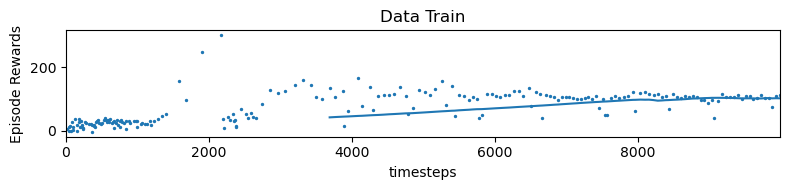

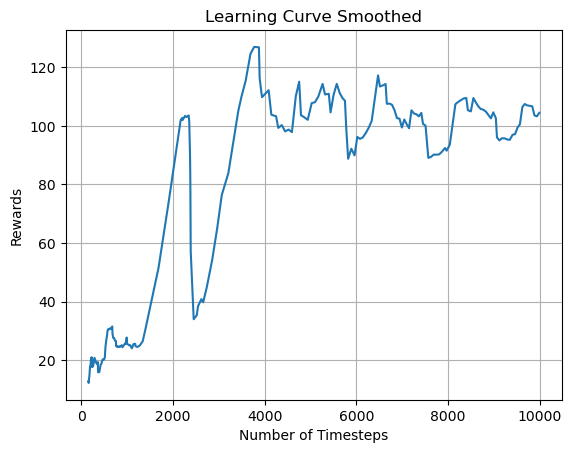

In [12]:
# Helper from the library
results_plotter.plot_results(
    [log_dir], 10000, results_plotter.X_TIMESTEPS, "Data Train"
)
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=10)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.grid()
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()


plot_results(log_dir)



In [9]:
factor_giro = 0.55
diferencia_angular = -4
factor_accion = 0.50
accion_ejercida = 0.5
penalizacion = 0.5
recompensa = (factor_giro * (180-abs(diferencia_angular)) + factor_accion * abs(accion_ejercida) + penalizacion)/100
print(recompensa)

0.9755000000000001


In [18]:
    # Definir parámetros
accion = -1
peso_orientacion = 0.5      # Peso para la diferencia angular
peso_deteccion_giro = 0.5  # Peso para la detección de giro
umbral_giro = 0.5           # Umbral de confianza para considerar la detección de giro
penalizacion_accion = 1.5   # Penalización por acción no deseada
direccion_giro = 1
# Calcular la diferencia angular entre la orientación deseada y la actual
orientacion_deseada = 15 
print("Orientacion detectada: ", orientacion_deseada)
orientacion_actual = -50
print("Orientacion actual: ", orientacion_actual)
diferencia_angular = abs(orientacion_deseada - orientacion_actual)
print("diferencia angular: ", diferencia_angular)
# Calcular la recompensa basada en la diferencia angular
recompensa_orientacion = peso_orientacion * diferencia_angular
print("recompensa orientacion: ", recompensa_orientacion)
deteccion_giro = orientacion_actual

# Calcular la recompensa basada en la detección de giro
recompensa_giro = 0
    
# Determinar la dirección del giro (derecha o izquierda)
direccion_giro = 1 if deteccion_giro > 0 else -1
# Incentivar el giro en la dirección correcta
recompensa_giro = peso_deteccion_giro * direccion_giro
print("recompensa giro: ", recompensa_giro)

# Aplicar penalización por acción no deseada
penalizacion = penalizacion_accion * abs(accion - direccion_giro)
print("penalizacion: ", penalizacion)
# Combinar ambas recompensas y aplicar penalización
recompensa_total = recompensa_orientacion + recompensa_giro - penalizacion


print("recompensa total", recompensa_total)

Orientacion detectada:  15
Orientacion actual:  -50
diferencia angular:  65
recompensa orientacion:  32.5
recompensa giro:  -0.5
penalizacion:  0.0
recompensa total 32.0
